In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
#%load_ext memory_profiler
from IPython.display import Image, HTML

import datetime as dt
#from hdbscan import HDBSCAN
from itertools import cycle
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mpd
from mpl_toolkits.mplot3d import Axes3D
import numexpr as ne
import numpy as np
import pandas as pd
import pysolar
import pytz
import random
import scipy
from scipy.signal import medfilt, wiener, firwin
import scipy.signal as signal
import seaborn as sns
import sklearn
import sklearn.metrics as metrics
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from enerpi.base import timeit
#from enerpi.api import enerpi_data_catalog
#from enerpi.process_ldr import pca_clustering, plot_clustering, plot_clustering_as_voronoi, plot_clustering_figure, tableau20
from enerpi.enerplot import tableau20
from enerpi.event_detection import load_data, process_data_for_event_detection, rect_smoothing, genera_df_intervalos, plot_steps_detection, get_subsets
from enerpi.sunposition import sun_position
from prettyprinting import *


TZ = pytz.timezone('Europe/Madrid')
FS = (16, 10)
sns.set_style('ticks')
pd.set_option('display.width', 120)
cm = cycle(tableau20[2::2])

train = pd.read_hdf('/Users/uge/Dropbox/PYTHON/PYPROJECTS/enerpi/notebooks/train.h5', 'power')
train_ev = process_data_for_event_detection(train)

# Subsets of train data:
df_1, df_2, df_3, df_4, df_5, df_6, df_7 = get_subsets(train_ev)
#df_1 = train_ev.loc['2016-09-10'].between_time('8:30', '10:30')
#df_2 = train_ev.loc['2016-09-08'].between_time('8:00', '14:00')
#t0, tf = '2016-09-10 19:30', '2016-09-10 23:40'
#df_3 = train_ev.loc[t0:tf]
#t0, tf = '2016-09-10 20:30', '2016-09-10 22:50'
#df_4 = train_ev.loc[t0:tf]

#df_5 = train_ev.loc['2016-09-15']
#df_6 = train_ev.loc['2016-09-16']
#df_7 = train_ev.loc['2016-09-17']

print_info(train_ev.head())
train_ev.tail()

process_data_for_event_detection TOOK: 0.360 s
                                power      wiener  delta_wiener abs_ch     r_std      r_mean
ts                                                                                          
2016-09-08 00:00:00+02:00  361.305145  342.040003      0.000000  False  3.107158  351.192982
2016-09-08 00:00:01+02:00  369.346436  351.099659      9.059656  False  3.975461  352.145975
2016-09-08 00:00:02+02:00  366.049744  349.689666     -1.409993  False  4.284531  353.284948
2016-09-08 00:00:03+02:00  365.854706  350.670636      0.980969  False  4.483639  354.383428
2016-09-08 00:00:04+02:00  365.262390  351.124023      0.453387  False  4.566204  355.560576


power      wiener  delta_wiener abs_ch     r_std      r_mean
ts                                                                                          
2016-09-21 23:59:55+02:00  303.374023  287.207422     -7.863055  False  7.336845  283.642861
2016-09-21 23:59:56+02:00  293.039185  277.787957     -9.419465  False  7.336845  283.642861
2016-09-21 23:59:57+02:00  303.040344  284.064992      6.277035  False  7.336845  283.642861
2016-09-21 23:59:58+02:00  301.786438  281.173786     -2.891206  False  7.336845  283.642861
2016-09-21 23:59:59+02:00  294.609619  272.548244     -8.625542  False  7.336845  283.642861

process_filters TOOK: 0.005 s
process_filters TOOK: 0.006 s
process_filters TOOK: 0.006 s


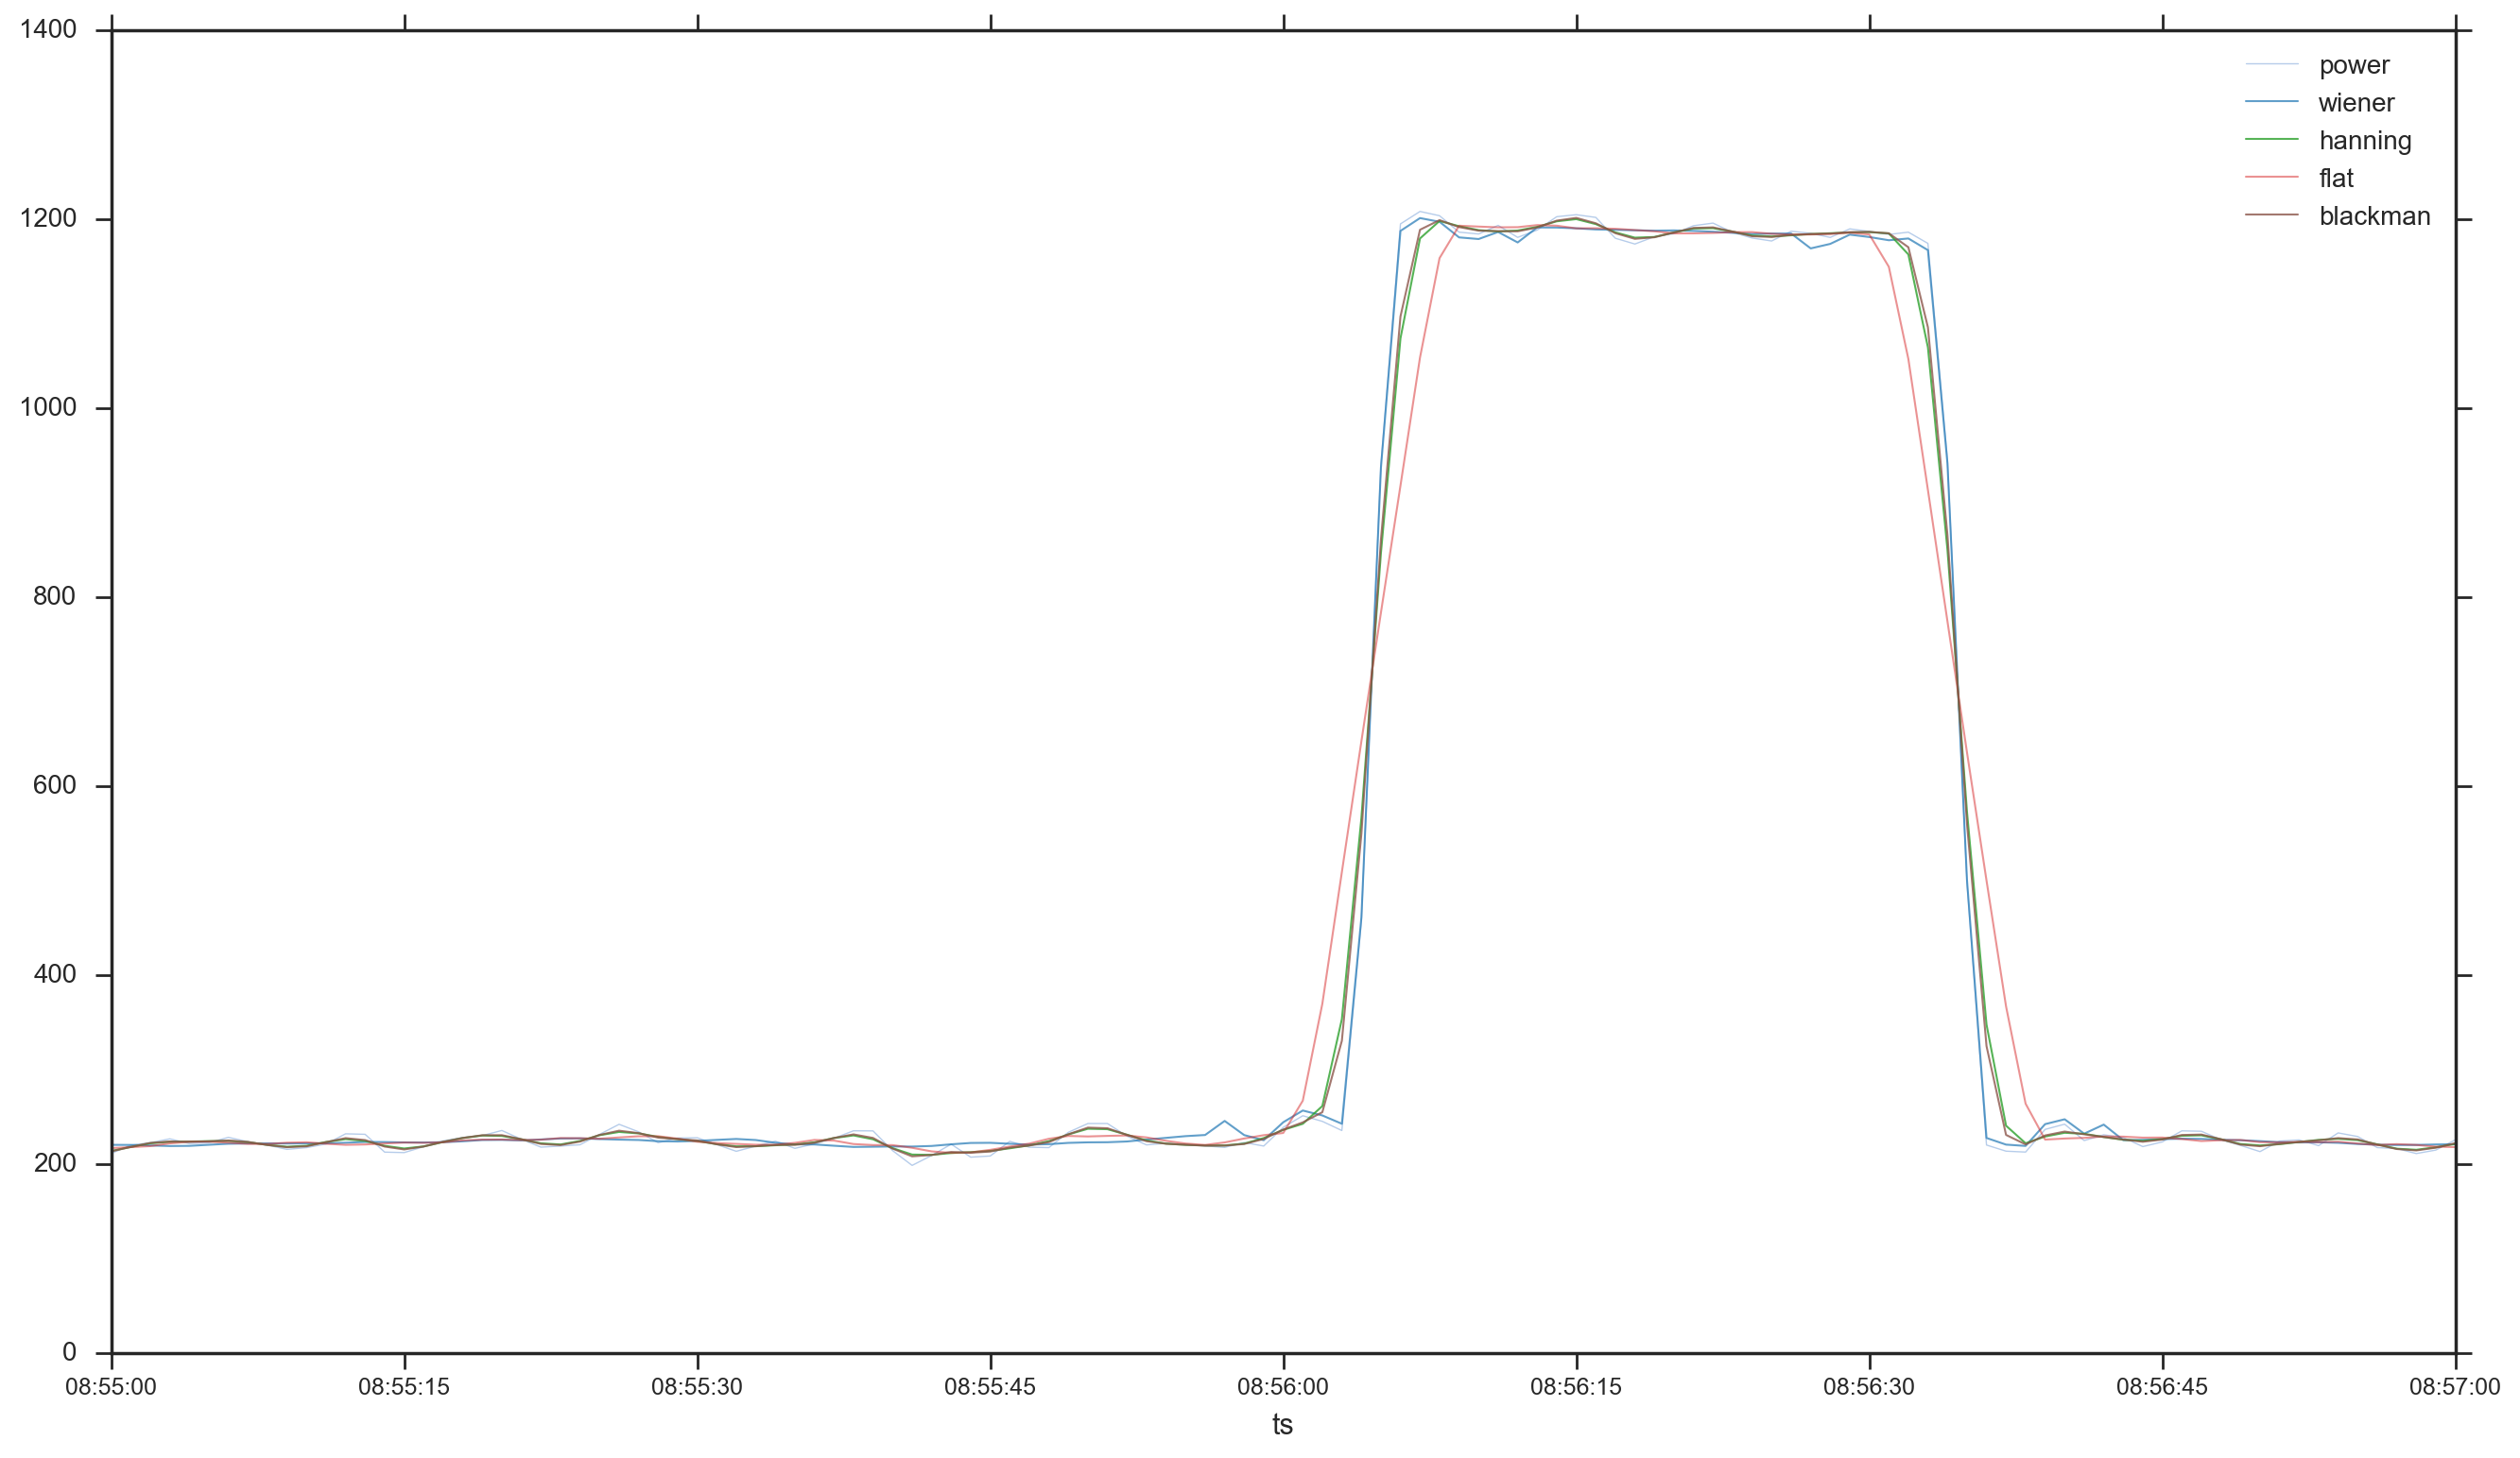

In [2]:
EXCLUDED_COLS = ['power', 'delta_wiener', 'abs_ch', 'r_std', 'r_mean']

# From http://stackoverflow.com/questions/5515720/python-smooth-time-series-data
# Using http://www.scipy.org/Cookbook/SignalSmooth:
FILTERS = ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']
D_FILTERS = {'power': dict(lw=.5, alpha=.9, color=tableau20[1]),
             'wiener': dict(lw=.75, alpha=.7, color=tableau20[0]),
             'medfilt': dict(lw=.75, alpha=.5, color=tableau20[2]),
             'flat': dict(lw=.75, alpha=.5, color=tableau20[6]),
             'hanning': dict(lw=.75, alpha=.8, color=tableau20[4]),
             #'hamming': dict(lw=.75, alpha=.8, color=tableau20[6]),
             #'bartlett': dict(lw=.75, alpha=.8, color=tableau20[8]),
             'blackman': dict(lw=.75, alpha=.8, color=tableau20[10]), 
             'savgol': dict(lw=1, alpha=.8, color=tableau20[12])}


def _smooth(x, window_len=11, window='hanning'):
        if x.ndim != 1:
                raise ValueError("smooth only accepts 1 dimension arrays.")
        if x.size < window_len:
                raise ValueError("Input vector needs to be bigger than window size.")
        if window_len < 3:
                return x
        if not window in FILTERS:
                raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
        s= np.r_[2*x[0]-x[window_len-1::-1],x,2*x[-1]-x[-1:-window_len:-1]]
        if window == 'flat': #moving average
            w=np.ones(window_len,'d')
        else:  
            w=eval('np.'+window+'(window_len)')
        y=np.convolve(w/w.sum(),s,mode='same')
        return y[window_len:-window_len+1]

    
@timeit('process_filters', verbose=True)
def process_filters(df, window_len=11, filters=FILTERS):
    df_out = df.copy()
    for w in filters:
        df_out[w] = _smooth(df.power.values, window_len, w)
    return df_out
    

def plot_filters(df, filters=D_FILTERS.keys()):
    ax = df.power.plot(figsize=FS, legend='RAW', **D_FILTERS['power'])
    for k in filters:
        if (k in df) and (k in filters) and k != 'power':
            df[k].plot(ax=ax, legend=k, **D_FILTERS[k])
    ax.xaxis.set_major_formatter(mpd.DateFormatter('%H:%M:%S', tz=TZ))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')
    ax.xaxis.set_tick_params(labelsize=9, pad=3)
    return ax


window_len = 7
df_1f = process_filters(df_1, window_len=window_len, filters=FILTERS)
df_2f = process_filters(df_2, window_len=window_len, filters=FILTERS)
df_3f = process_filters(df_3, window_len=window_len, filters=FILTERS)


plot_filters(df_1f.between_time('8:55', '8:57'));

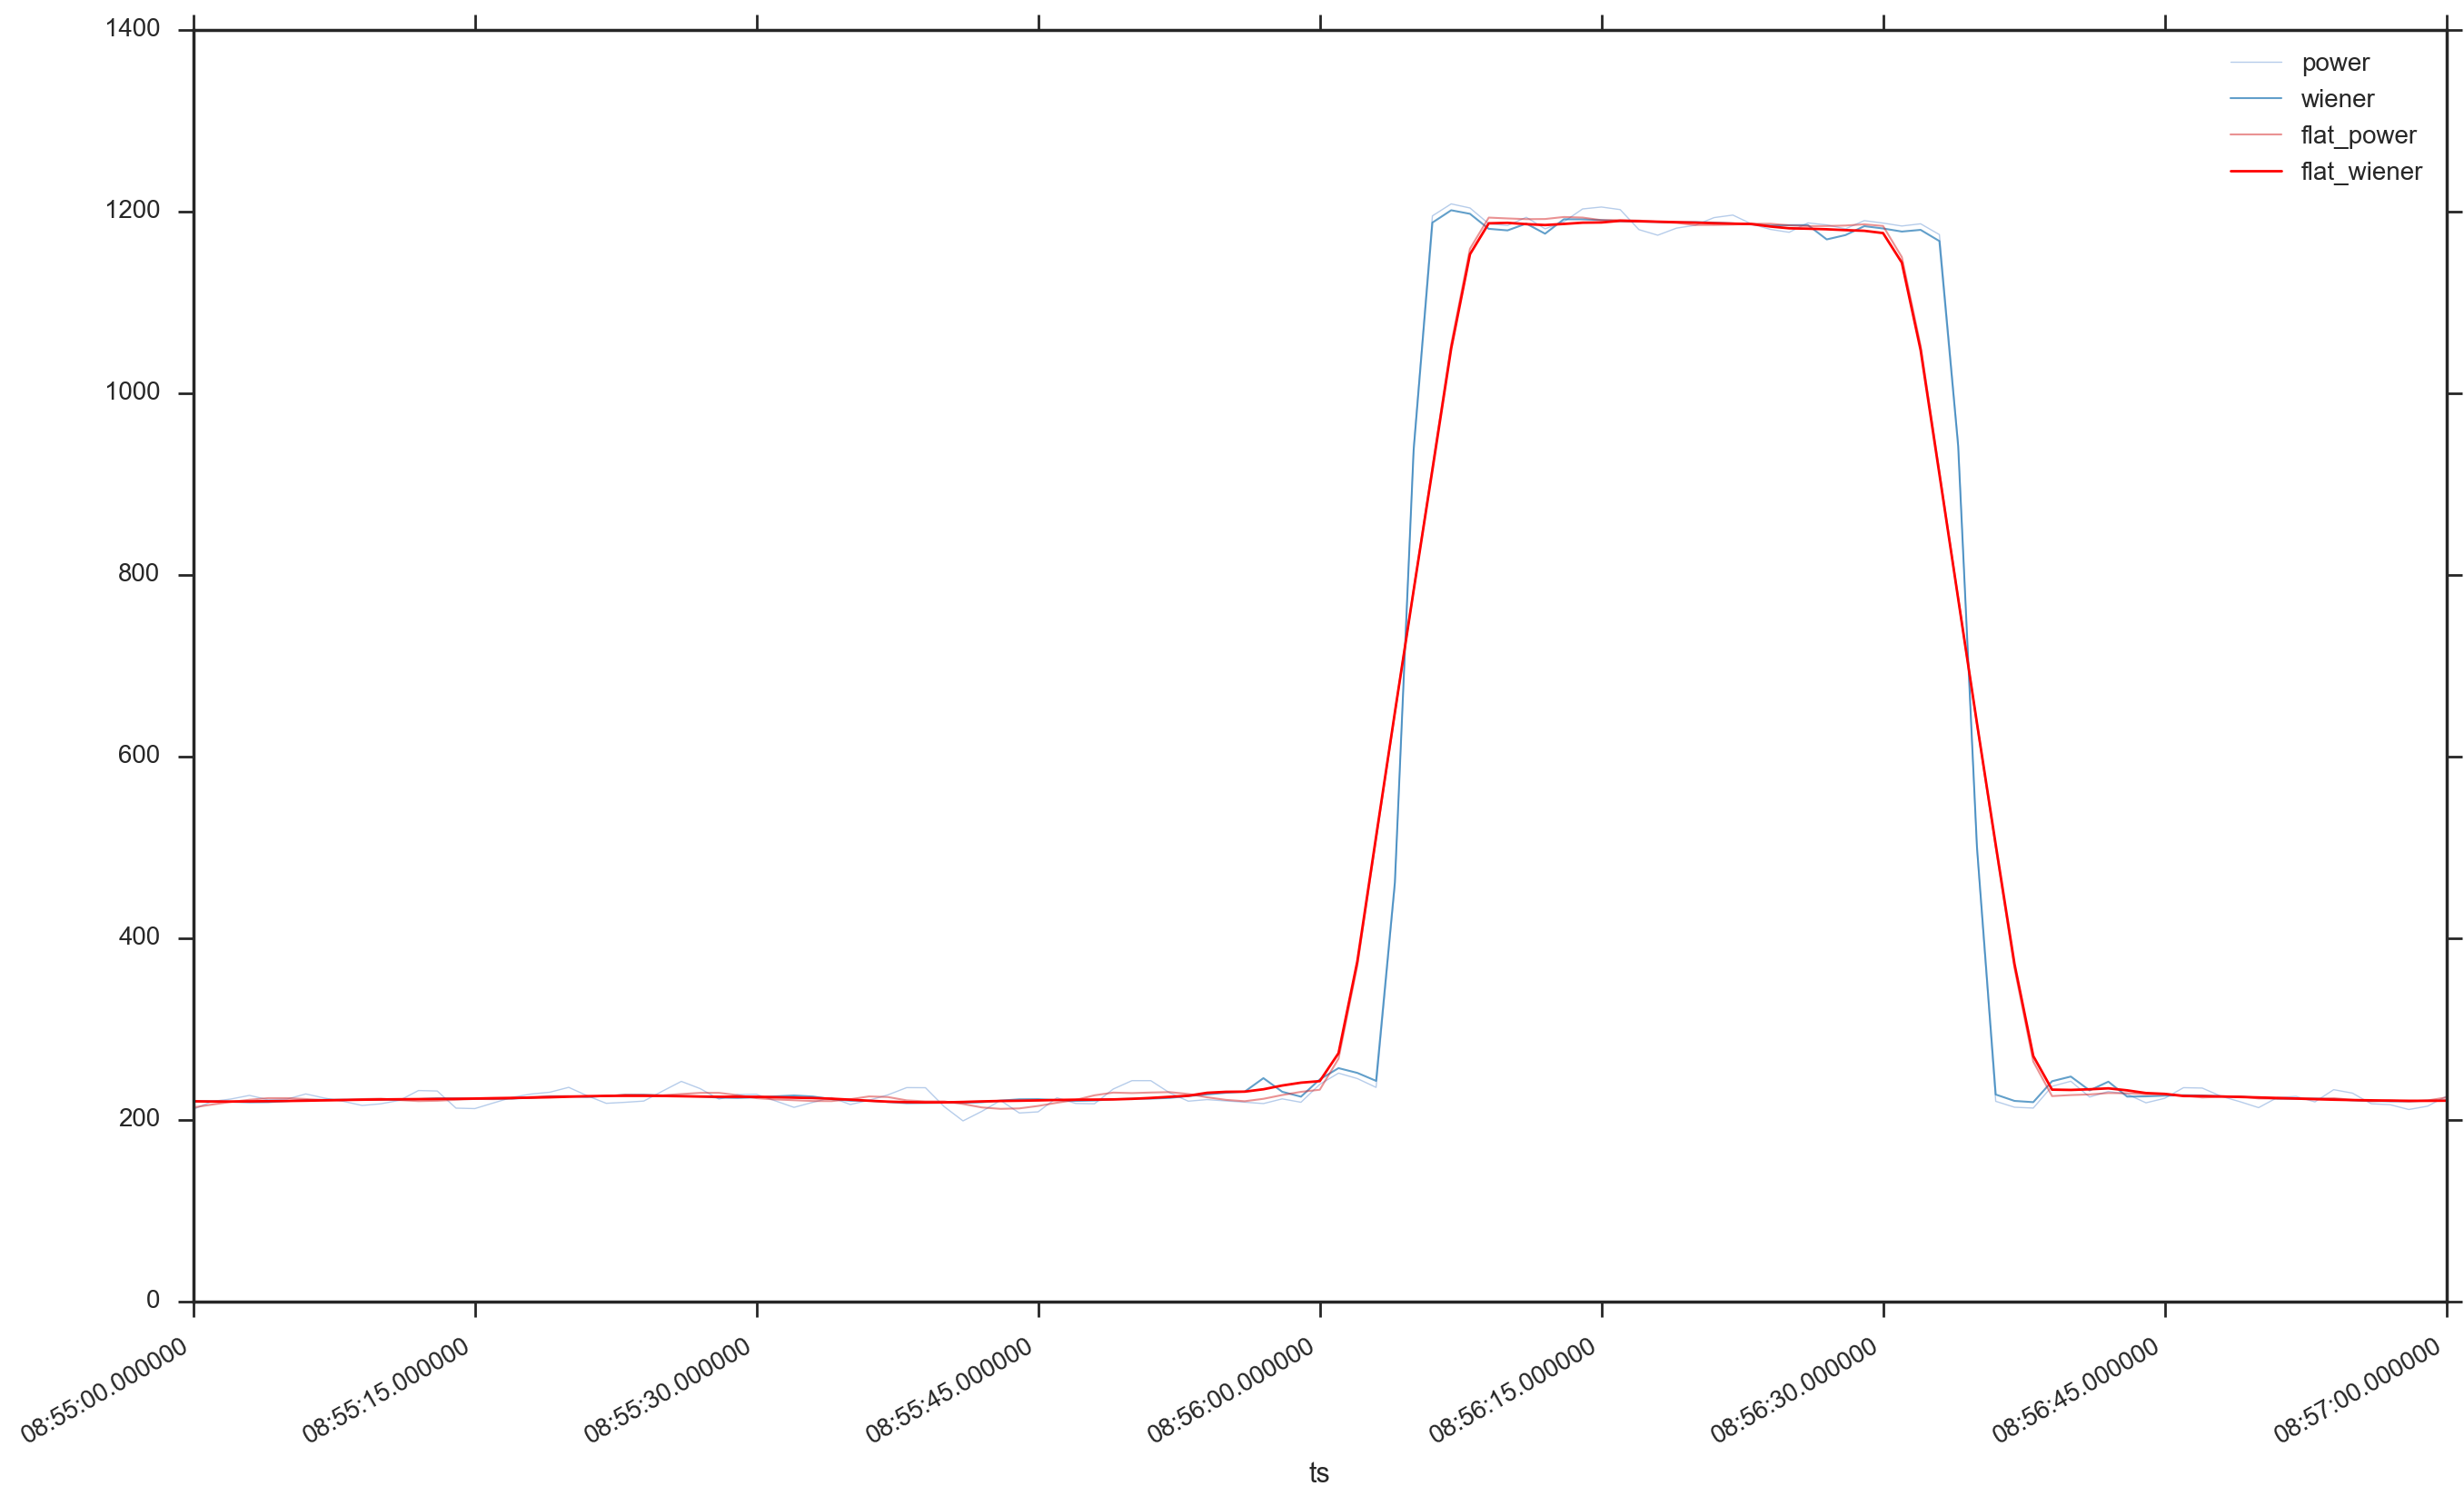

In [4]:
df = df_1f.between_time('8:55', '8:57').copy()
df['flat_power'] = _smooth(df.power.values, 7, 'flat')
df['flat_wiener'] = _smooth(df.wiener.values, 7, 'flat')

#, **D_FILTERS['wiener']
ax = df.power.plot(figsize=FS, **D_FILTERS['power'], legend='RAW')
df.wiener.plot(ax=ax, **D_FILTERS['wiener'], legend='wiener')
df.flat_power.plot(ax=ax, **D_FILTERS['flat'], legend='flat power')
df.flat_wiener.plot(ax=ax, color='red', lw=1, legend='flat wiener');

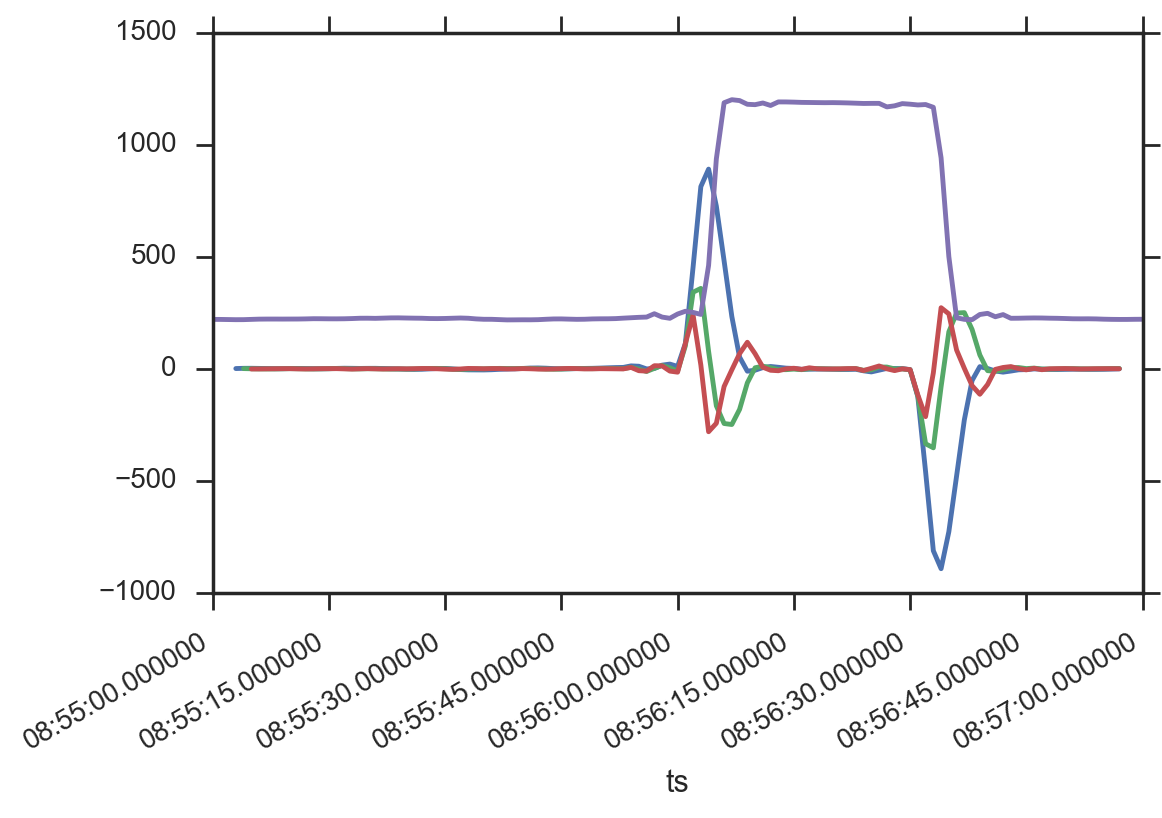

In [105]:
def _roll(x):
    n = x.shape[0]
    mid = n // 2 + 1
    return np.mean(x[mid+1:]) - np.mean(x[:mid])
    

ax = df.wiener.rolling(7, center=True).apply(_roll).plot()
df.wiener.rolling(7, center=True).apply(_roll).diff().plot(ax=ax)
df.wiener.rolling(7, center=True).apply(_roll).diff().diff().plot(ax=ax)
df.wiener.plot(ax=ax)

In [3]:
df = df_5 #.between_time('9:00', '13:00')
df_step = rect_smoothing(df)
df_interv = genera_df_intervalos(df, df_step)
print_ok(df_interv.tail())

rect_smoothing TOOK: 2.476 s
              n_ch     n  median_all  std_all  step_median_0   delta                        ts  \
interv_shift                                                                                     
0                5   547       337.0      4.2            337     0.0 2016-09-14 22:00:00+00:00   
1               16  1124       243.0      8.9            243   -94.0 2016-09-14 22:09:07+00:00   
2                9  3725       220.0     10.8            219   -24.0 2016-09-14 22:27:51+00:00   
3               10   101       249.0      6.8            248    29.0 2016-09-14 23:29:56+00:00   
4                9  1471       217.0      2.7            217   -31.0 2016-09-14 23:31:37+00:00   
5                6  2119       233.0     15.8            232    15.0 2016-09-14 23:56:08+00:00   
6               19    77       256.0      8.8            256    24.0 2016-09-15 00:31:27+00:00   
7                1  3585       213.0      5.5            213   -43.0 2016-09-15 00:32:44+

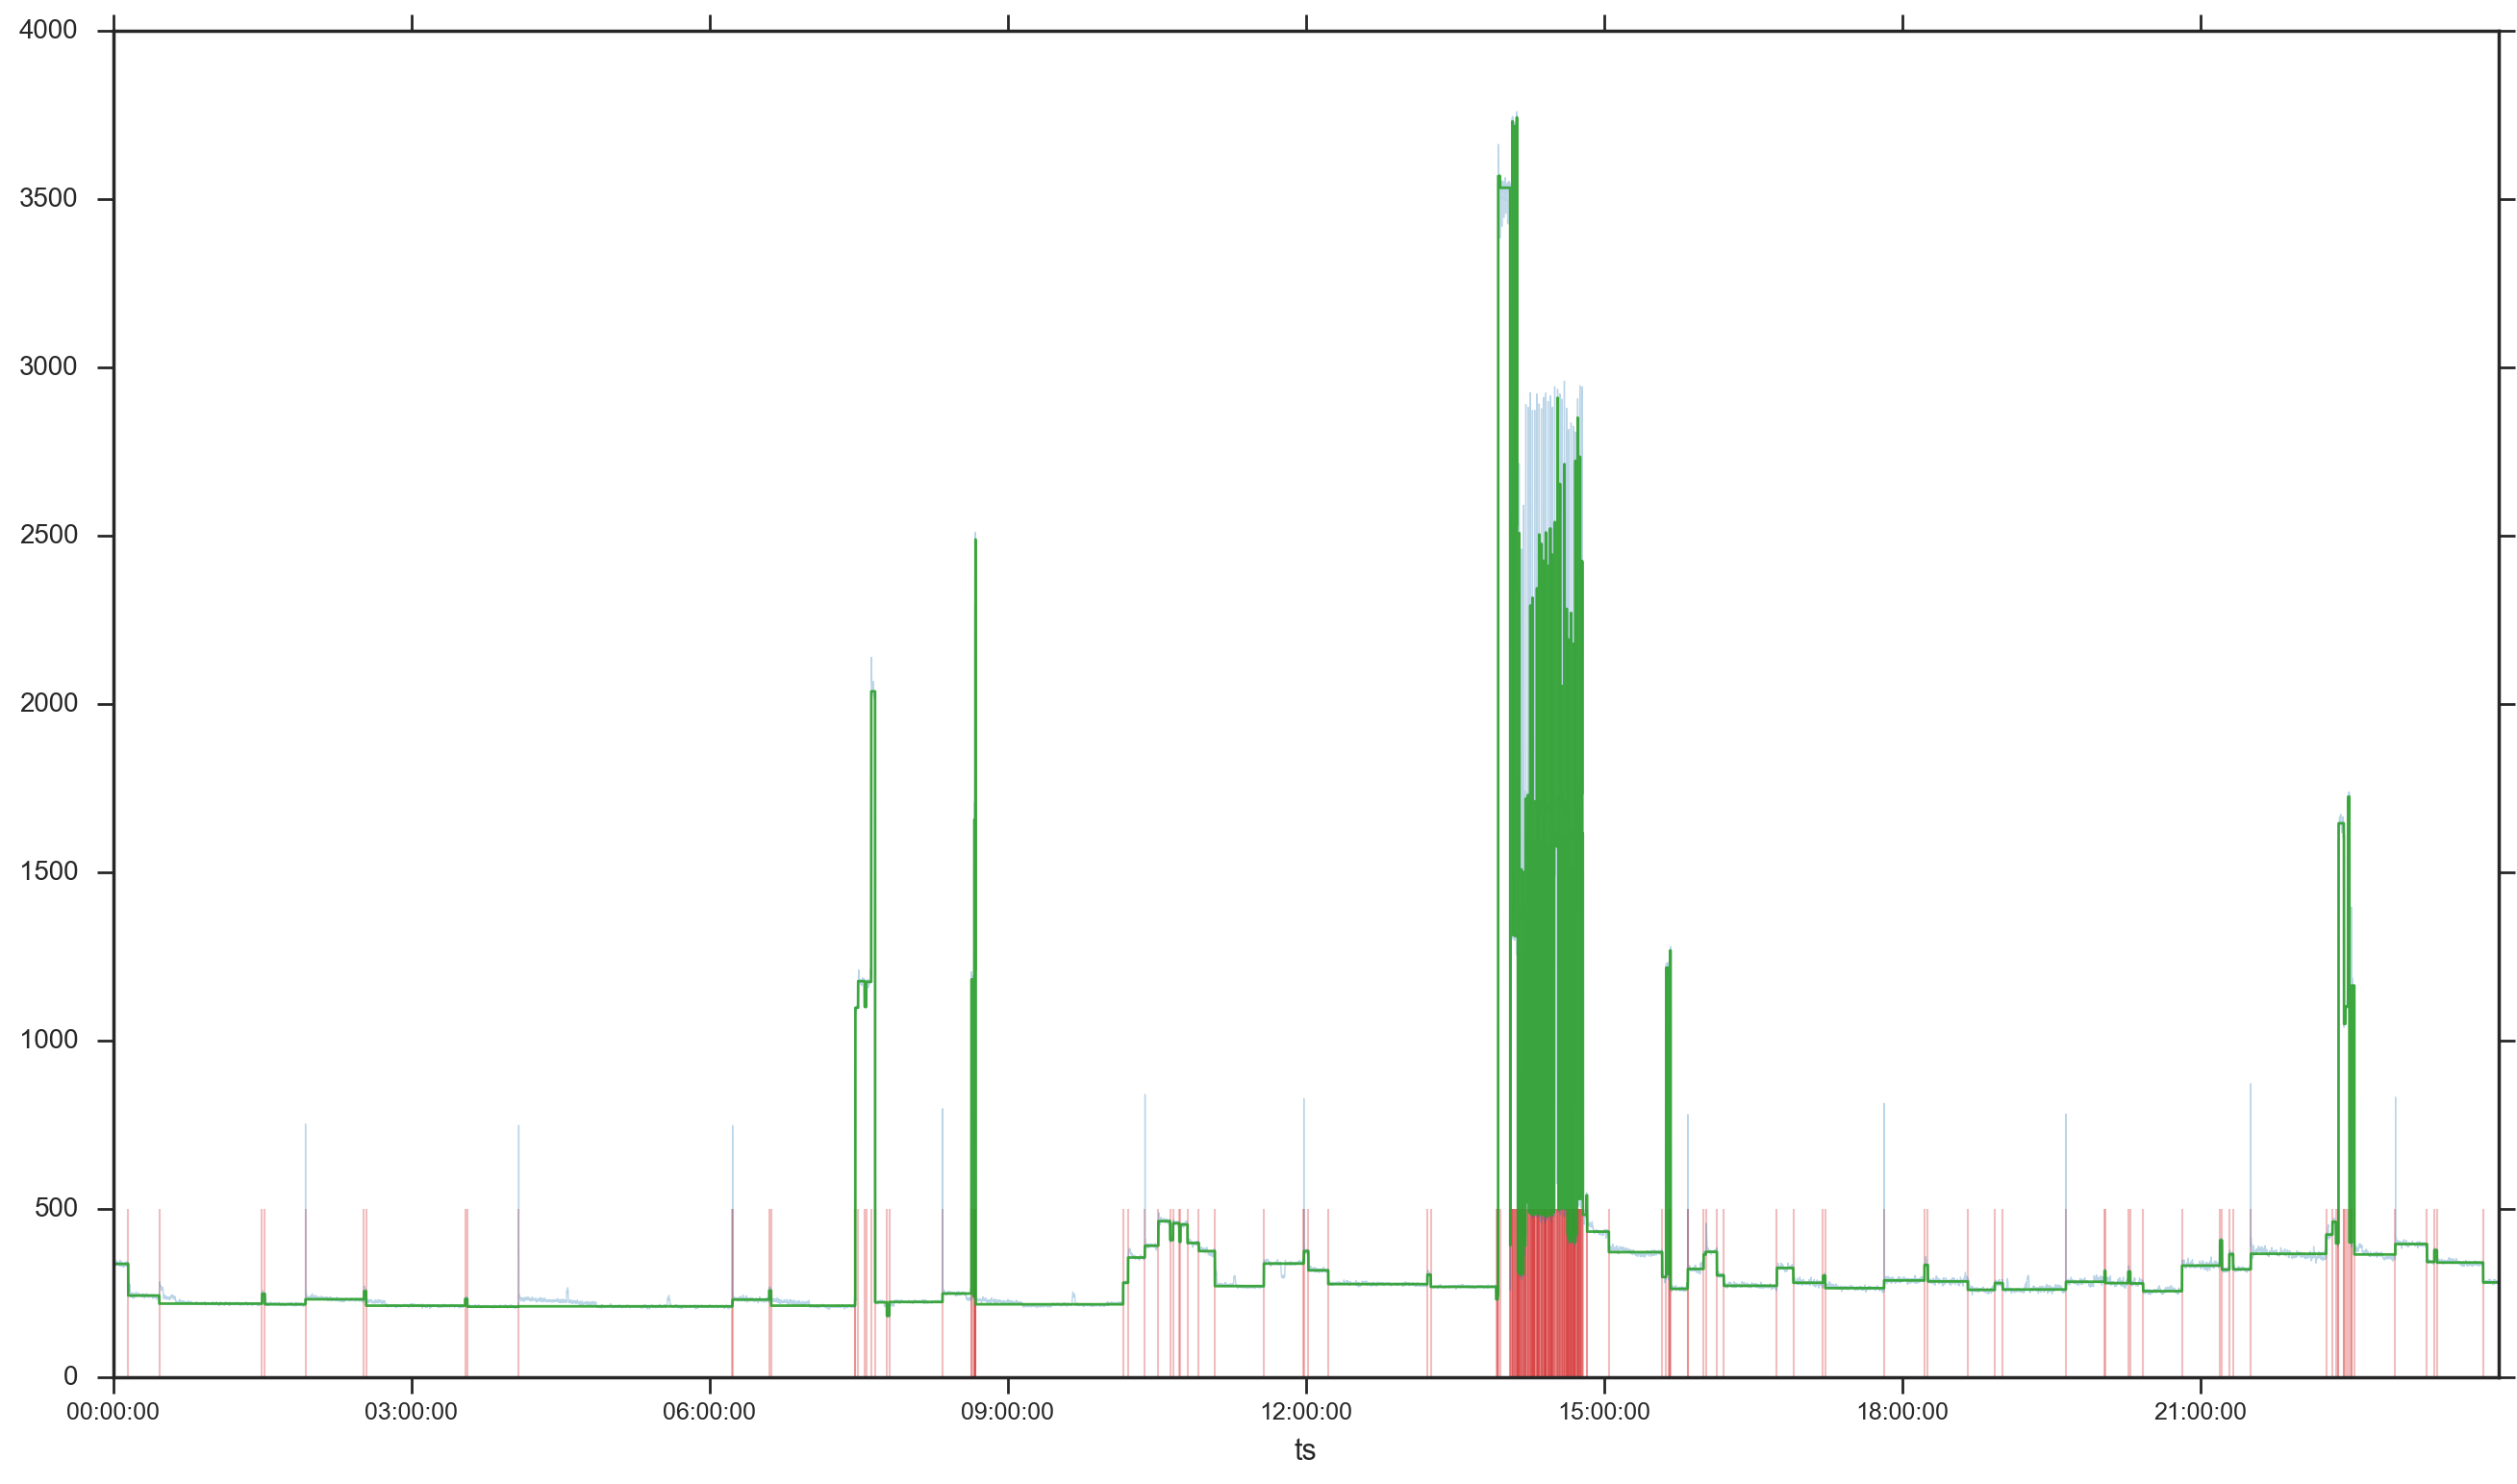

In [4]:
plot_steps_detection(df, df_step);

In [37]:
df_interv['ts_fin'] = df_interv.ts.shift(-1)
df_interv['next_delta'] = df_interv['delta'].shift(-1)
df_interv['permanent_delta'] = df_interv['delta'] + df_interv['next_delta']


df_interv.tail()

n_ch  abs_ch     n  median_all  std_all  delta  step_v                  ts     ch     wiener  std_c  \
interv_shift                                                                                                        
251             15      15  1148       397.0     17.6     31     396 2016-09-15 22:57:45  False  17.478665   -1.0   
252             12      12   264       344.0      7.8    -53     343 2016-09-15 23:16:53   True   5.243193    3.0   
253             11      11    96       378.0      7.9     35     378 2016-09-15 23:21:17  False   4.252339   -1.0   
254             10      10  1672       341.0      5.0    -37     341 2016-09-15 23:22:53  False   4.754309   -1.0   
255             10      10   555       283.0      5.3    -59     282 2016-09-15 23:50:45   True   3.850973    3.2   

                          ts_fin  next_delta  permanent_delta  
interv_shift                                                   
251          2016-09-15 23:16:53       -53.0            -22.0  
252          2016-09-15 23:21:17        35.0            -18.0  
253          2016-09-15 23:22:53       -37.0             -2.0  
254          2016-09-15 23:50:45       -59.0            -96.0  
255                          NaT         NaN              NaN

In [5]:
def __plot_steps_detection(df_data, df_step, df_interv=None):
    _, ax = plt.subplots(figsize=FS)
    ax.xaxis.set_major_formatter(mpd.DateFormatter('%H:%M:%S', tz=TZ))
    if df_interv is None:
        df_data.wiener.plot(ax=ax, lw=.5, alpha=.3, color=tableau20[0])
        # (df_step.is_init.abs() * 1000).plot(ax=ax, lw=.75, alpha=.3, color=tableau20[6])
        ax.vlines(df_step[df_step.is_init].index, 0, 500, lw=.75, alpha=.3, color=tableau20[6])
        df_step.step_median.plot(ax=ax, lw=1, alpha=.9, color=tableau20[4])
        # (df_step.ch.abs() * 500).plot(ax=ax, lw=.75, alpha=.3, color=tableau20[6])
        # df_debug.mean_planos.plot(ax=ax, lw=.75, alpha=.7, color=tableau20[8])
        # df_debug.error_cum.plot(ax=ax, lw=.5, alpha=.9, color=tableau20[2])
    else:
        offset = pd.Timedelta('3s')
        df_i = df_data.loc[df_interv.ts.iloc[0]-offset:df_interv.ts_fin.iloc[-1]+offset]
        df_i_s = df_step.loc[df_interv.ts.iloc[0]-3*offset:df_interv.ts_fin.iloc[-1]+3*offset]
        if not df_i.empty:
            df_i.wiener.plot(ax=ax, lw=.5, alpha=.3, color=tableau20[0])
            df_i_s.step_median.plot(ax=ax, lw=1, alpha=.9, color=tableau20[4])
        else:
            print_err(df_interv)
            
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')
    ax.xaxis.set_tick_params(labelsize=9, pad=3)
    return ax


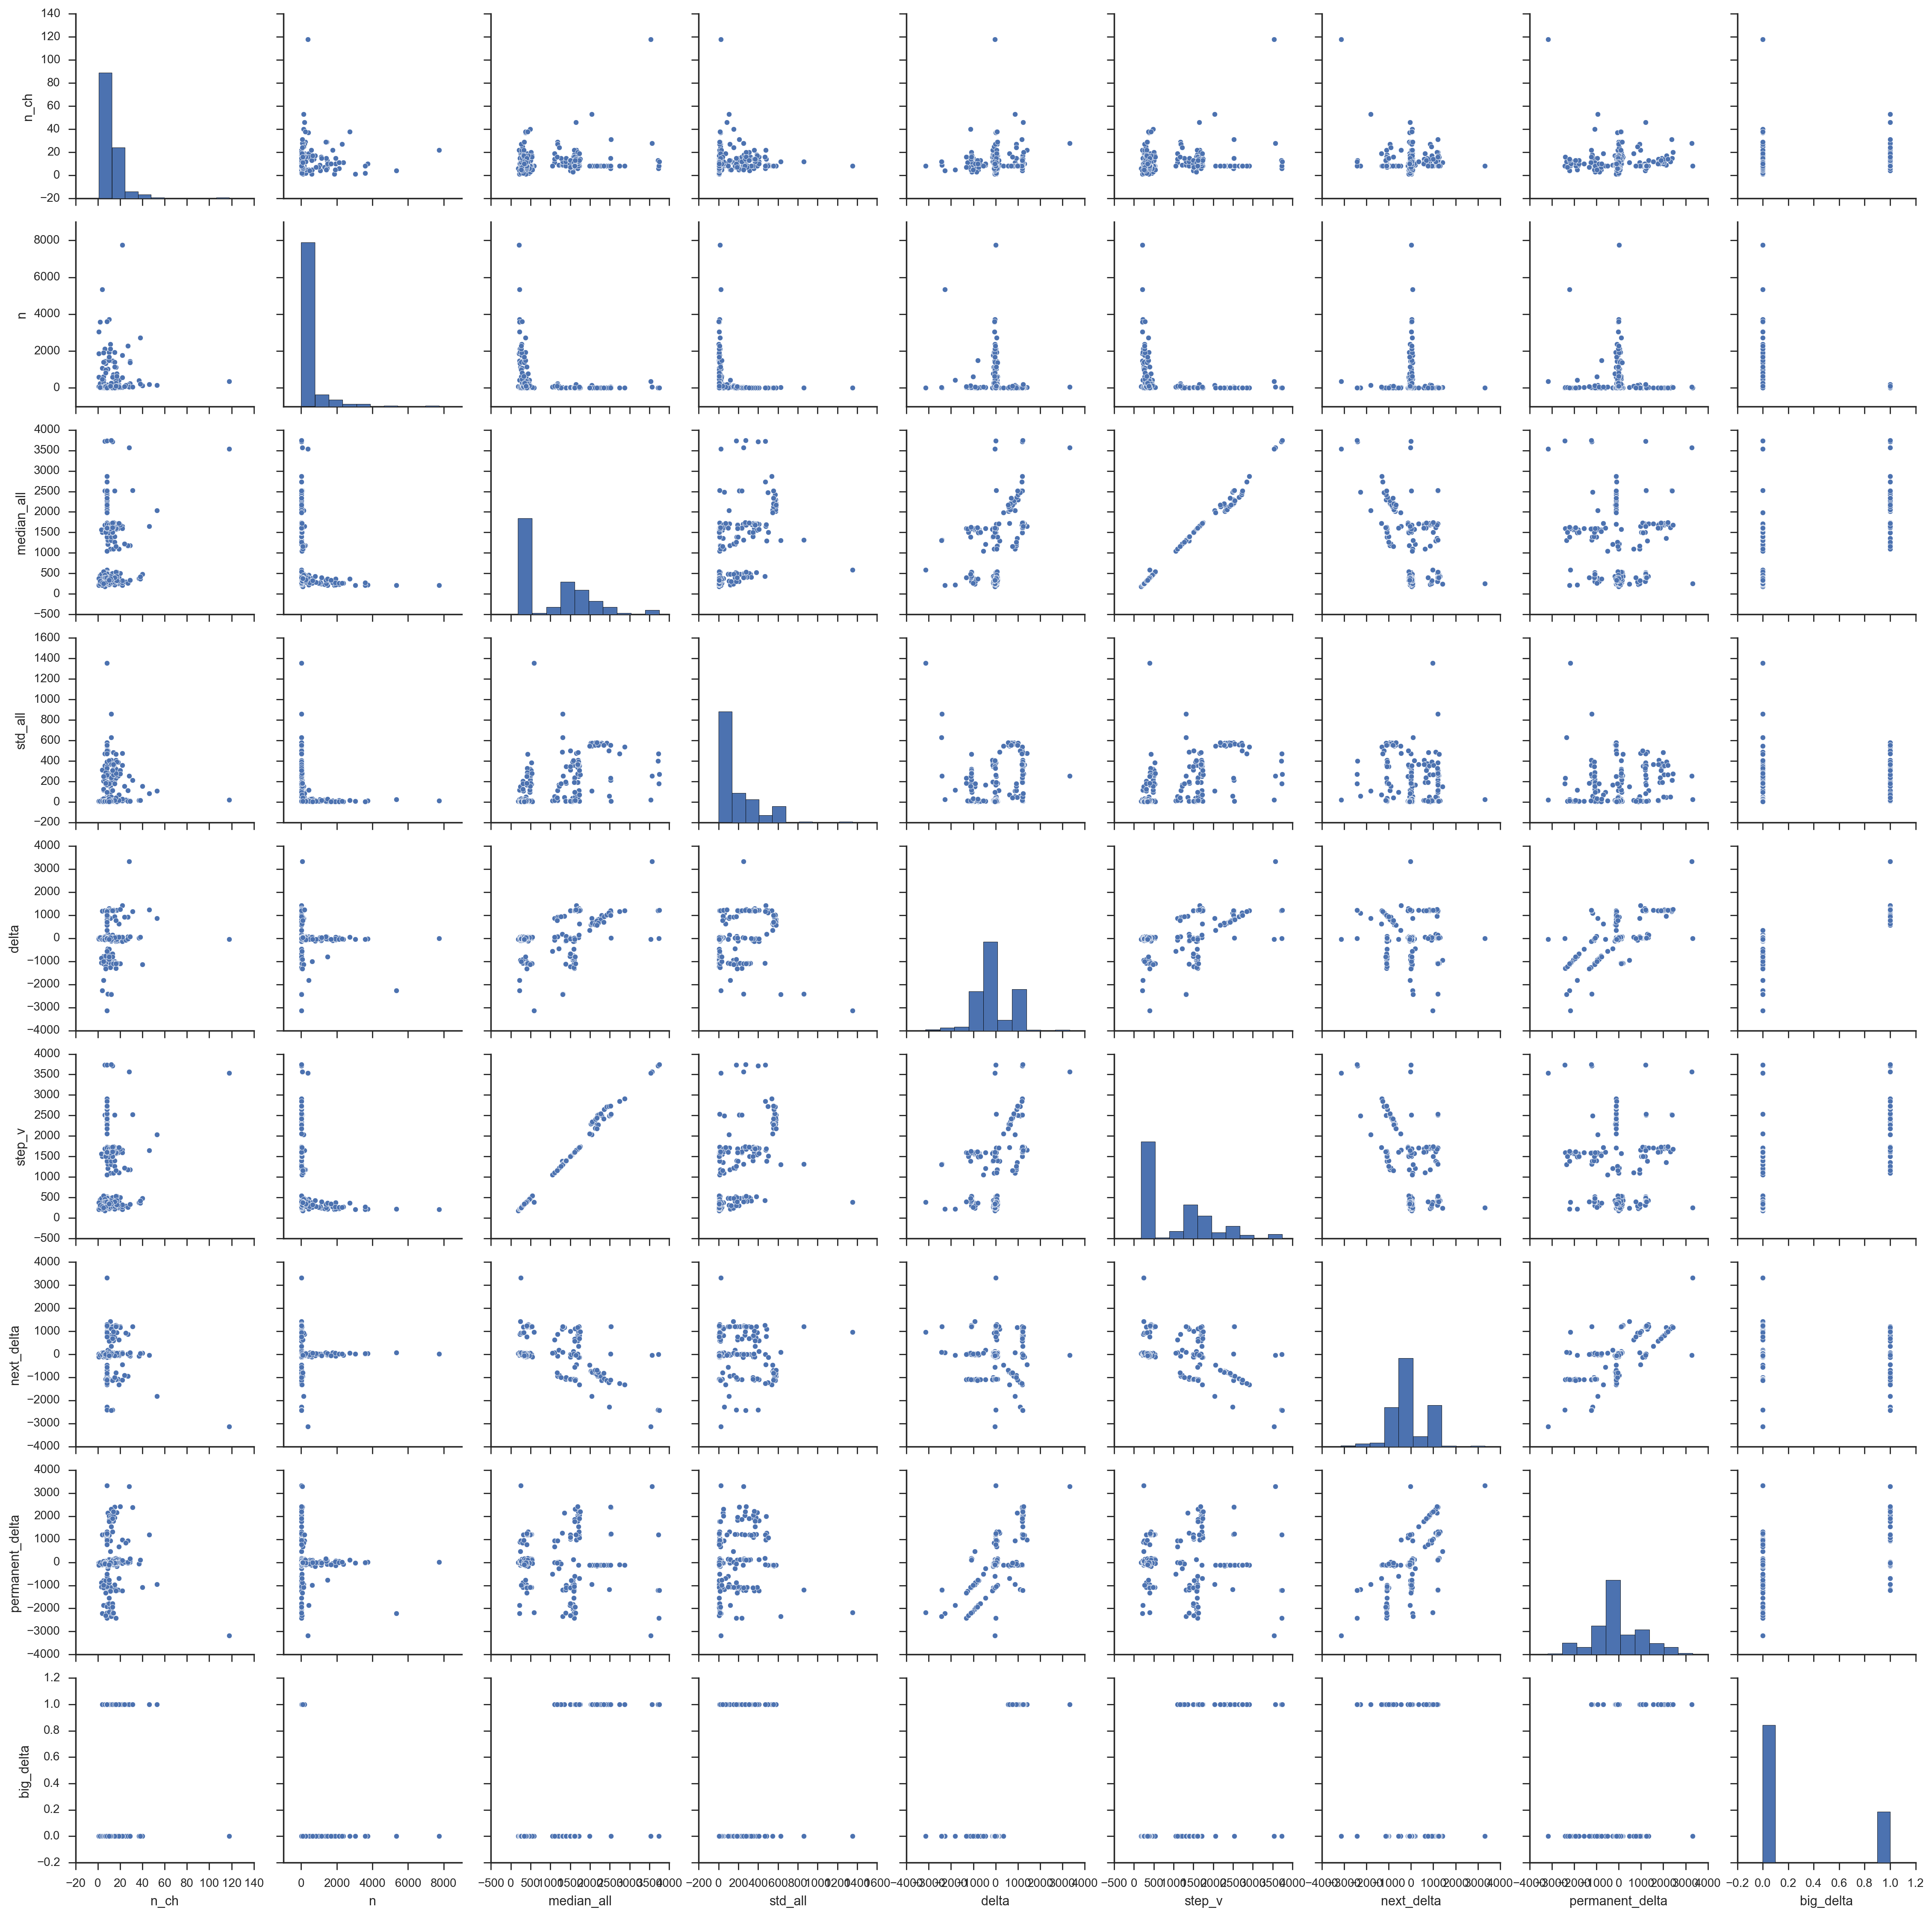

In [79]:
dp = df_interv.drop(['ts', 'ts_fin', 'ch', 'std_c', 'abs_ch', 'wiener'], axis=1).dropna(how='any', axis=0)
# [df_interv.n < 300]
sns.pairplot(dp) #, hue='permanent_delta')

In [8]:
@timeit('fusion_big_events', verbose=True)
def _fusion_big_events(df_interv):
    filtrados = df_interv[(df_interv.delta > 500) | (df_interv.median_all > 1000) | (df_interv.std_all > 100)]

    grupos = []
    g_i = []
    ant_vip = False
    level = 0
    levels = []
    d_acum = df_interv.median_all[0]
    for i, row in df_interv.iterrows():
        if ((d_acum > 500) or 
            (row.delta > 500) or 
            ((row.std_all > 100) and (d_acum > 50)) or 
            (row.median_all - level > 200)):
            if not ant_vip and (len(g_i) == 0):
                level = row.median_all - row.delta
                d_acum = row.delta
                #print_info('NEW {} con median_all={:.0f}, delta={:.0f} --> level = {:.0f}'
                #           .format(i, row.median_all, row.delta, level))
                if len(g_i) > 0:
                    #print_info('se cierra anterior: {}'.format(g_i))
                    grupos.append(g_i)
                g_i = [i]
            else:
                d_acum += row.delta
                #print(i, abs(d_acum), row.delta, row.median_all)
                if abs(d_acum) < 100:
                    if len(g_i) > 0:
                        #print_cyan('se añaden {}'.format(g_i))
                        grupos.append(g_i)
                    g_i = []
                    level = row.median_all # - row.delta
                    d_acum = level
                else:
                    g_i.append(i)
            ant_vip = True
        else:
            ant_vip = False
            if len(g_i) > 0:
                #g_i.append(i)
                grupos.append(g_i)
                #print_red('se cierra {}, level_ant={:.0f}, ∆={:.0f}, new_level={:.0f}'
                #          .format(g_i, level, row.delta, row.median_all))
            #g_i = [i]
            g_i = []
            level = row.median_all
            d_acum = level
        #print_magenta('{} -> {:.0f}, {}'.format(i, level, g_i))
        levels.append(level)
    df_interv['level'] = levels
        #if i - 1 == i_ant:
        #    g_i.append(i)
        #    i_ant = i
        #else:
        #    grupos.append(g_i)
        #    g_i = [i]
        #    i_ant = i

    print_red(grupos[:5])
    return df_interv, grupos


@timeit('integrate_step_detection', verbose=True)
def _integrate_step_detection(df, df_step, df_interv):
    """
    Concatena la información de la detección de escalones (eventos) y numera los intervalos.
    """
    df_out = df[['power', 'wiener']].join(df_step[['step_median', 'step_mean', 'is_init']])
    df_out['init_event'] = df_out['is_init']
    df_out['big_event'] = False
    # df_out.is_init.cumsum()

    # Big events:
    df_interv, grupos = _fusion_big_events(df_interv)
    
    df_interv['ts_fin'] = df_interv['ts'].shift(-1)
    df_interv['big_event'] = -1
    for i, idx in enumerate(grupos):
        df_interv.loc[idx, 'big_event'] = i + 1

    offset = pd.Timedelta('3s')
    gb_big = df_interv[df_interv.big_event > 0].groupby('big_event')
    big_events = pd.concat([gb_big.ts.first() - offset,
                            gb_big.ts_fin.last() + offset,
                            gb_big.n.sum(),
                            gb_big['level'].first(),
                            gb_big.median_all.max(),
                            gb_big.std_all.median()], axis=1).reset_index()
    
    counter_big_ev = 0
    offset_min = pd.Timedelta('1s')
    for ts, ts_fin in zip(big_events.ts, big_events.ts_fin):
        df_out.loc[ts+offset_min:ts_fin, 'init_event'] = False
        df_out.loc[ts:ts_fin, 'big_event'] = True

    df_out['intervalo'] = df_out['init_event'].cumsum()
    return df_out


df_out = _integrate_step_detection(df, df_step, df_interv)
df_out.head()
#df_out.tz_localize(None).reset_index().groupby('intervalo').big_event.sum()

[[0], [31, 32, 33, 34, 35, 36, 37, 38, 39], [41, 42], [61, 62], [67]]
fusion_big_events TOOK: 0.024 s
integrate_step_detection TOOK: 0.060 s


power      wiener  step_median  step_mean is_init init_event big_event  intervalo
ts                                                                                                               
2016-09-17 00:00:00+02:00  222.060257  231.626156          218        220   False      False     False          0
2016-09-17 00:00:01+02:00  233.656845  231.442630          218        220   False      False     False          0
2016-09-17 00:00:02+02:00  236.062698  231.891288          218        220   False      False     False          0
2016-09-17 00:00:03+02:00  229.603241  232.717262          218        220   False      False     False          0
2016-09-17 00:00:04+02:00  239.614746  233.419937          218        220   False      False     False          0

In [6]:
[mpd.num2date(x) for x in [736221.916667, 736222.915972]]

[datetime.datetime(2016, 9, 14, 22, 0, 0, 28803, tzinfo=<matplotlib.dates._UTC object at 0x1081d40b8>),
 datetime.datetime(2016, 9, 15, 21, 58, 59, 980798, tzinfo=<matplotlib.dates._UTC object at 0x1081d40b8>)]

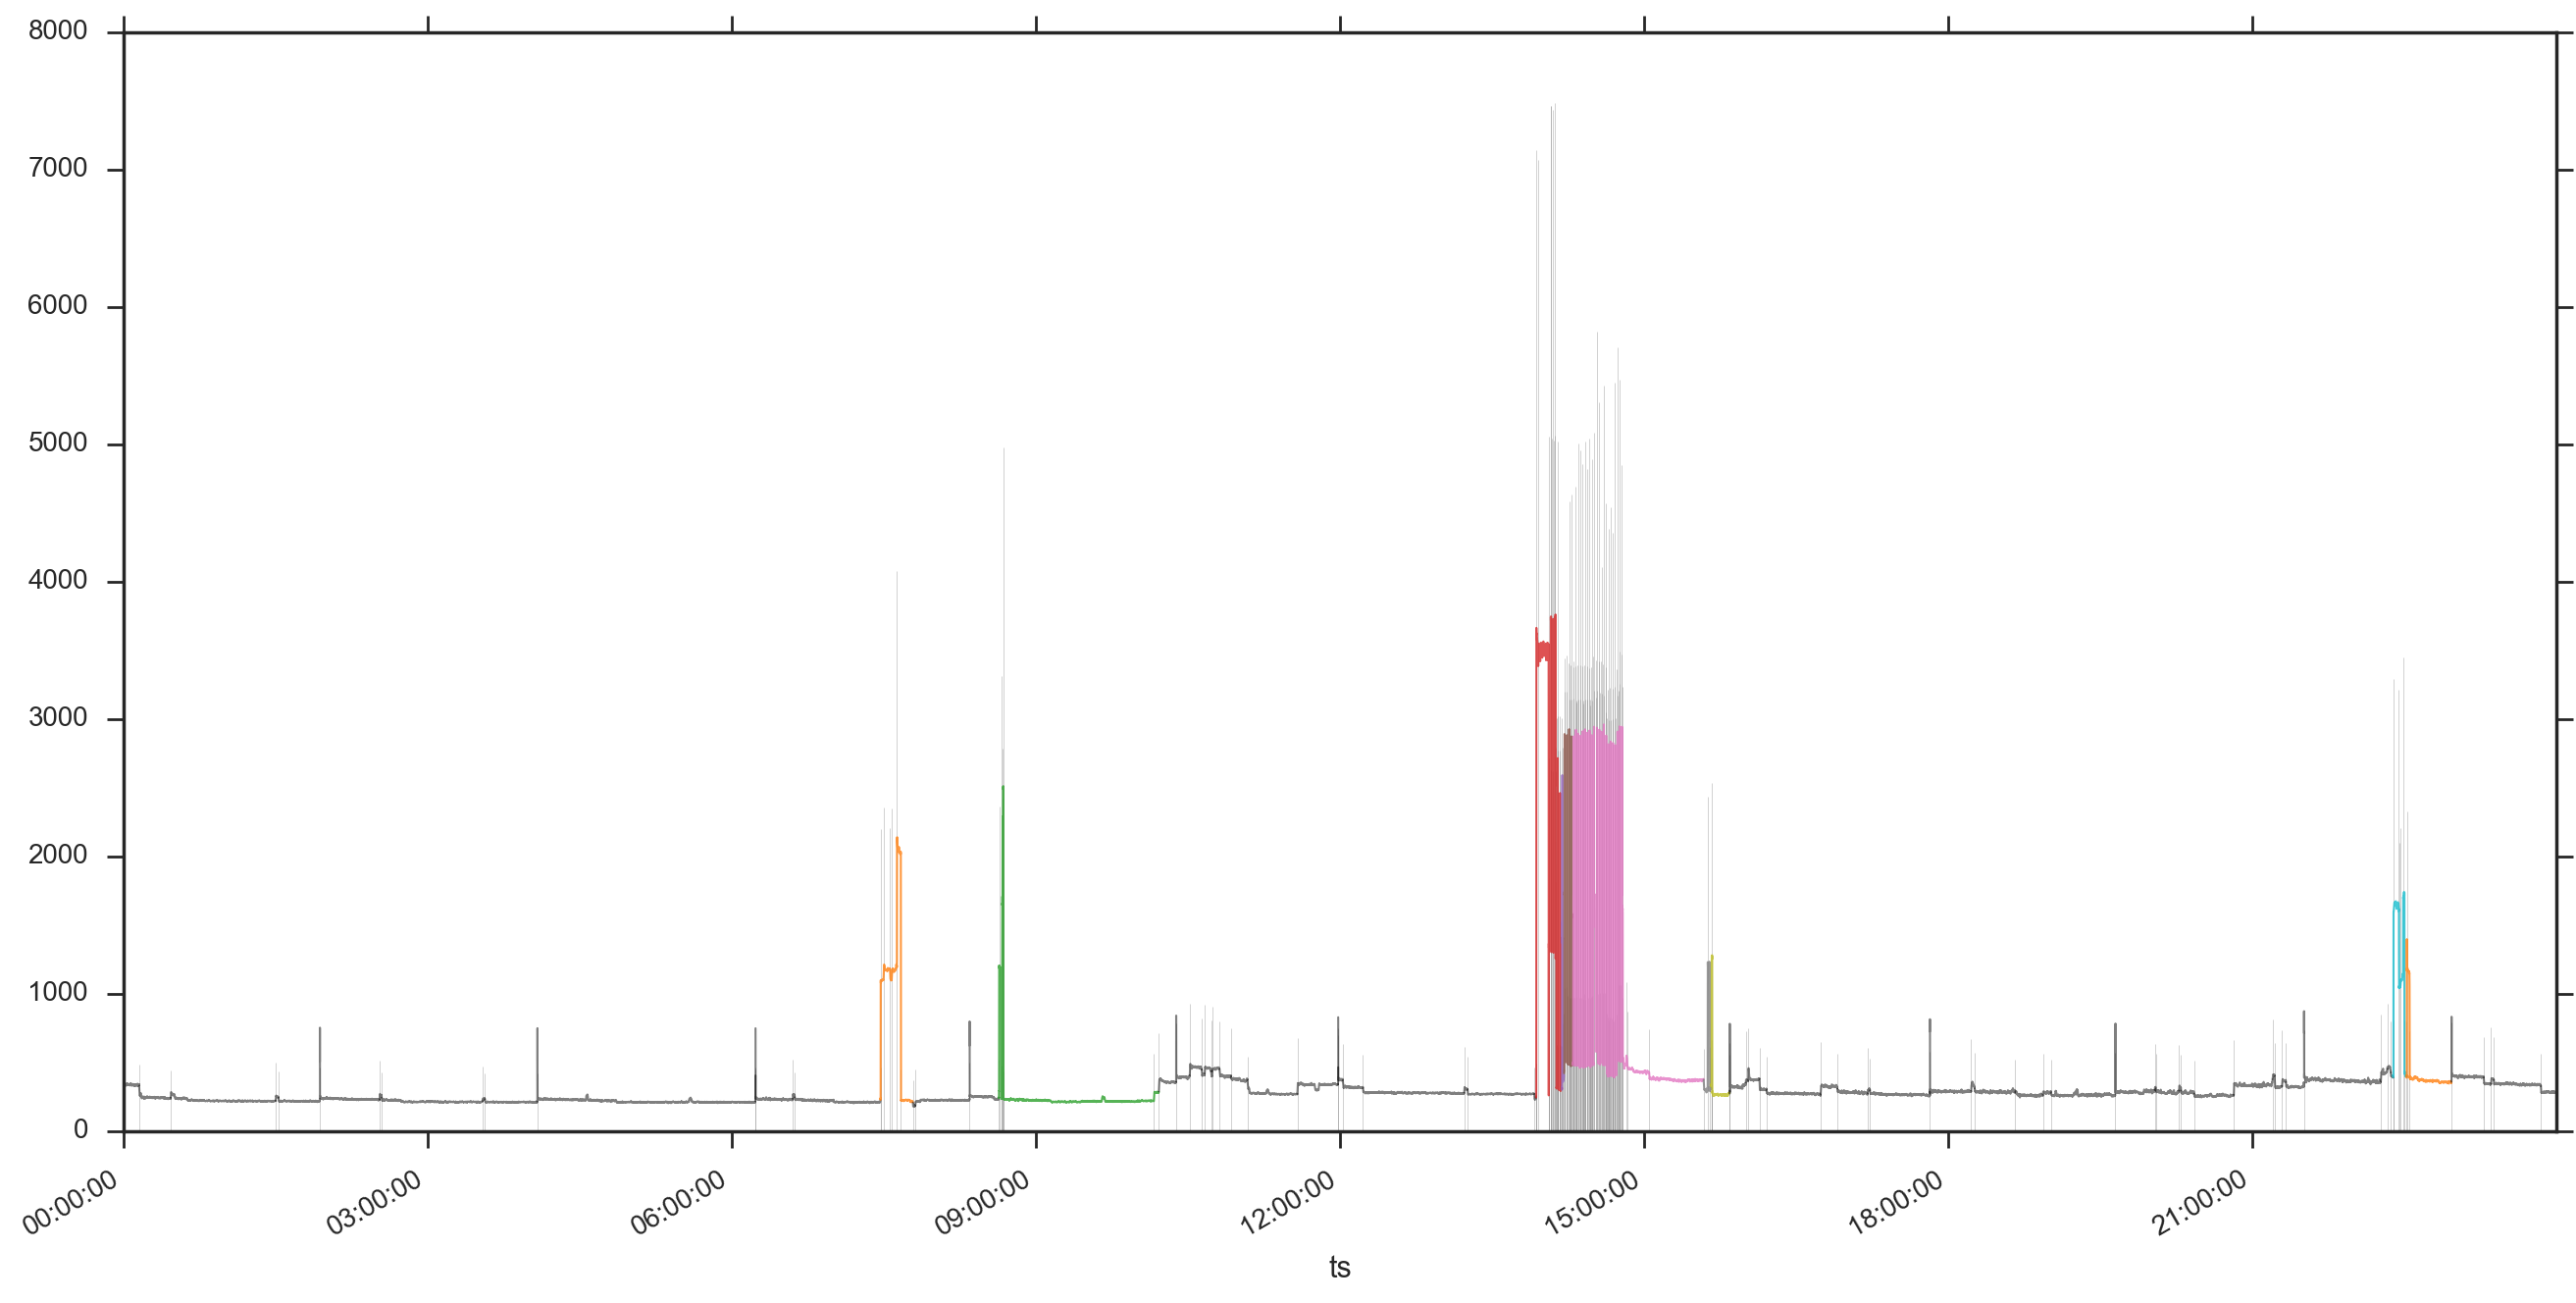

In [6]:
def _plot_intervals(df_out):
    dp = df_out.reset_index().set_index('intervalo')
    f, ax = plt.subplots(1, 1, figsize=(16, 8))
    for i in set(dp.index):
        df_i = dp.loc[i].set_index('ts')
        if not df_i.empty:
            is_big = dp.loc[i, 'big_event'].sum() > 0
            color = next(cm) if is_big else 'k'
            alpha = .8 if is_big else .5
            legend = 'Ev_{}'.format(i) if is_big else ''
            ax.vlines(df_i[df_i.is_init].index, 0, df_i[df_i.is_init].step_median * 2, lw=.25, alpha=.5, color='grey')
            df_i.wiener.plot(ax=ax, lw=.75, alpha=alpha, color=color, label=legend)
    return ax


_plot_intervals(df_out) # .between_time('13:00', '15:59')

['n', 'n_planos', 'mean_t', 'std_t', 'mean_planos', 'std_planos', 'mean_final', 'std_final', 'mean_u', 'std_u', 'pnorm', 'pnorm_next', 'error_cum']
incr, hay_incr_considerar, hay_ch_abs, next_dif_mean_supera_std, es_outlier, es_outlier_safe, next_es_outlier, next_es_outlier_safe, hay_cambio_futuro
rect_smoothing TOOK: 0.991 s
[[0], [2, 3, 4, 5], [8], [10, 11, 12, 13, 14, 15, 16]]
fusion_big_events TOOK: 0.060 s
integrate_step_detection TOOK: 0.077 s
['n', 'n_planos', 'mean_t', 'std_t', 'mean_planos', 'std_planos', 'mean_final', 'std_final', 'mean_u', 'std_u', 'pnorm', 'pnorm_next', 'error_cum']
incr, hay_incr_considerar, hay_ch_abs, next_dif_mean_supera_std, es_outlier, es_outlier_safe, next_es_outlier, next_es_outlier_safe, hay_cambio_futuro
rect_smoothing TOOK: 1.964 s
[[0]]
fusion_big_events TOOK: 0.005 s
integrate_step_detection TOOK: 0.014 s
['n', 'n_planos', 'mean_t', 'std_t', 'mean_planos', 'std_planos', 'mean_final', 'std_final', 'mean_u', 'std_u', 'pnorm', 'pnorm_next', 'error

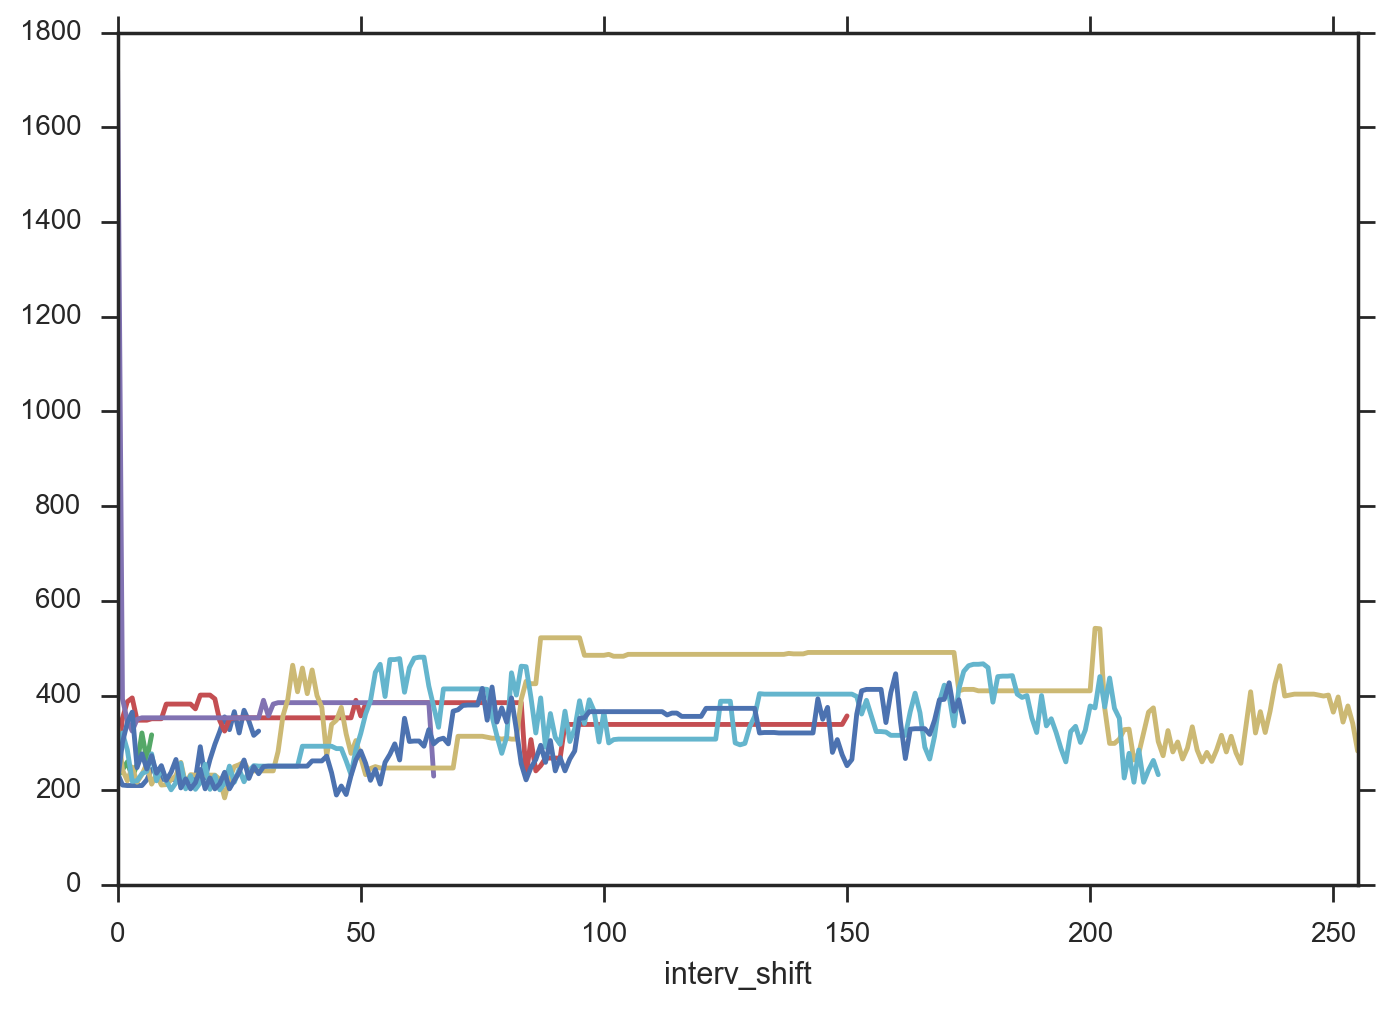

In [7]:
lista_dfs = [df_1, df_2, df_3, df_4, df_5, df_6, df_7]
lista_dfs_out = []
for df in lista_dfs:
    df_step = rect_smoothing(df)
    df_interv = genera_df_intervalos(df, df_step)
    df_out = _integrate_step_detection(df, df_step, df_interv)
    lista_dfs_out.append((df_out, df_step, df_interv))

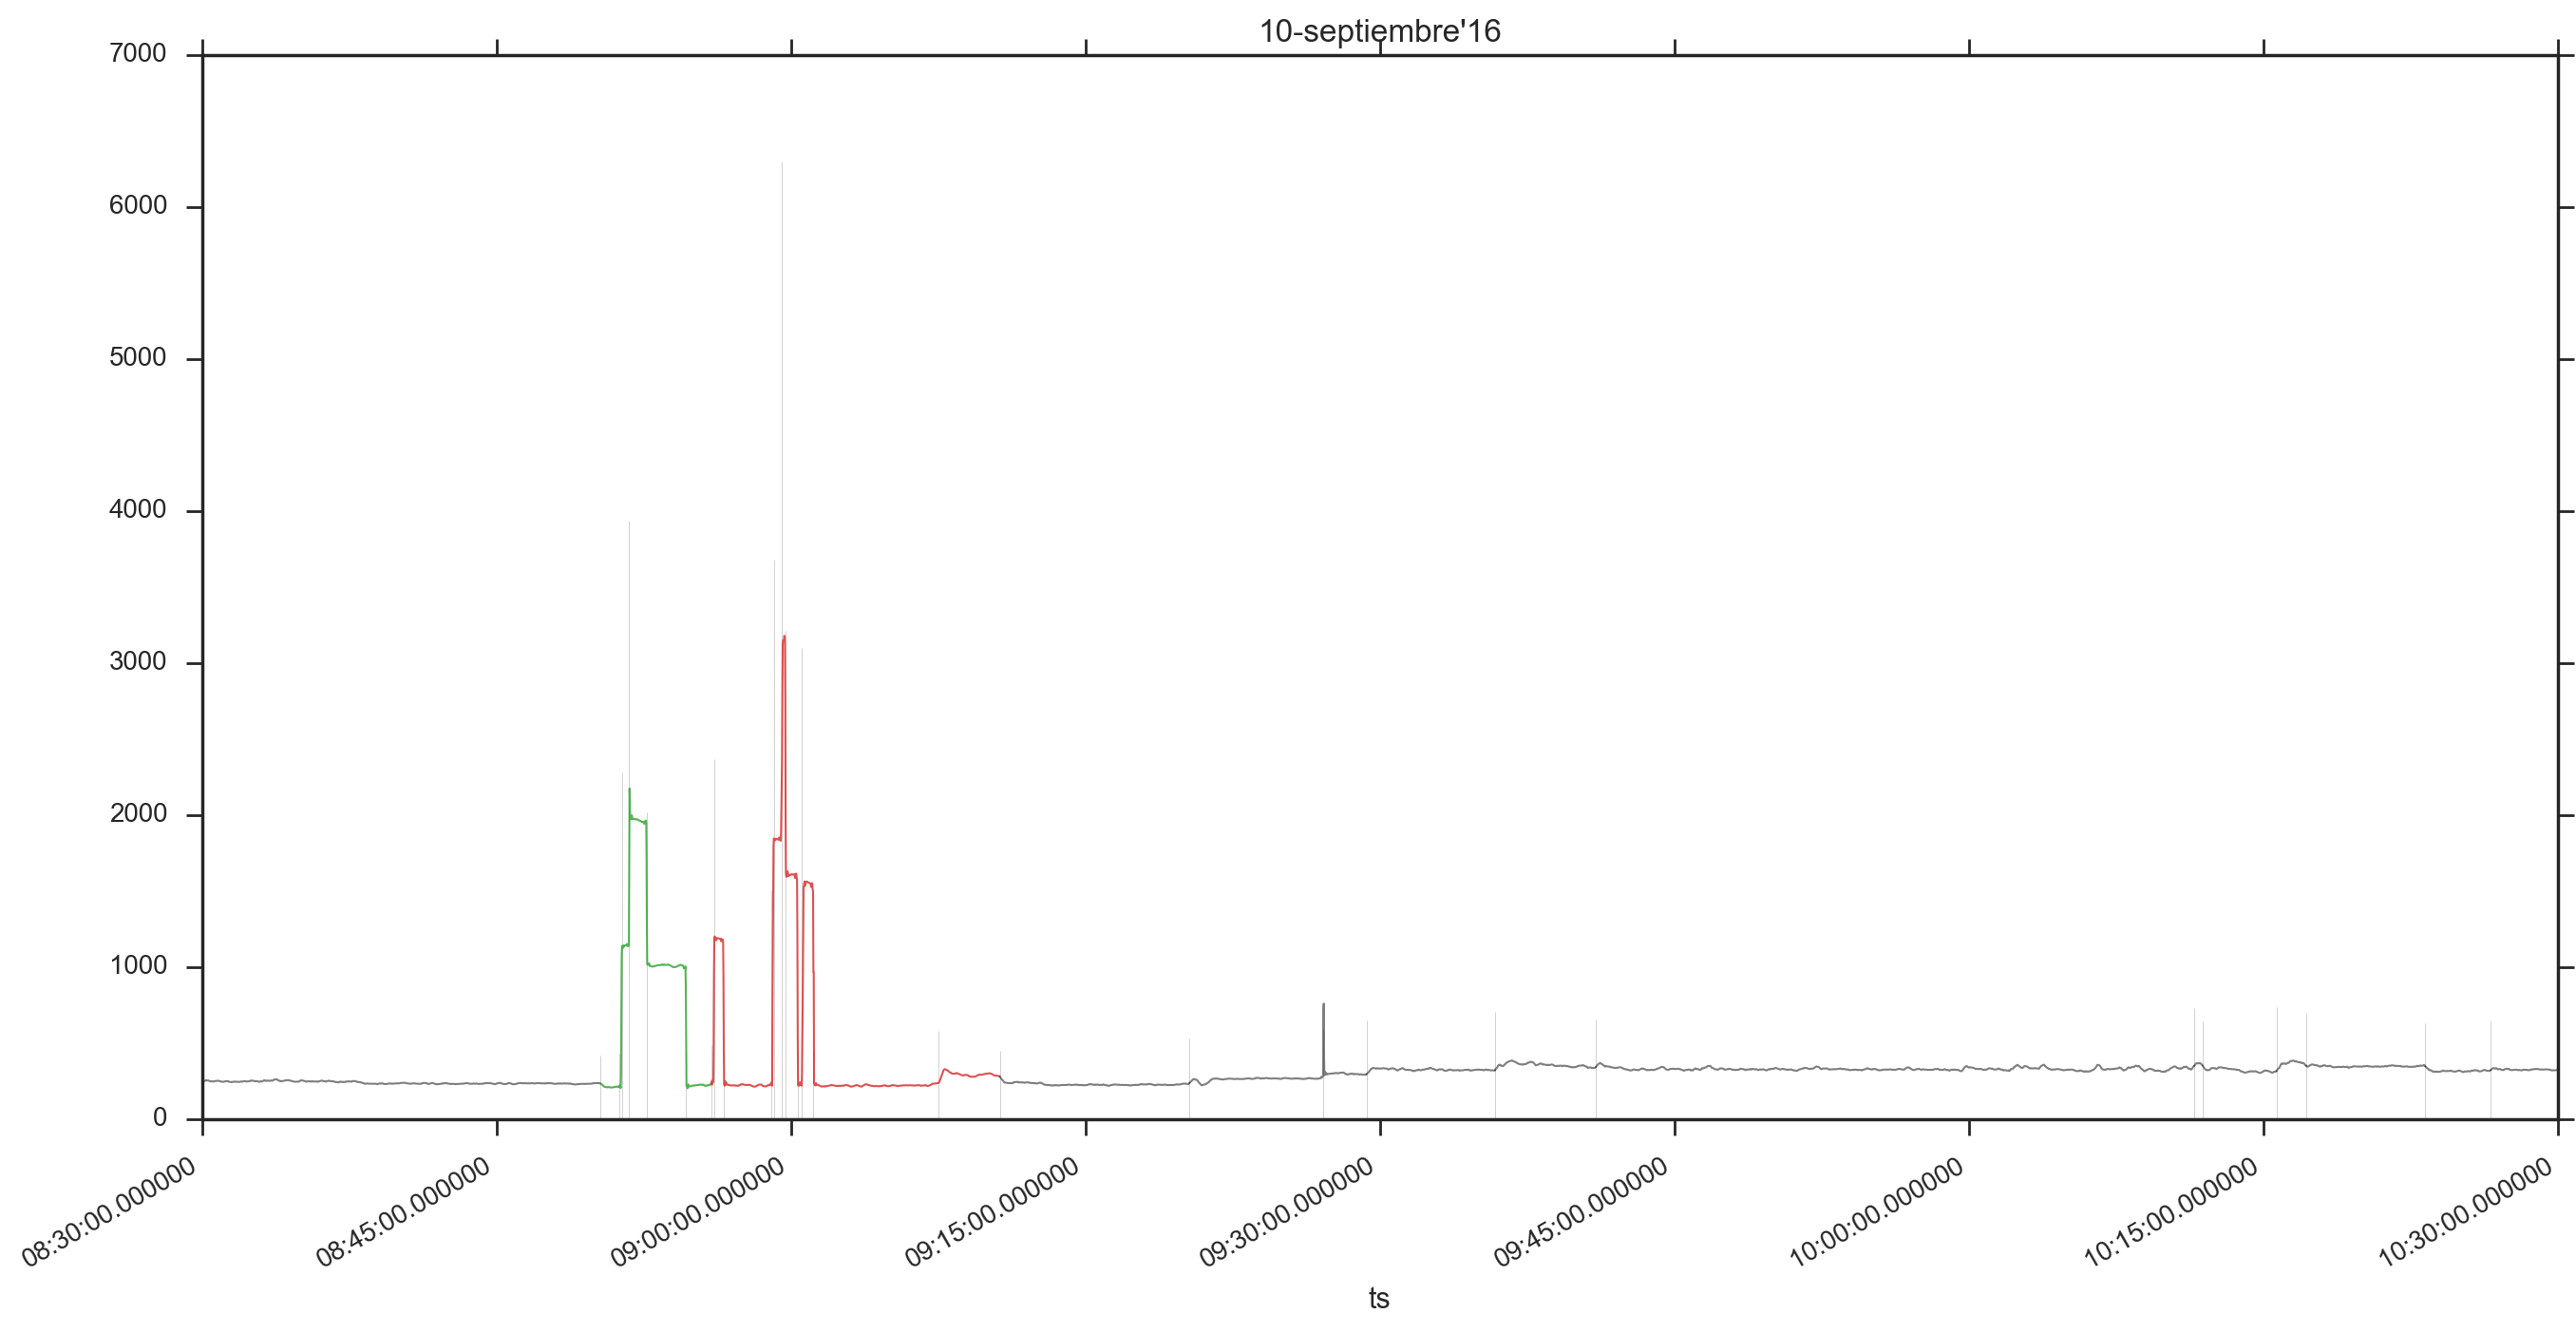

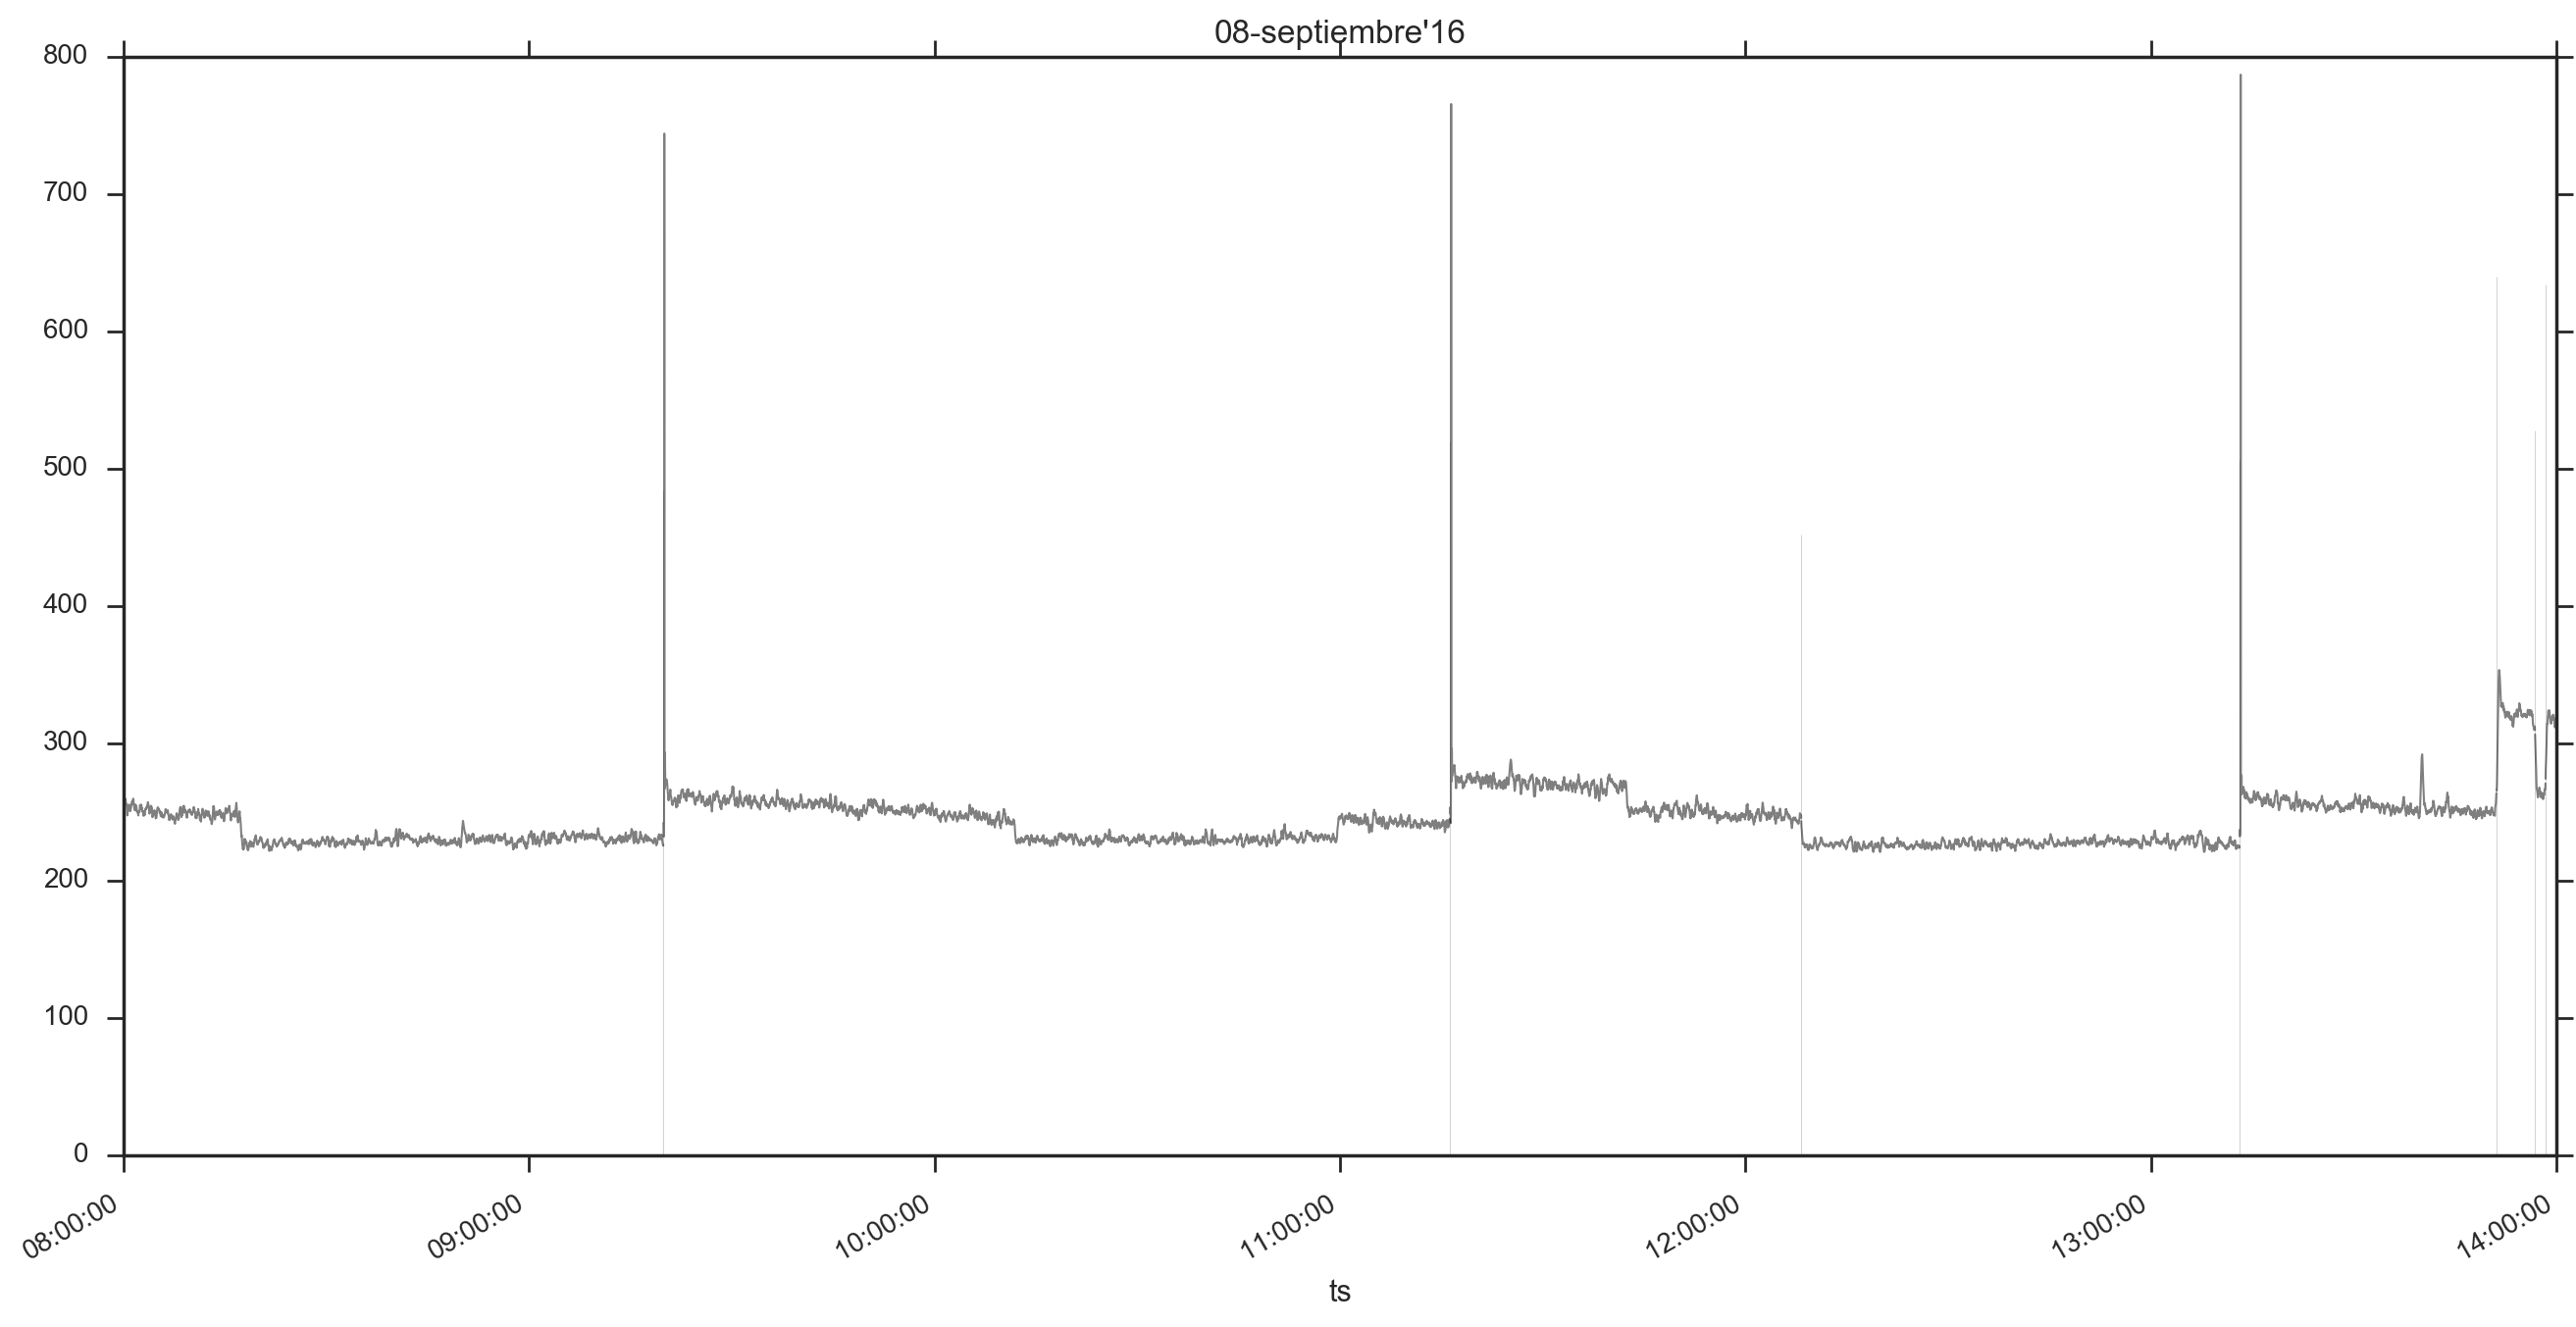

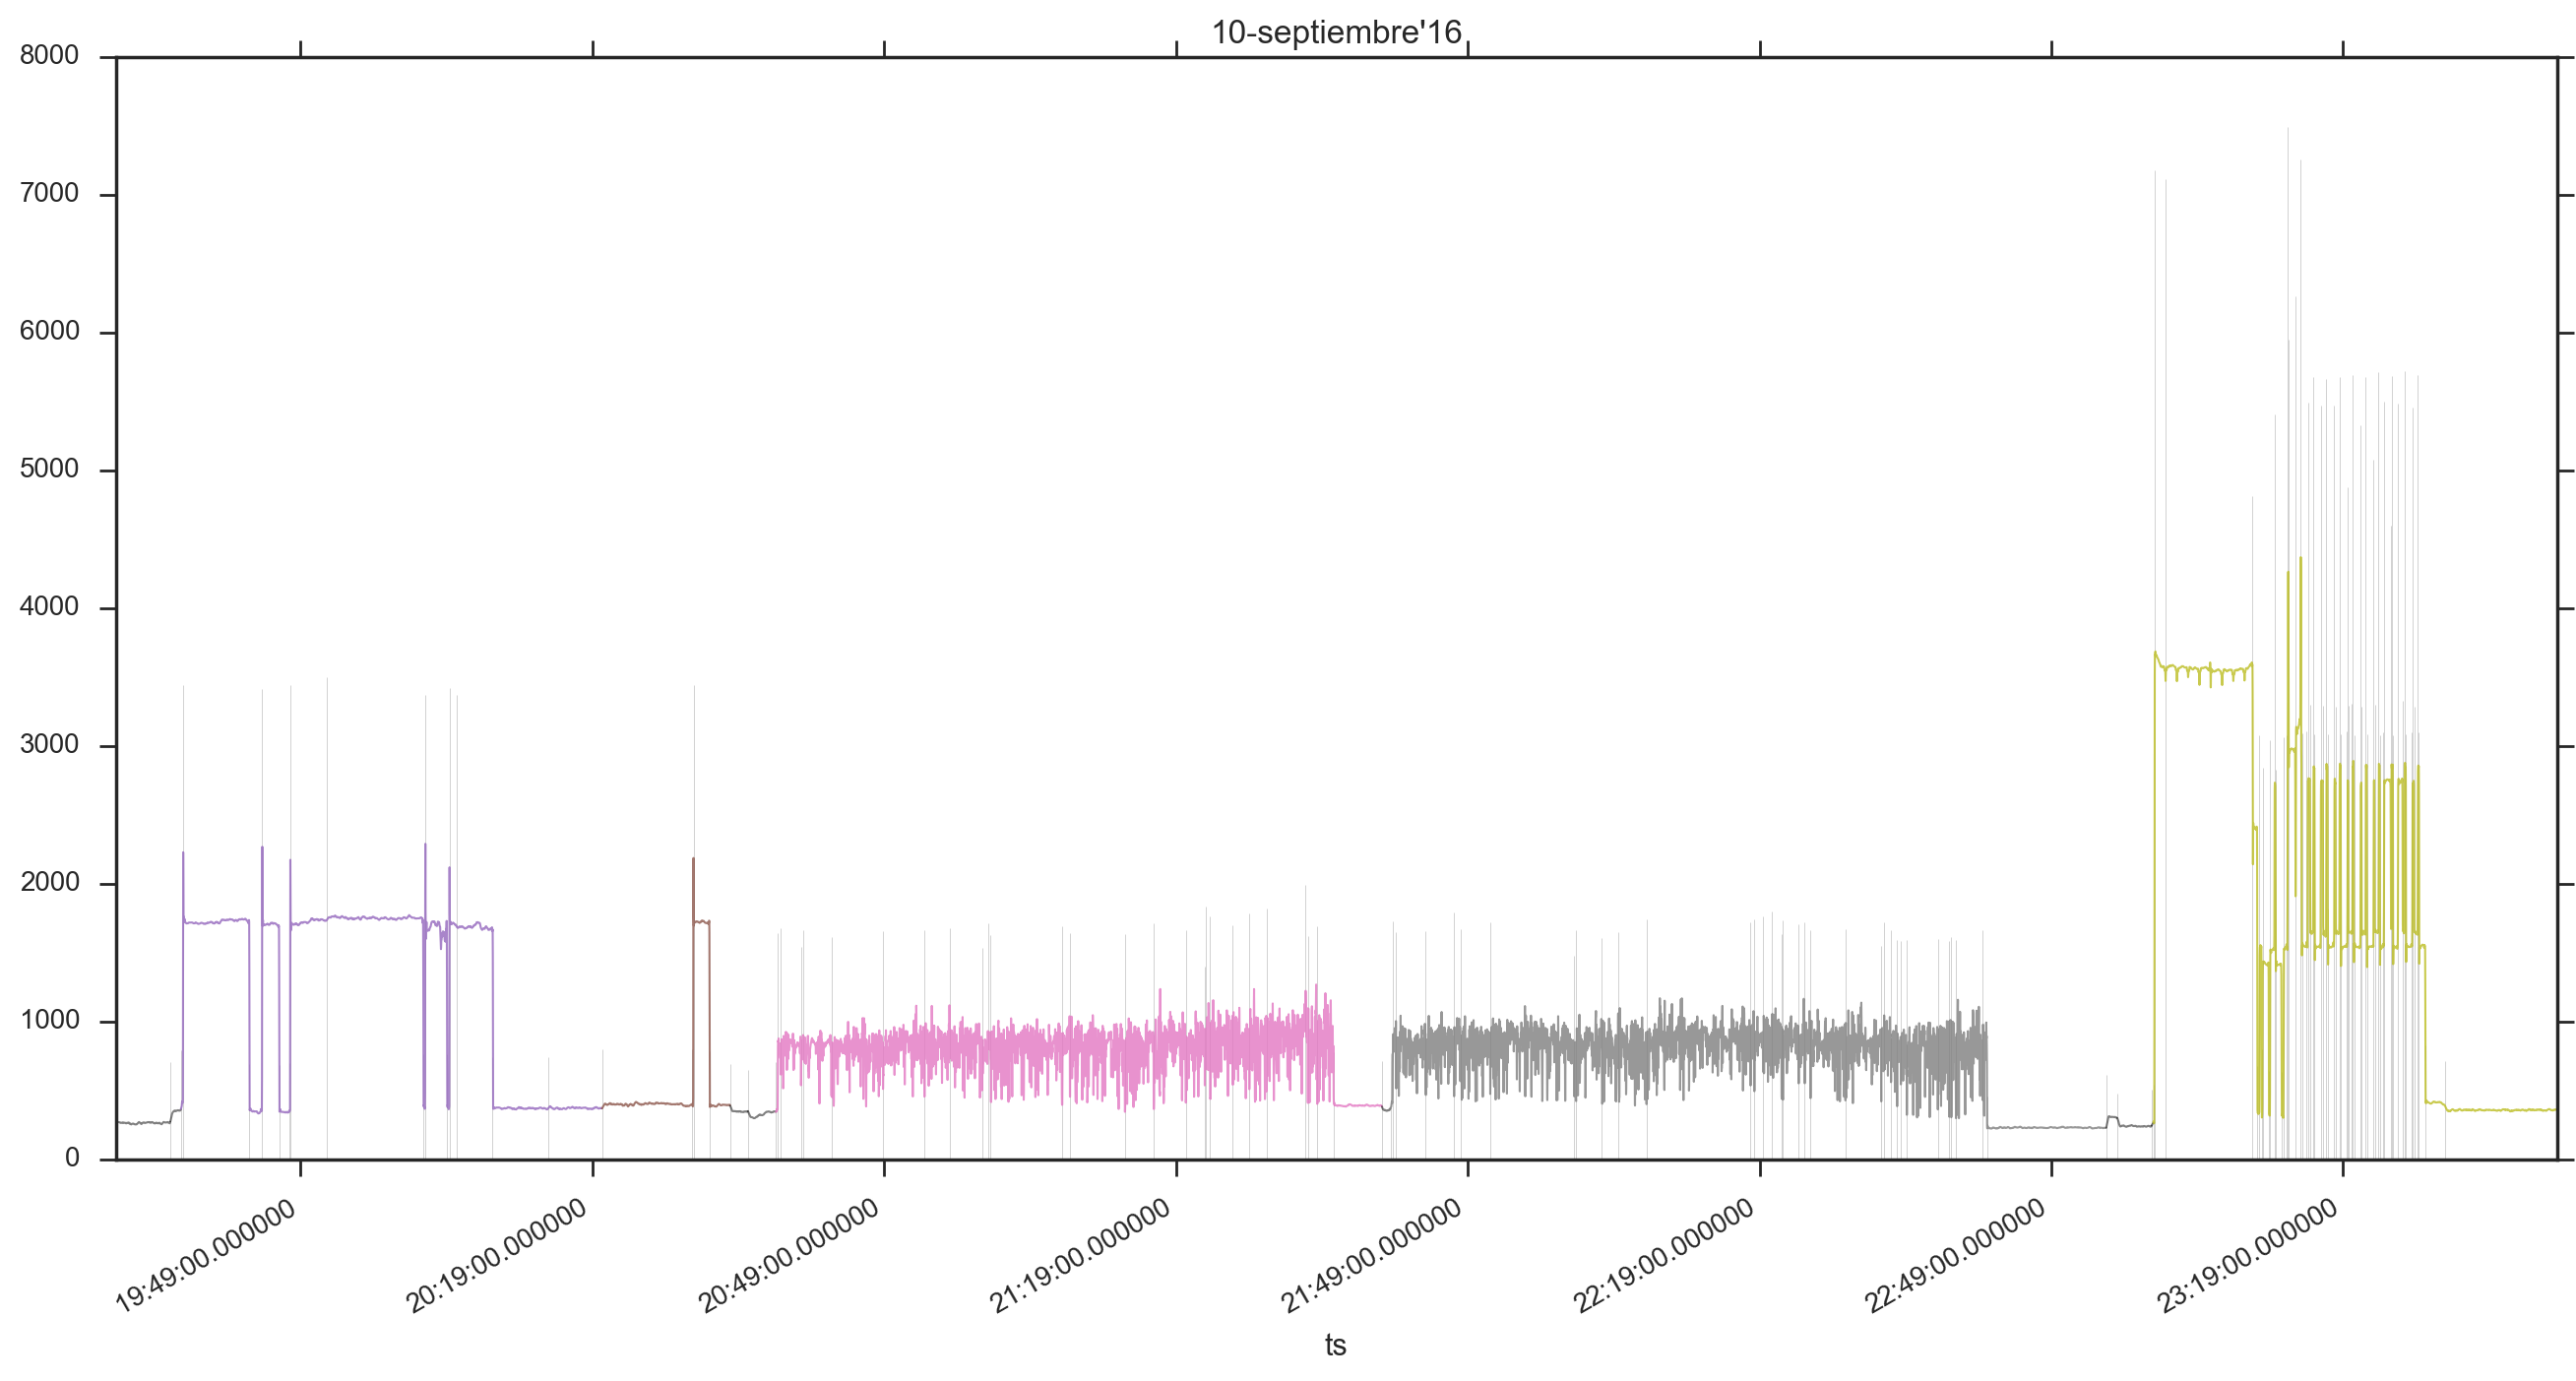

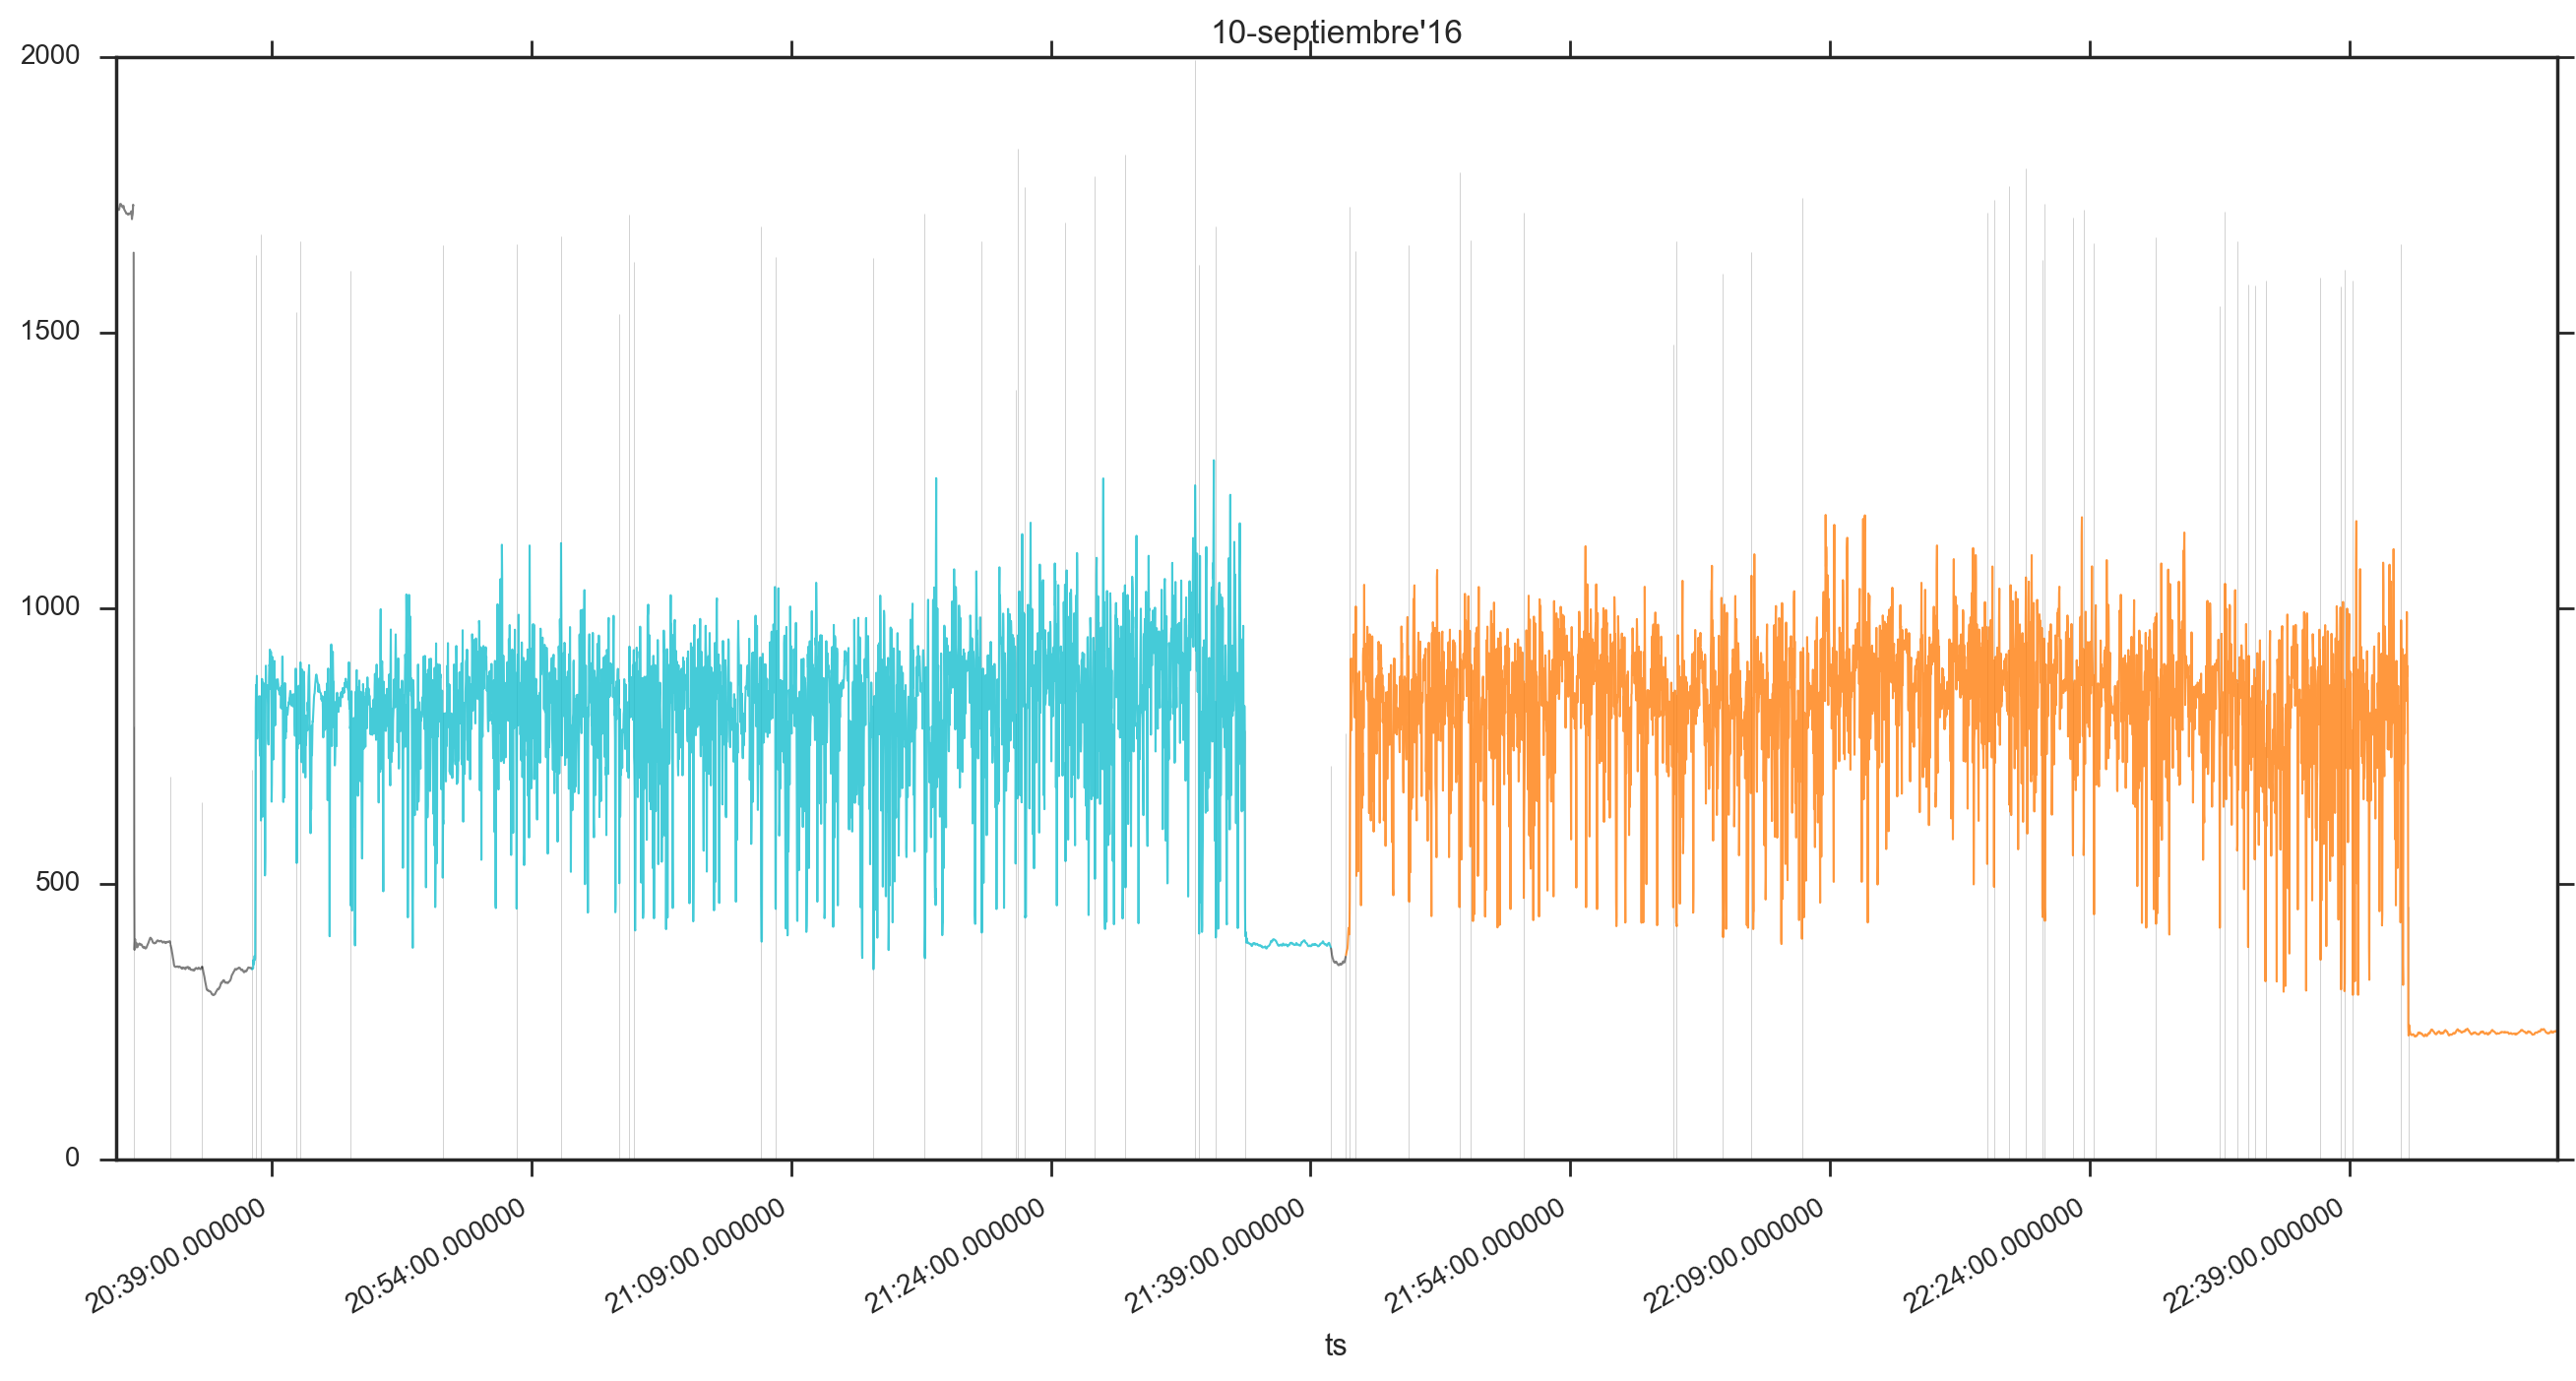

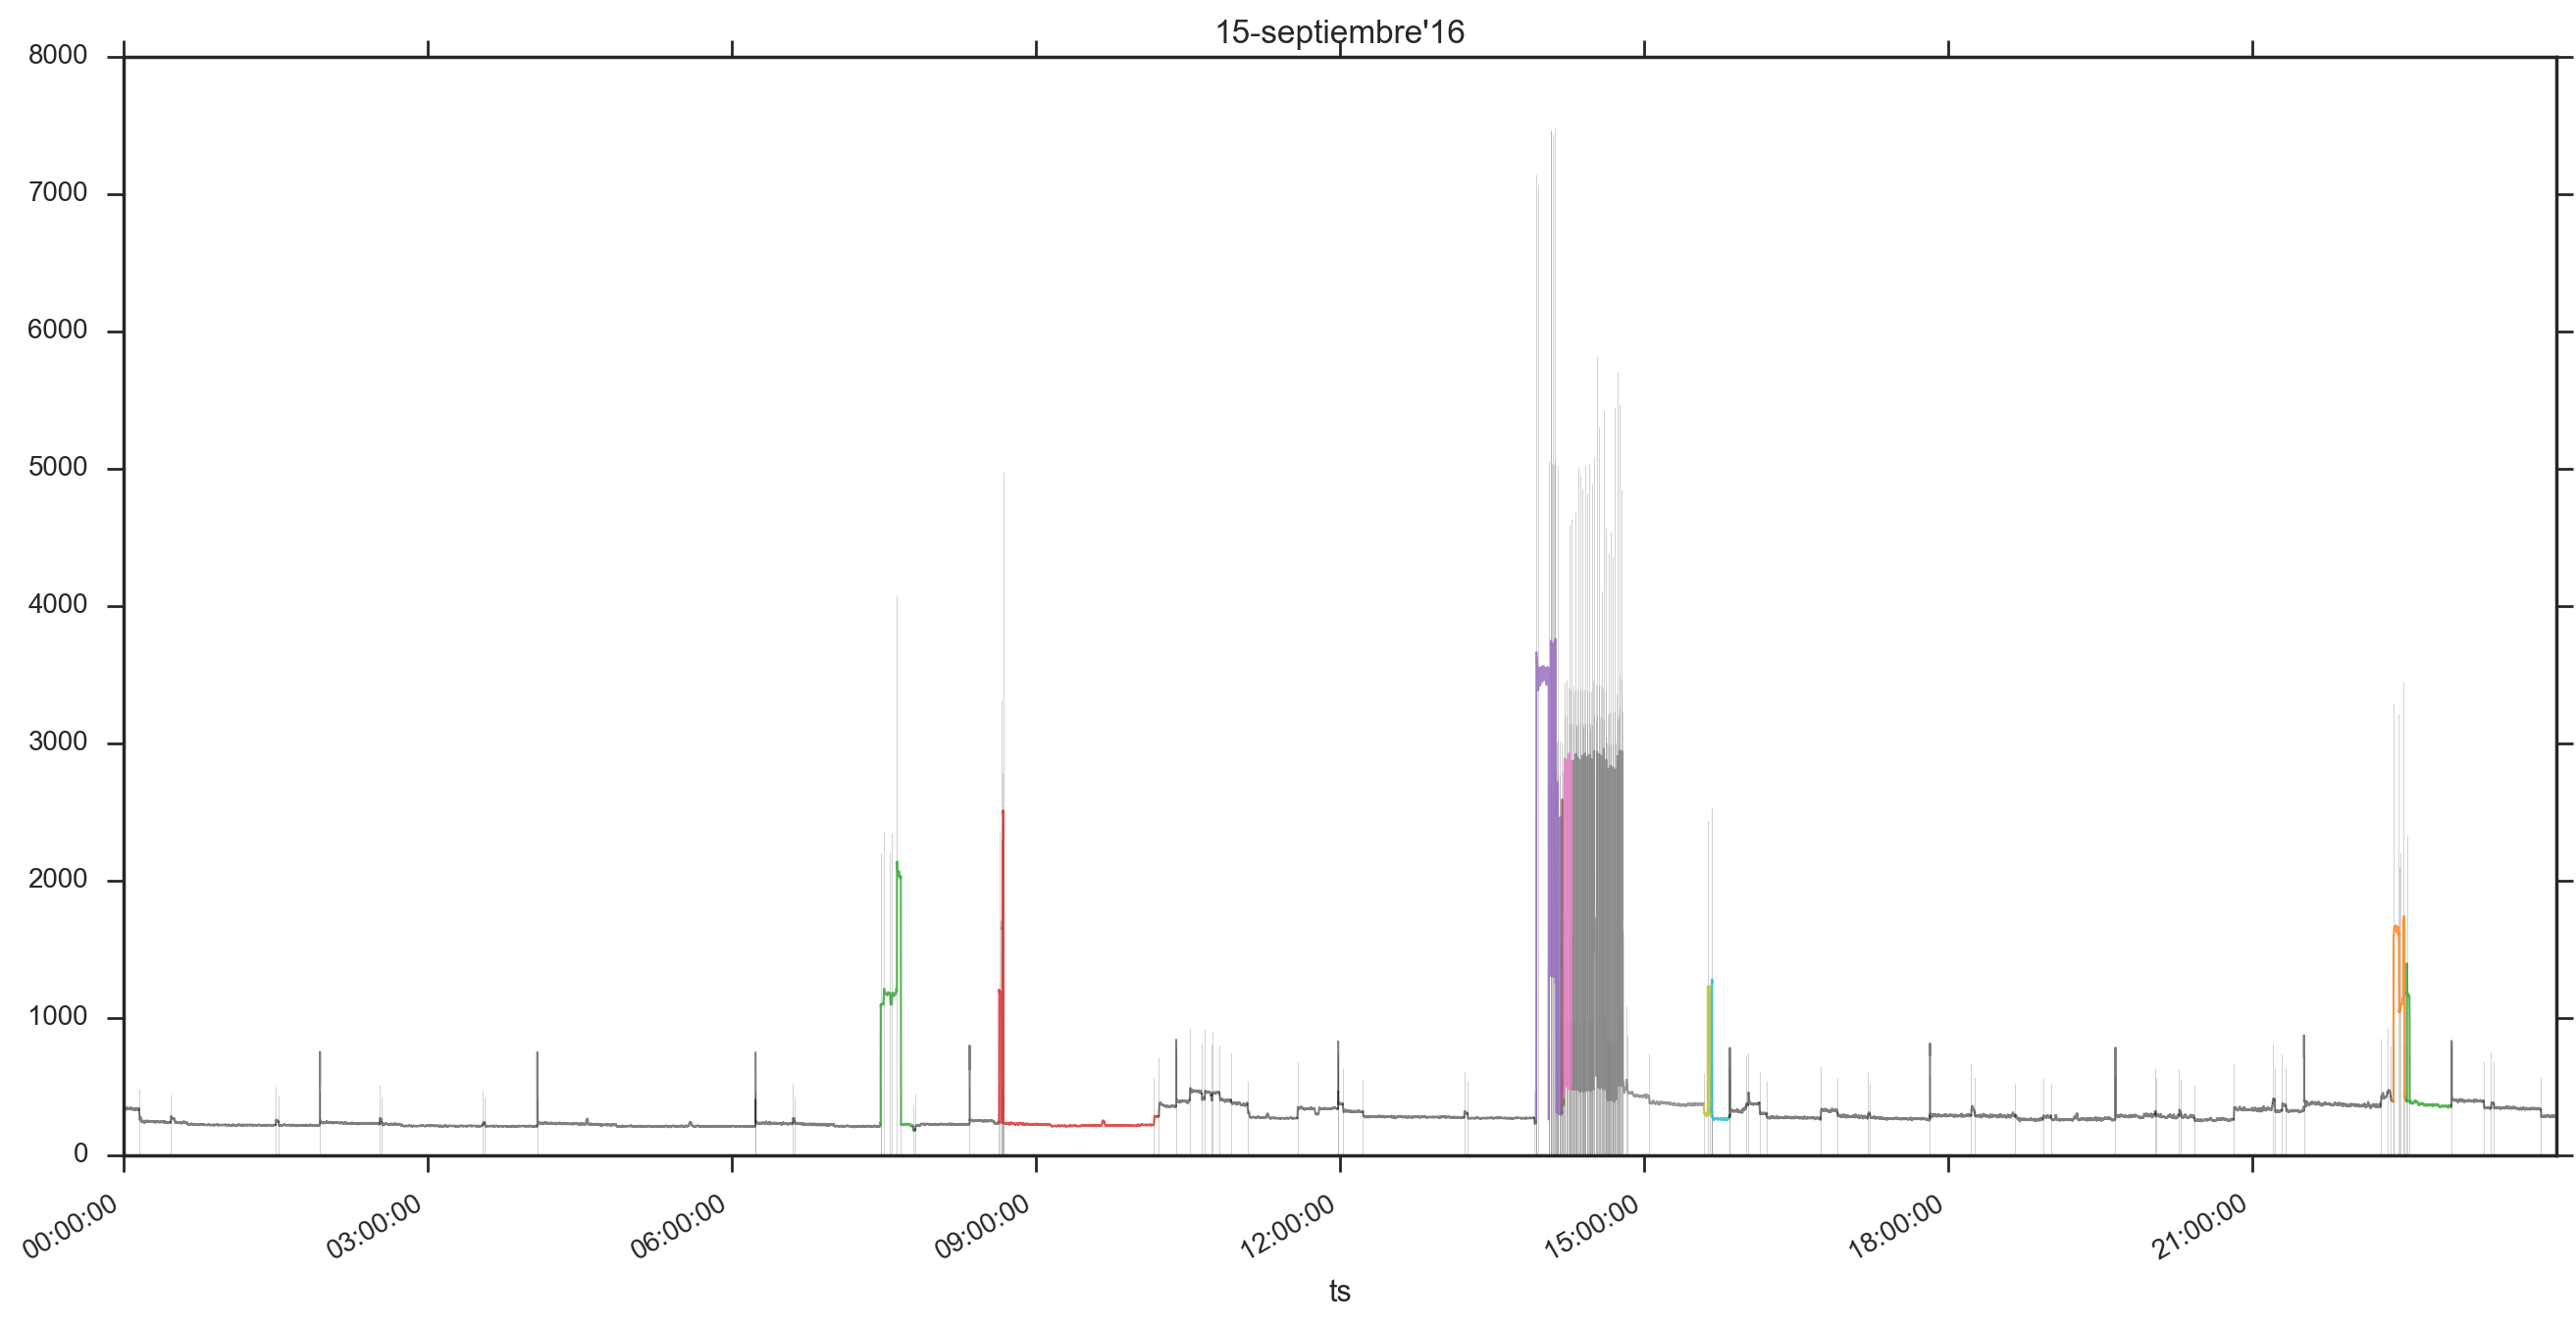

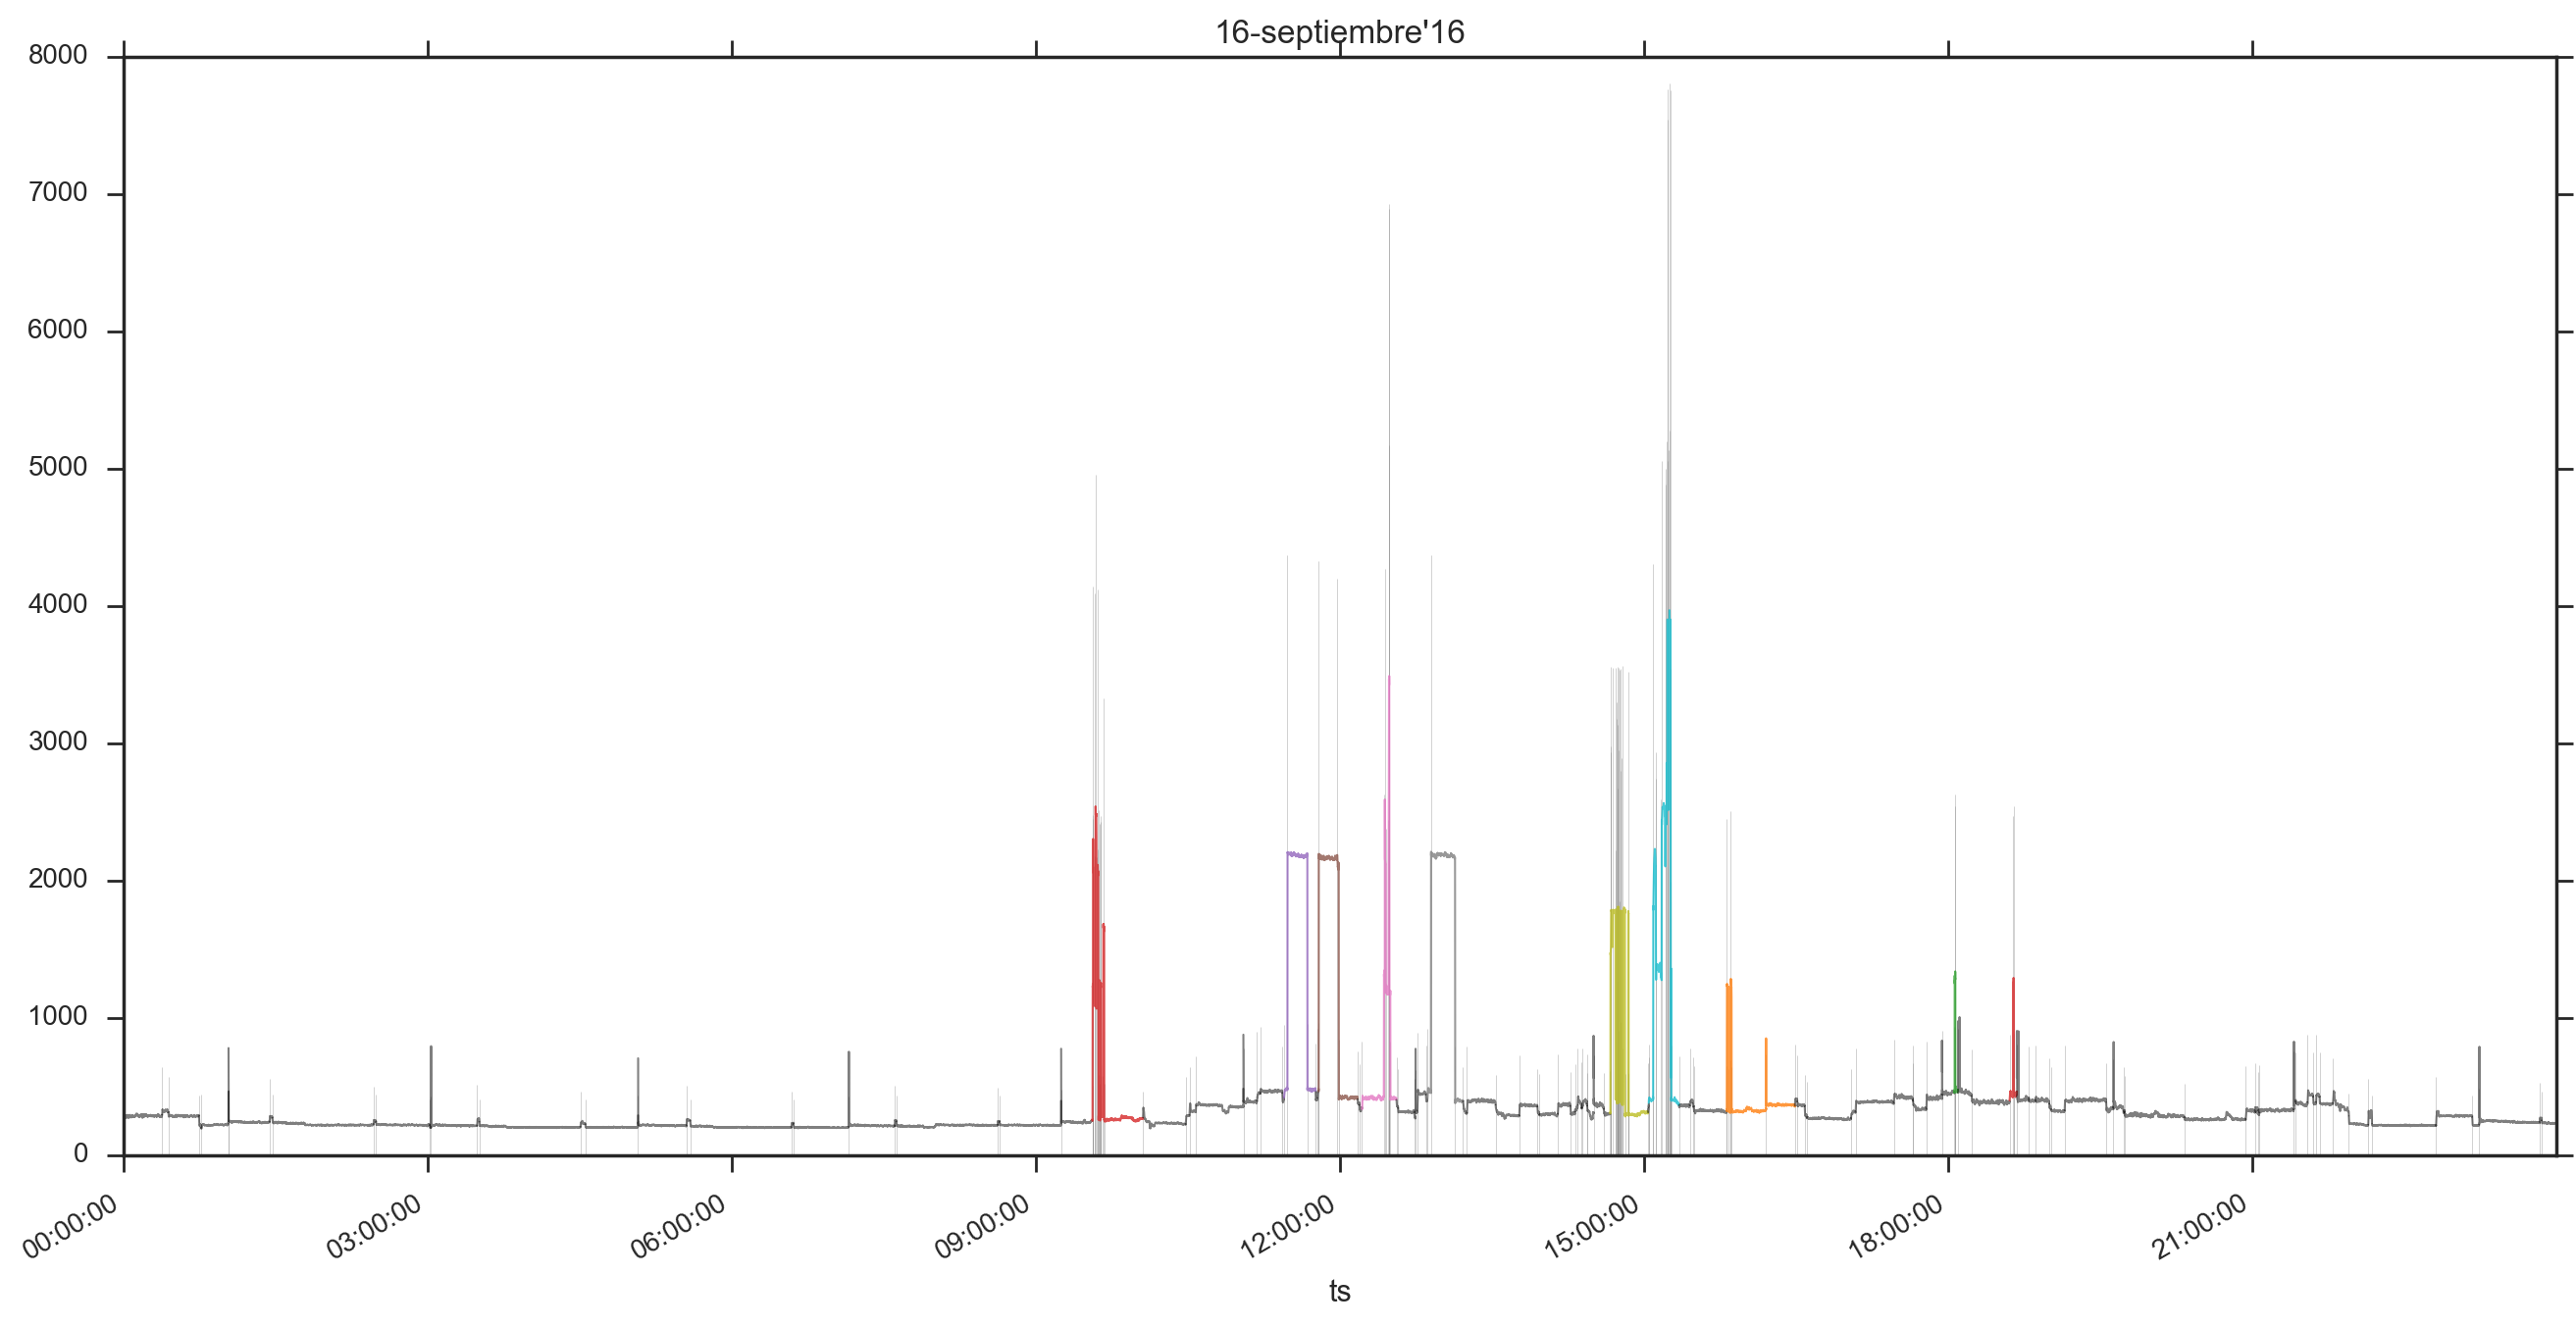

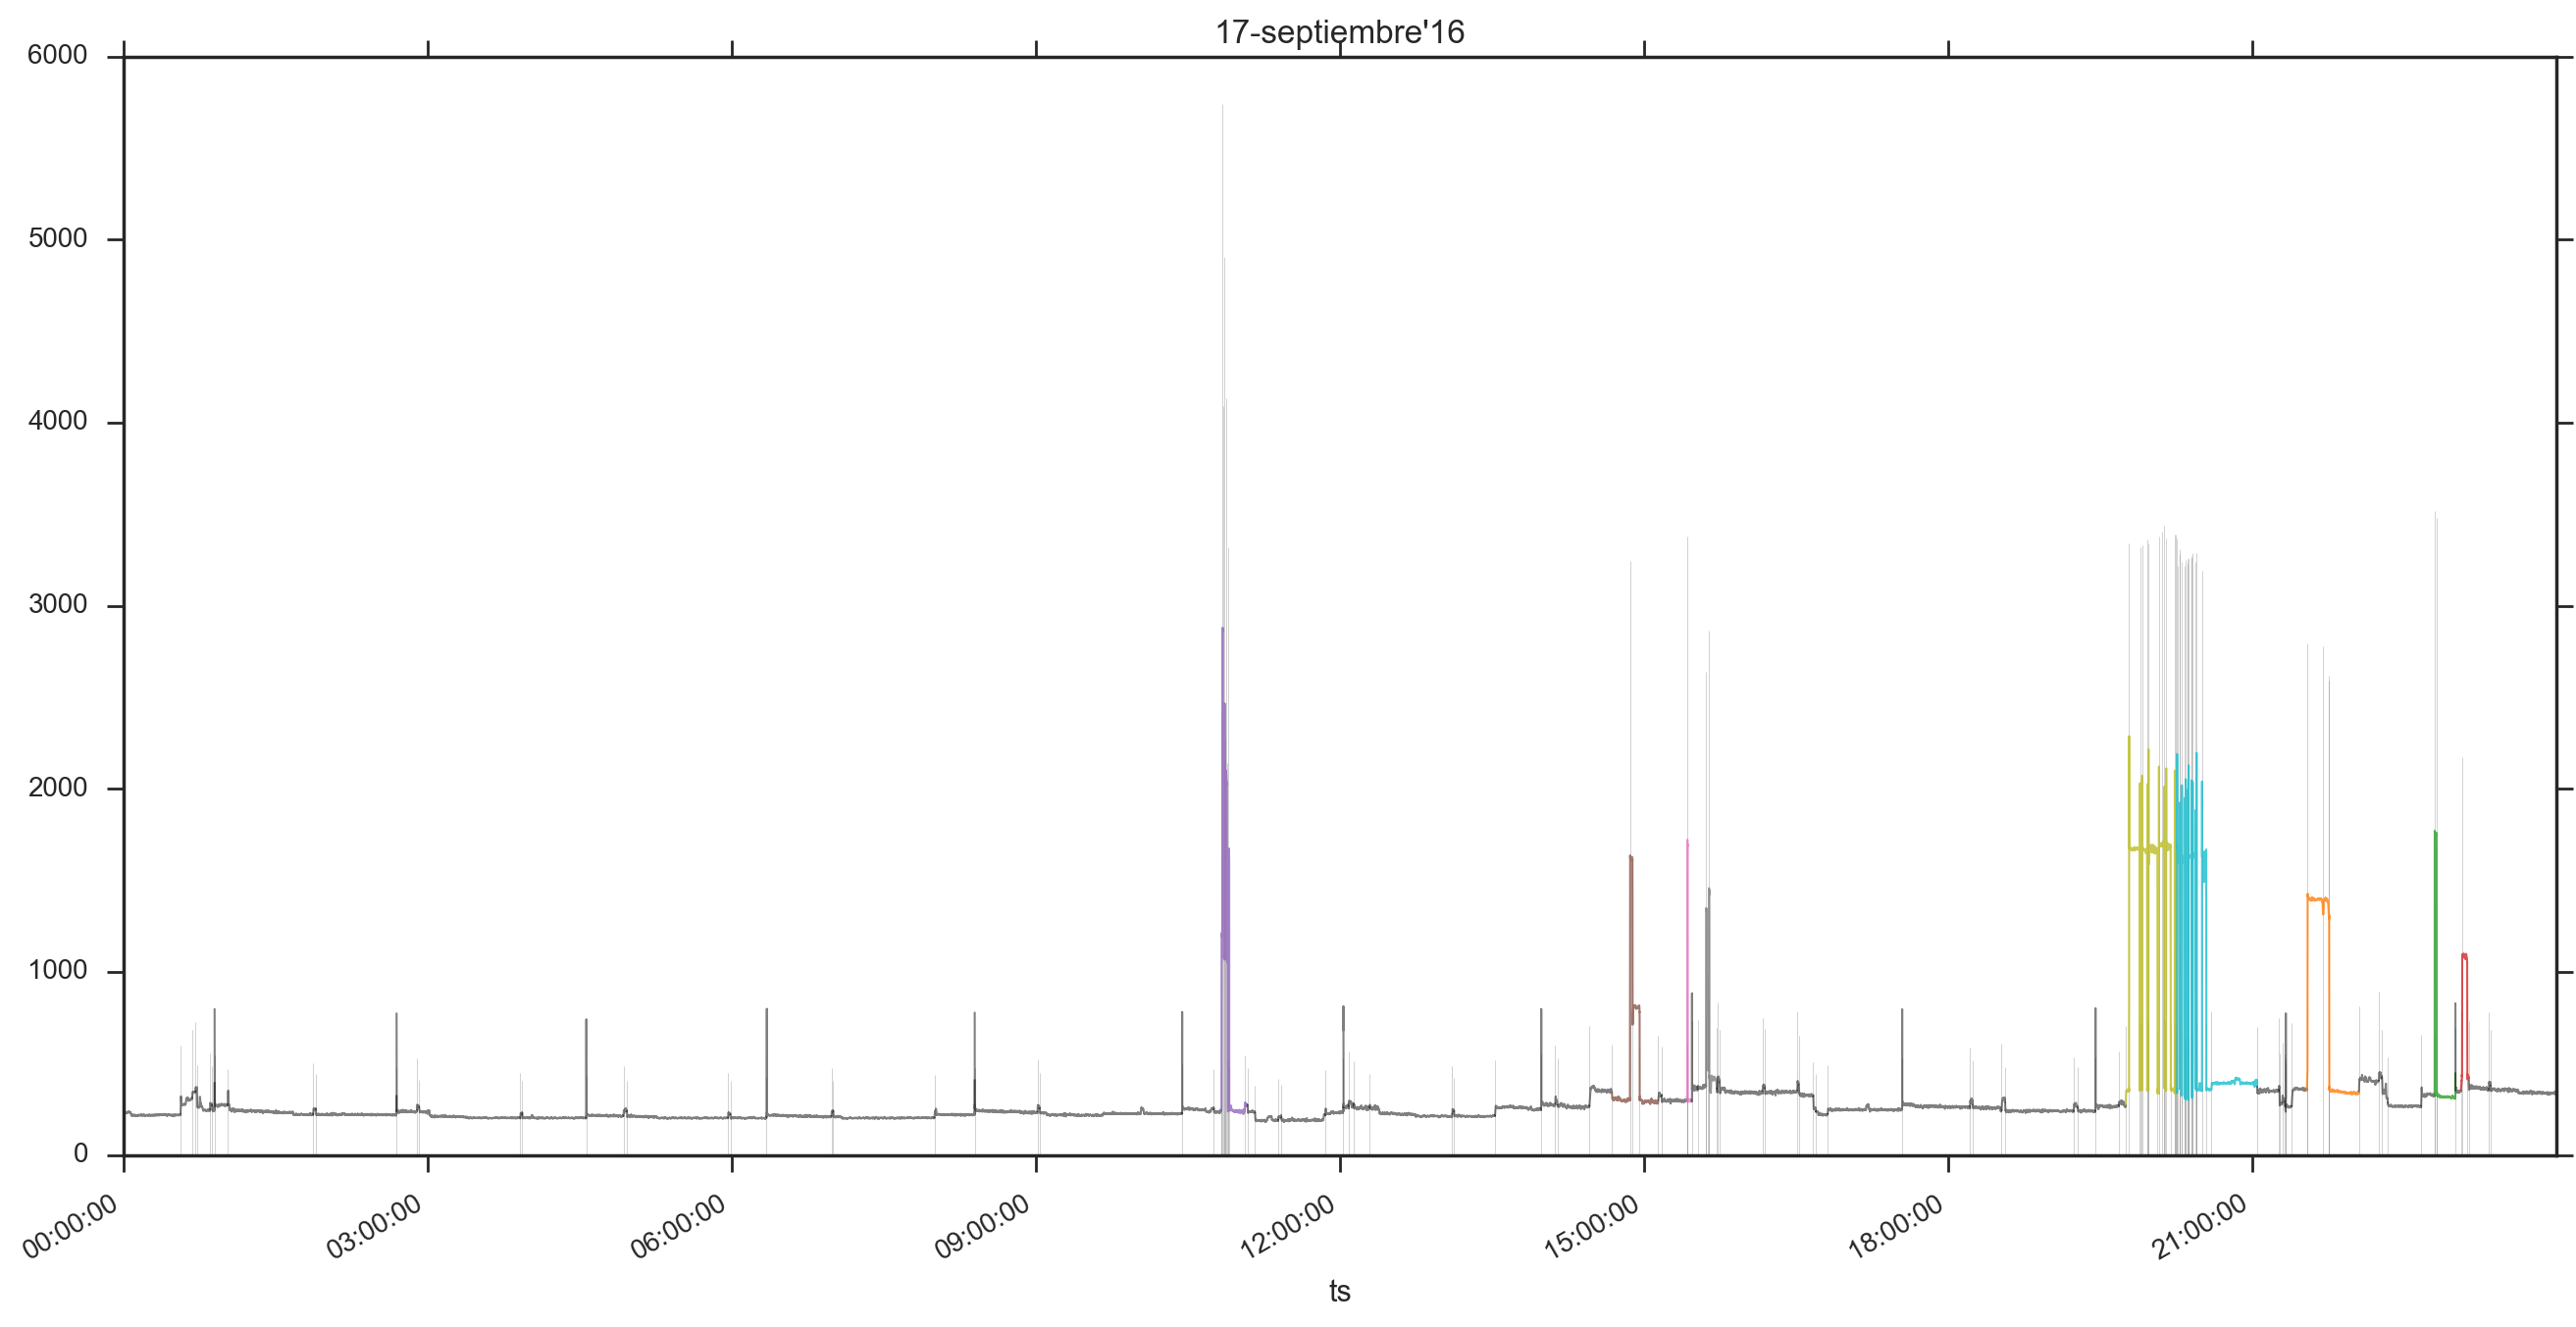

In [9]:
for (df_out, df_step, df_interv) in lista_dfs_out:
    _plot_intervals(df_out)
    plt.title("{:%d-%B'%y}".format(df_out.index[0]))
    plt.show()

(200, 400)

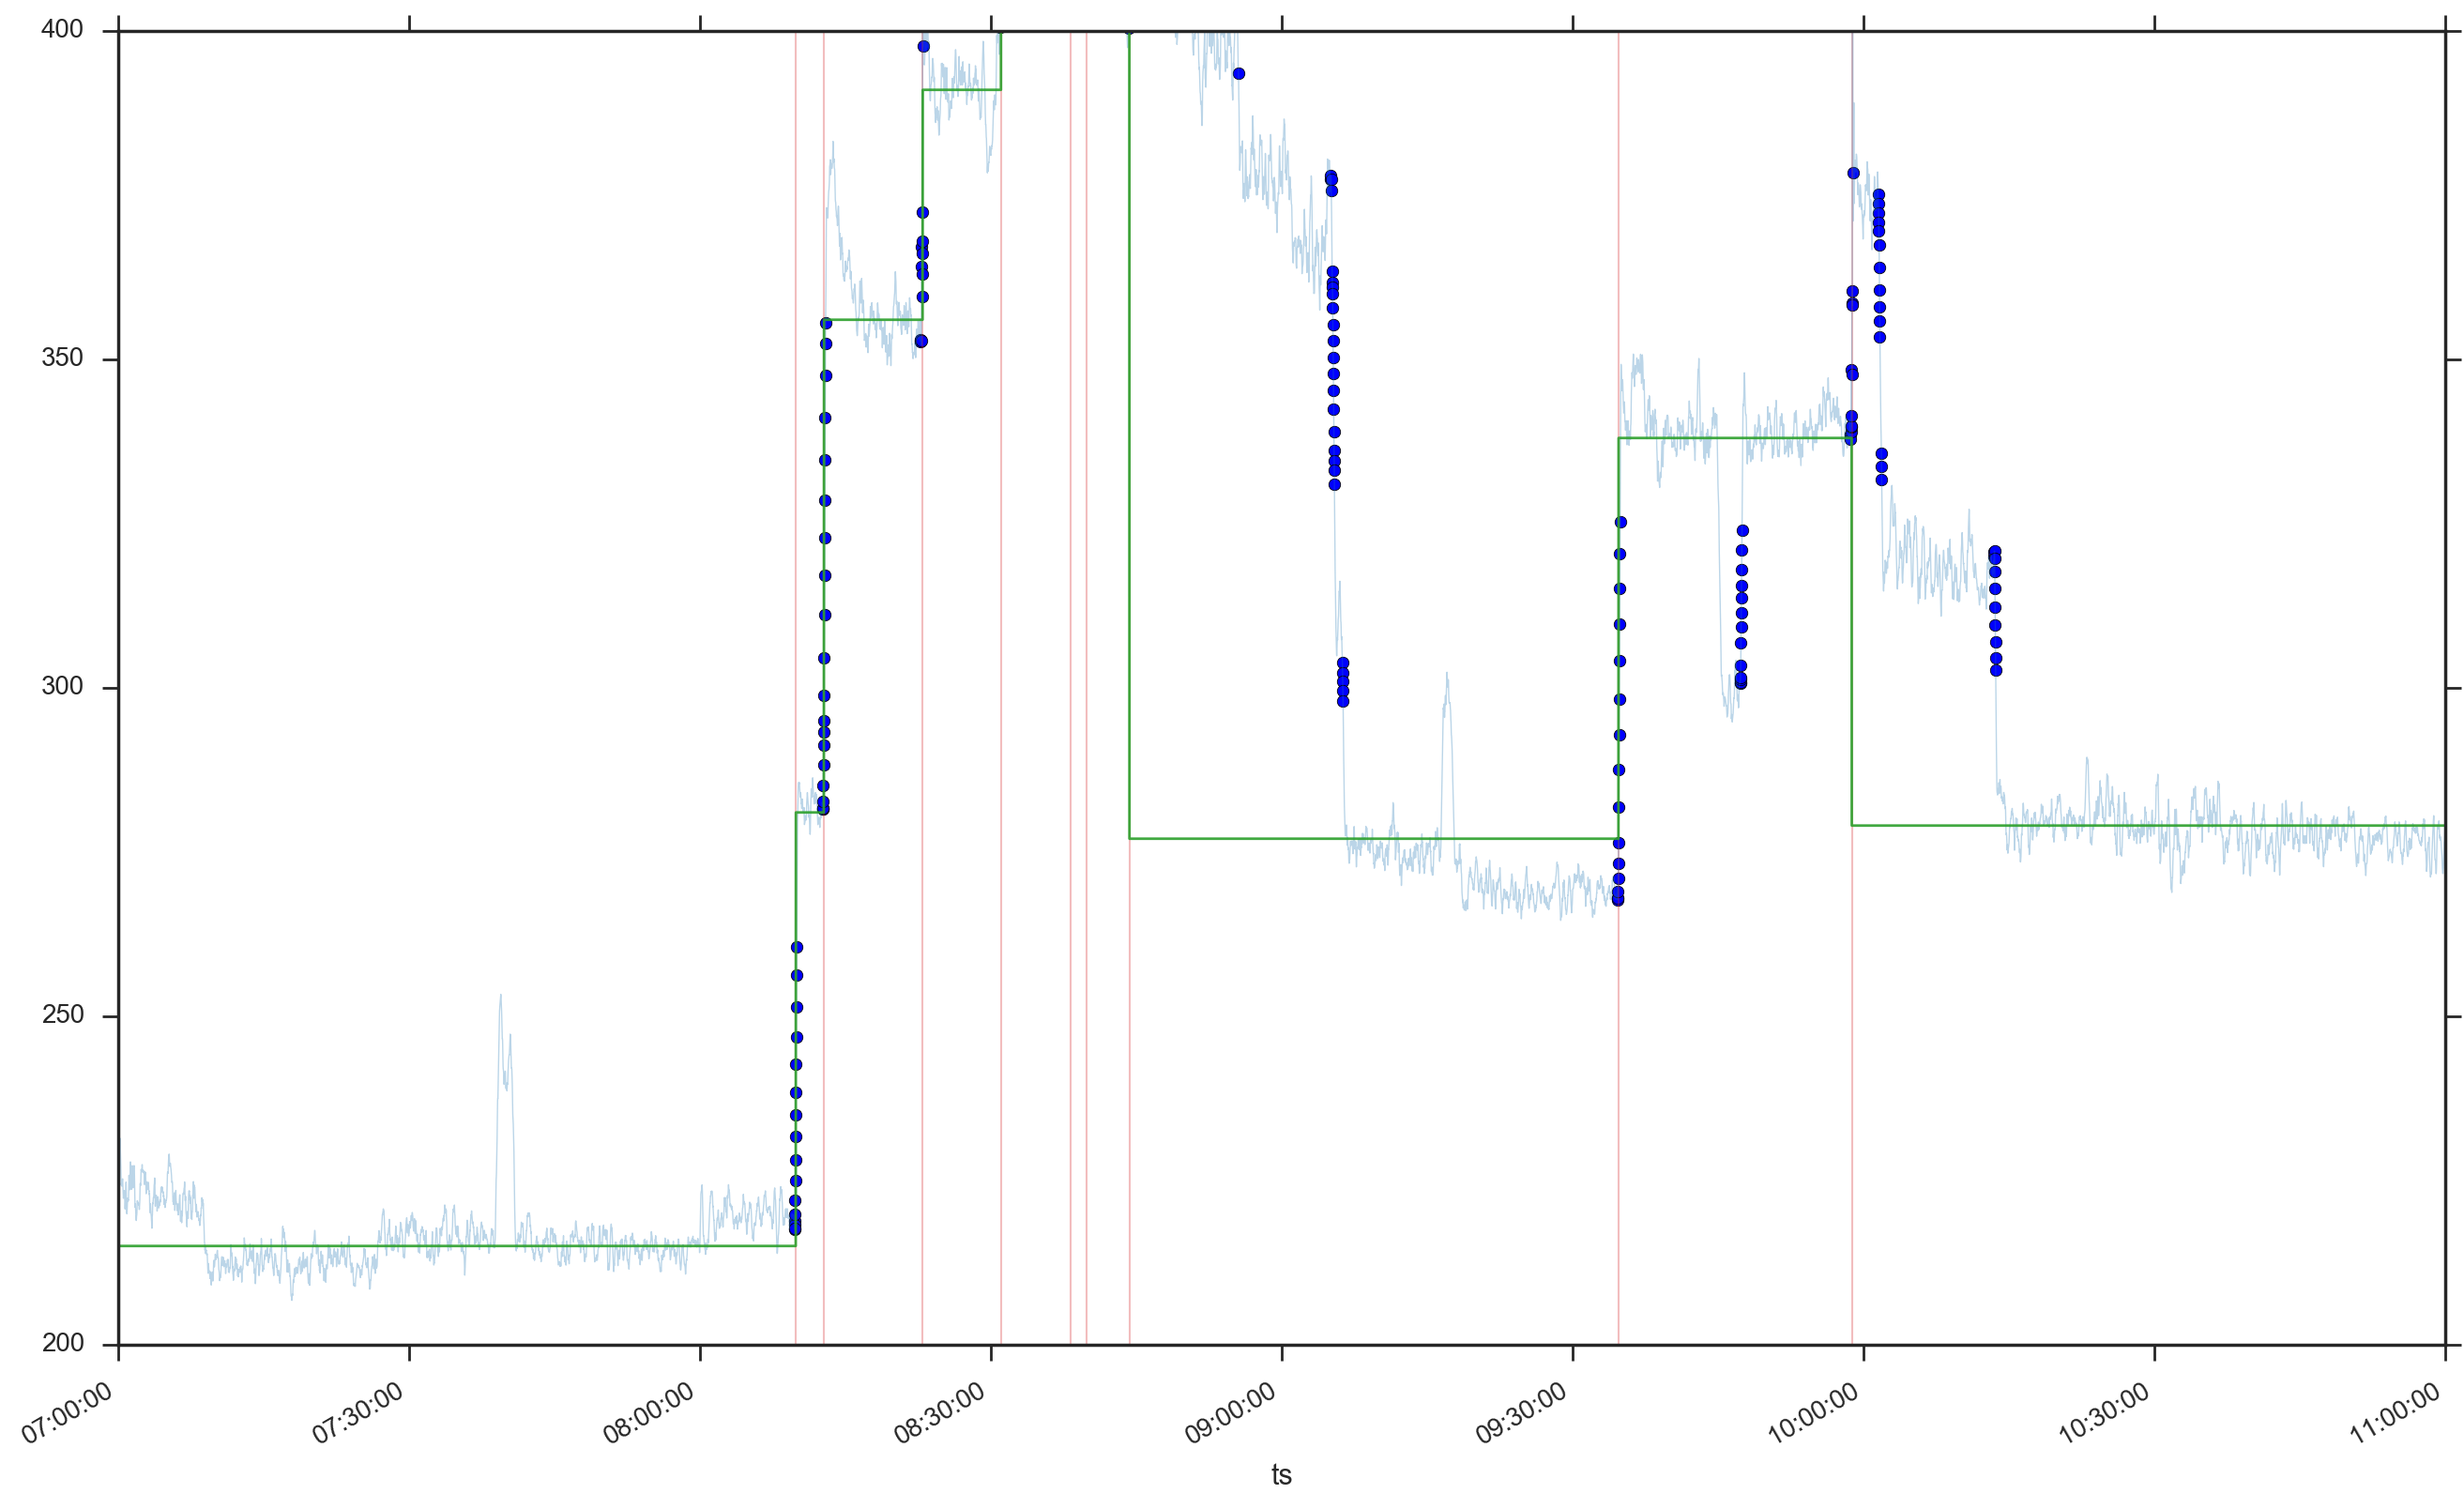

In [142]:
dp = df[df.delta_wiener.rolling(5).sum().shift(-7).abs() > 10].reset_index()

ax = plot_steps_detection(df, df_step)
ax.scatter(dp.ts.values, dp.wiener)
plt.ylim(200, 400)
#plt.xlim(dp.ts[0], dp.ts[-1])
#.plot(kind='scatter', x='ts', y='wiener')

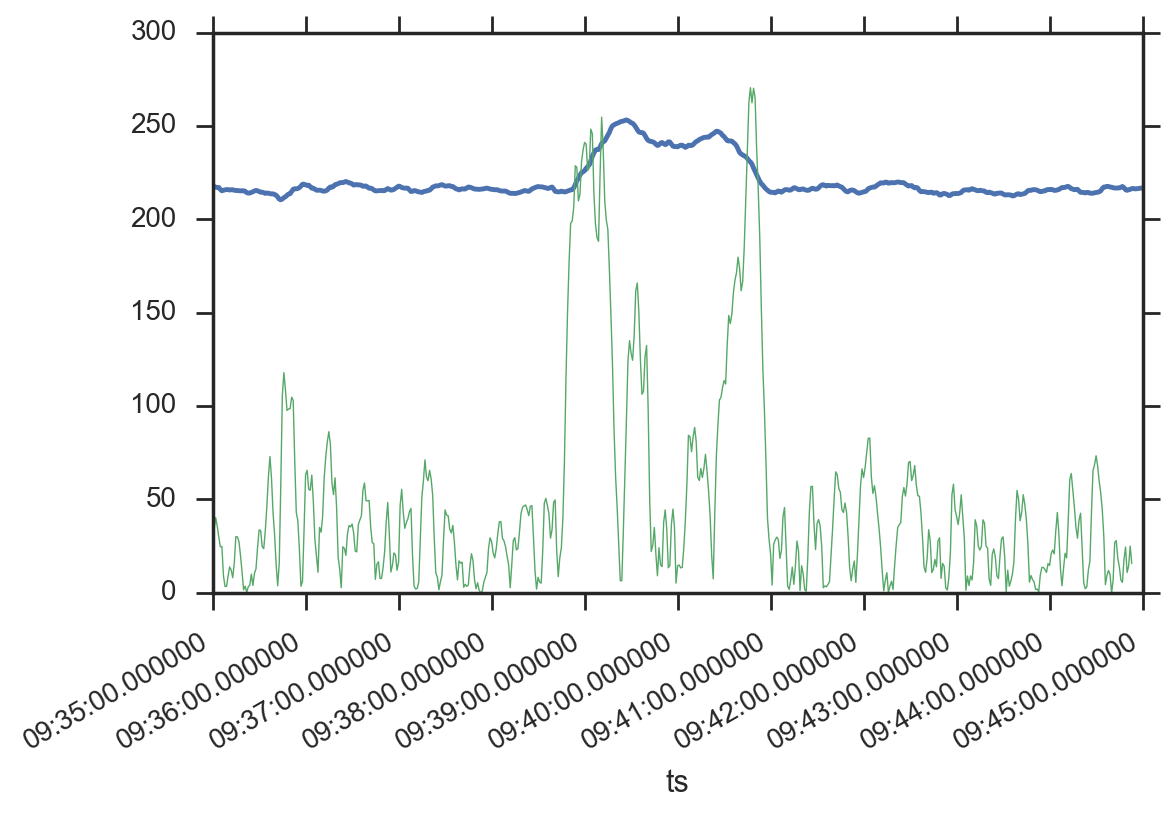

In [160]:
def _sum_pos(x):
    return np.sum(x[x > 0]) - np.sum(x[x < 0])

def _sum_neg(x):
    return -np.sum(x[x < 0])



ax = df_5.between_time('9:35', '9:45').wiener.plot()
(df_5.between_time('9:35', '9:45').delta_wiener.rolling(9).sum().shift(-7).abs()*20).plot(ax=ax, lw=.5)
#((df_5.between_time('9:35', '9:45').delta_wiener.rolling(9).apply(_sum_pos).shift(-7).abs() - df_5.between_time('9:35', '9:45').delta_wiener.rolling(9).sum().shift(-7).abs() )*20).plot(ax=ax, lw=.5)
#(df_5.between_time('9:35', '9:45').delta_wiener.rolling(5).apply(_sum_neg).shift(-7).abs()*20).plot(ax=ax, lw=.5)

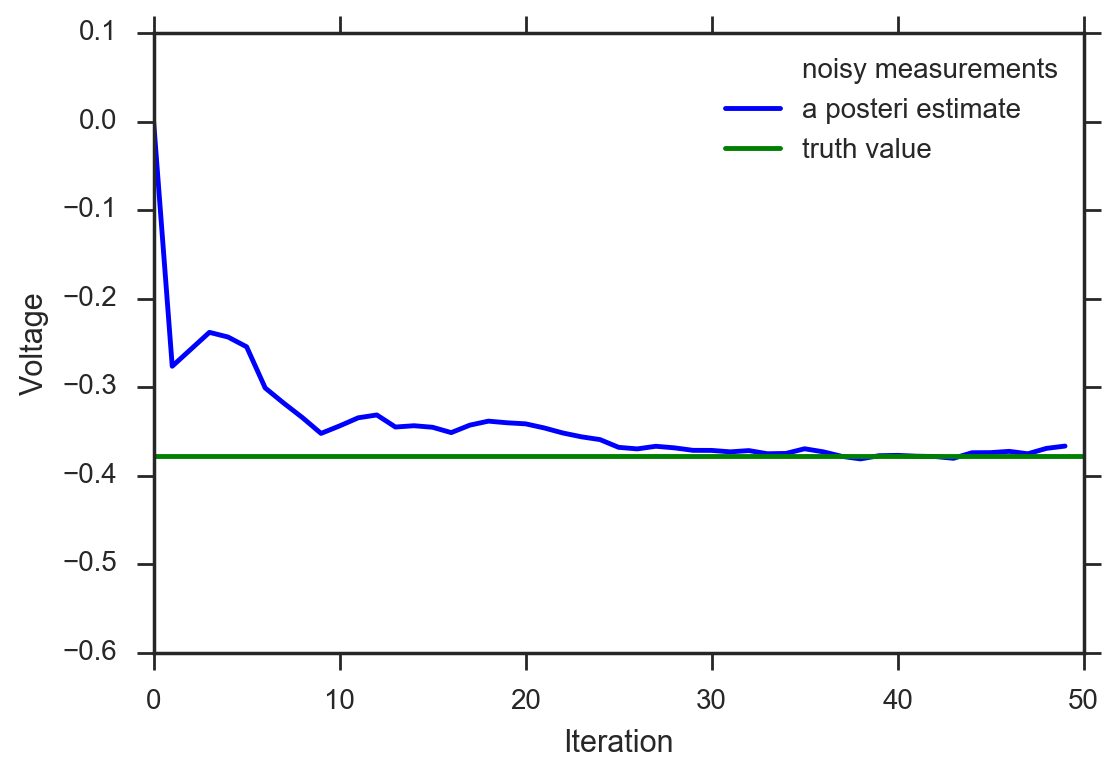

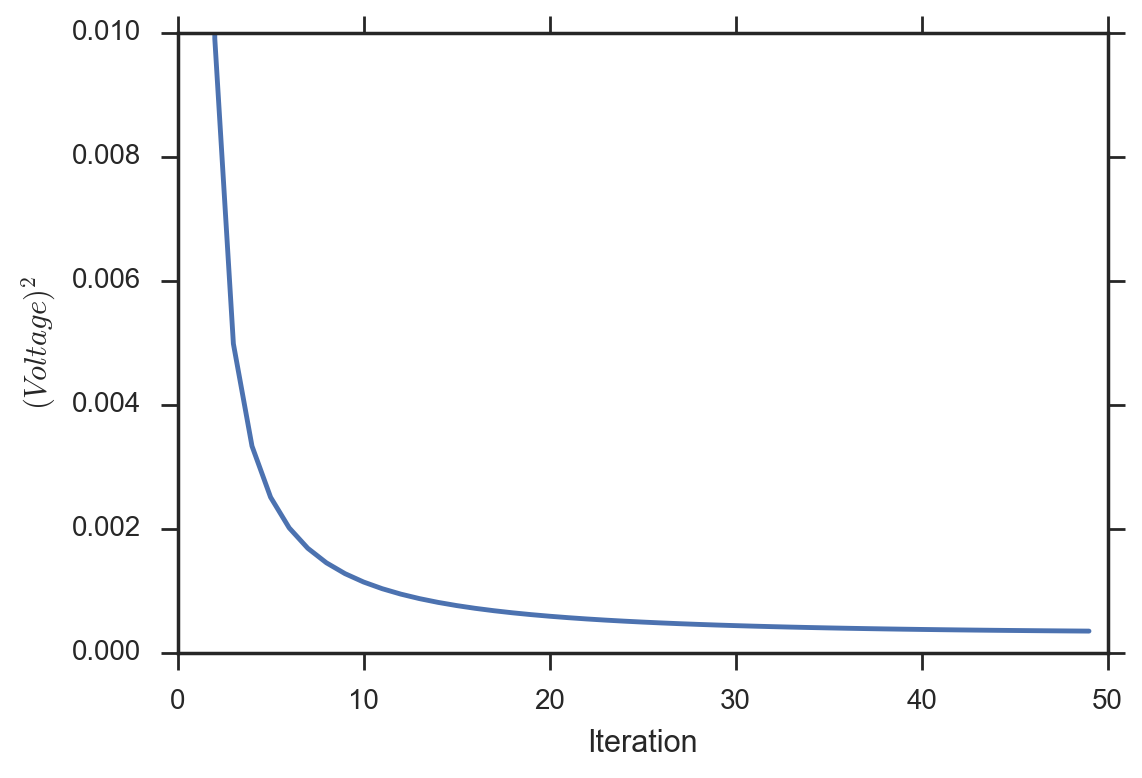

In [98]:
# Kalman filter example demo in Python

# A Python implementation of the example given in pages 11-15 of "An
# Introduction to the Kalman Filter" by Greg Welch and Gary Bishop,
# University of North Carolina at Chapel Hill, Department of Computer
# Science, TR 95-041,
# http://www.cs.unc.edu/~welch/kalman/kalmanIntro.html

# by Andrew D. Straw

import numpy
import pylab

# intial parameters
n_iter = 50
sz = (n_iter,) # size of array
x = -0.37727 # truth value (typo in example at top of p. 13 calls this z)
z = numpy.random.normal(x,0.1,size=sz) # observations (normal about x, sigma=0.1)

Q = 1e-5 # process variance

# allocate space for arrays
xhat=numpy.zeros(sz)      # a posteri estimate of x
P=numpy.zeros(sz)         # a posteri error estimate
xhatminus=numpy.zeros(sz) # a priori estimate of x
Pminus=numpy.zeros(sz)    # a priori error estimate
K=numpy.zeros(sz)         # gain or blending factor

R = 0.1**2 # estimate of measurement variance, change to see effect

# intial guesses
xhat[0] = 0.0
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    xhatminus[k] = xhat[k-1]
    Pminus[k] = P[k-1]+Q
    
    # measurement update
    K[k] = Pminus[k]/( Pminus[k]+R )
    xhat[k] = xhatminus[k]+K[k]*(z[k]-xhatminus[k])
    P[k] = (1-K[k])*Pminus[k]

pylab.figure()
pylab.plot(z,'k+',label='noisy measurements')
pylab.plot(xhat,'b-',label='a posteri estimate')
pylab.axhline(x,color='g',label='truth value')
pylab.legend()
pylab.xlabel('Iteration')
pylab.ylabel('Voltage')

pylab.figure()
valid_iter = range(1,n_iter) # Pminus not valid at step 0
pylab.plot(valid_iter,Pminus[valid_iter],label='a priori error estimate')
pylab.xlabel('Iteration')
pylab.ylabel('$(Voltage)^2$')
pylab.setp(pylab.gca(),'ylim',[0,.01])
pylab.show()

#df['firwin_hanning'] = firwin(df.power, kernel_size=15)
#df

In [97]:
firwin?

process_savgol TOOK: 0.008 s


power      wiener  delta_wiener abs_ch     r_std      r_mean      savgol
ts                                                                                                      
2016-09-10 08:30:00+02:00  232.465179  248.667640      0.627884  False  0.899339  247.797532  234.070206
2016-09-10 08:30:01+02:00  245.376541  247.866430     -0.801211  False  1.532316  248.255107  238.917404
2016-09-10 08:30:02+02:00  255.756119  247.156047     -0.710383  False  1.886681  248.892855  241.762878
2016-09-10 08:30:03+02:00  252.692841  246.989616     -0.166431  False  1.976066  249.597289  242.076218
2016-09-10 08:30:04+02:00  238.602524  247.037969      0.048353  False  1.941258  250.426916  243.187134

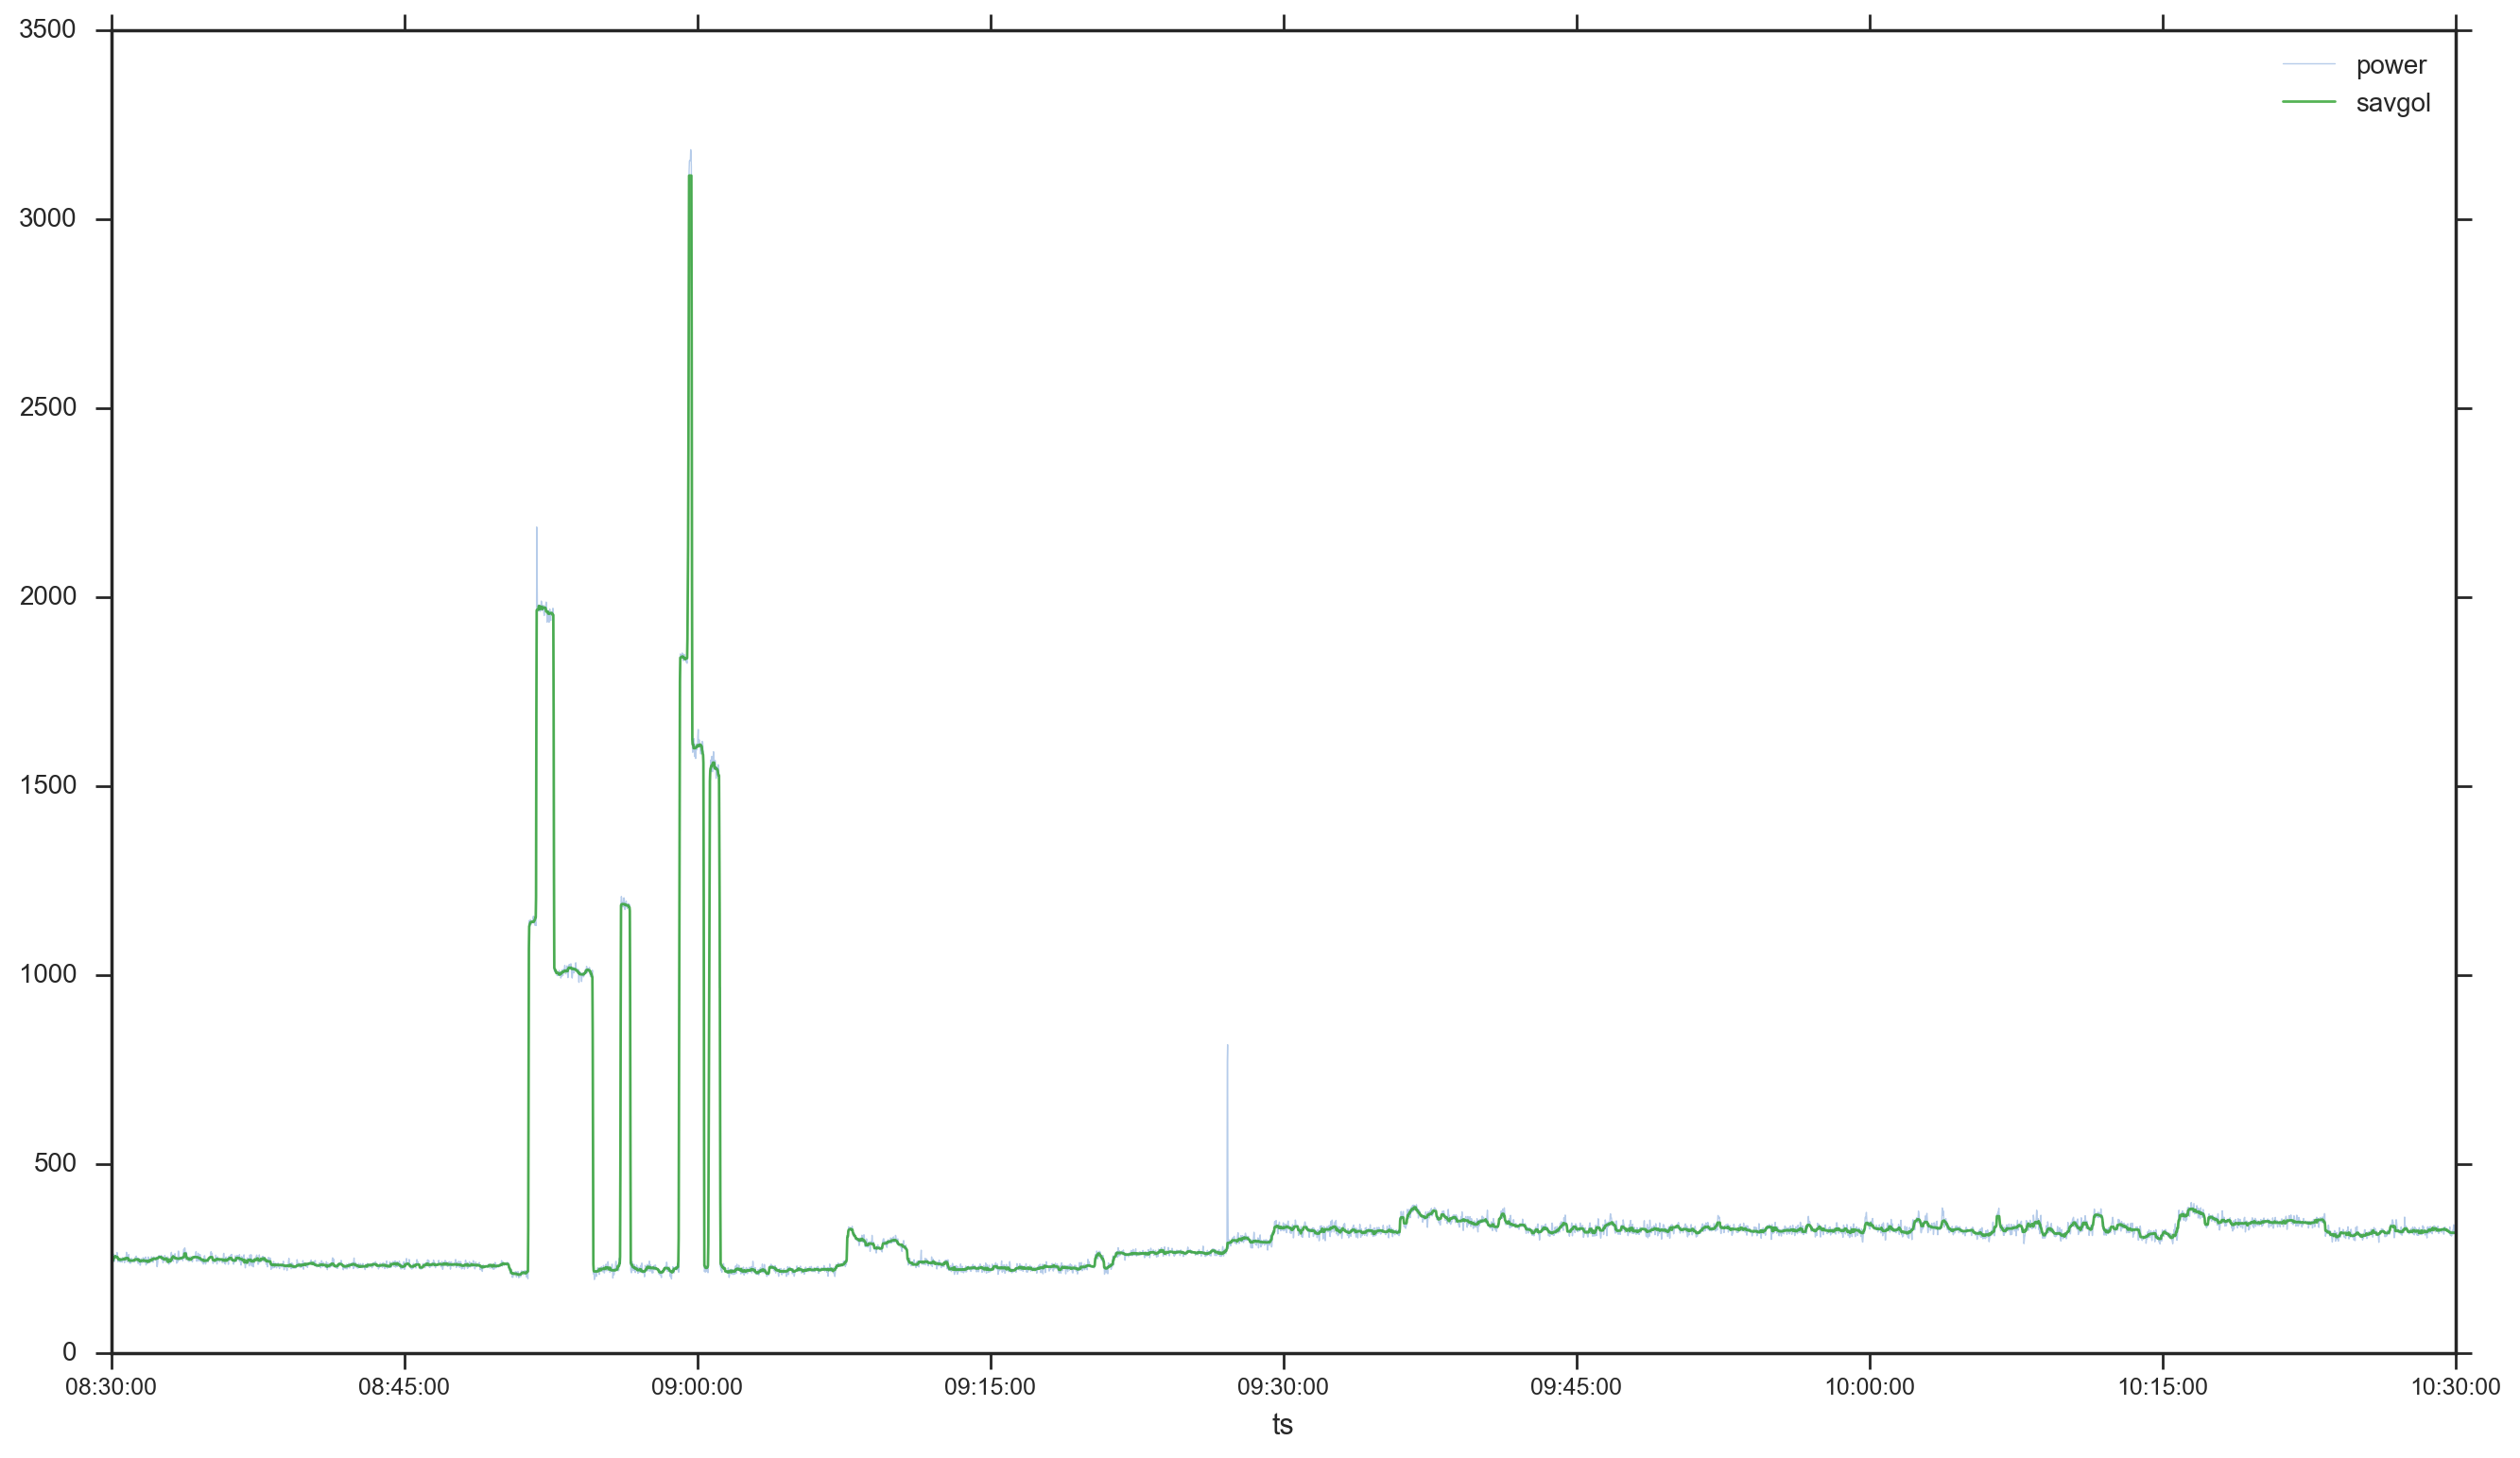

In [58]:
# scipy.signal.savgol_filter
from scipy.signal import savgol_filter


@timeit('process_savgol', verbose=True)
def process_savgol(df, window_len=11, polyorder=2):
    df_out = df.copy()
    df_out['savgol'] = medfilt(savgol_filter(df.power.values, window_len, polyorder, 
                                             deriv=0, delta=3, mode='nearest'), 
                               kernel_size=2 * window_len + 1)
    return df_out
    

def plot_savgol(df, window_len=11, polyorder=2):
    ax = df.power.plot(figsize=FS, legend='RAW', **D_FILTERS['power'])
    k = 'savgol'
    df[k].plot(ax=ax, legend=k, lw=1, color=tableau20[4], alpha=.8)
    ax.xaxis.set_major_formatter(mpd.DateFormatter('%H:%M:%S', tz=TZ))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, ha='center')
    ax.xaxis.set_tick_params(labelsize=9, pad=3)
    return ax


df_1sg = process_savgol(df_1, 7, 4)

plot_savgol(df_1sg) #.between_time('8:50', '9:05'))
df_1sg.head()

process_savgol TOOK: 0.021 s
process_savgol TOOK: 0.014 s
process_savgol TOOK: 0.010 s
process_savgol TOOK: 0.075 s


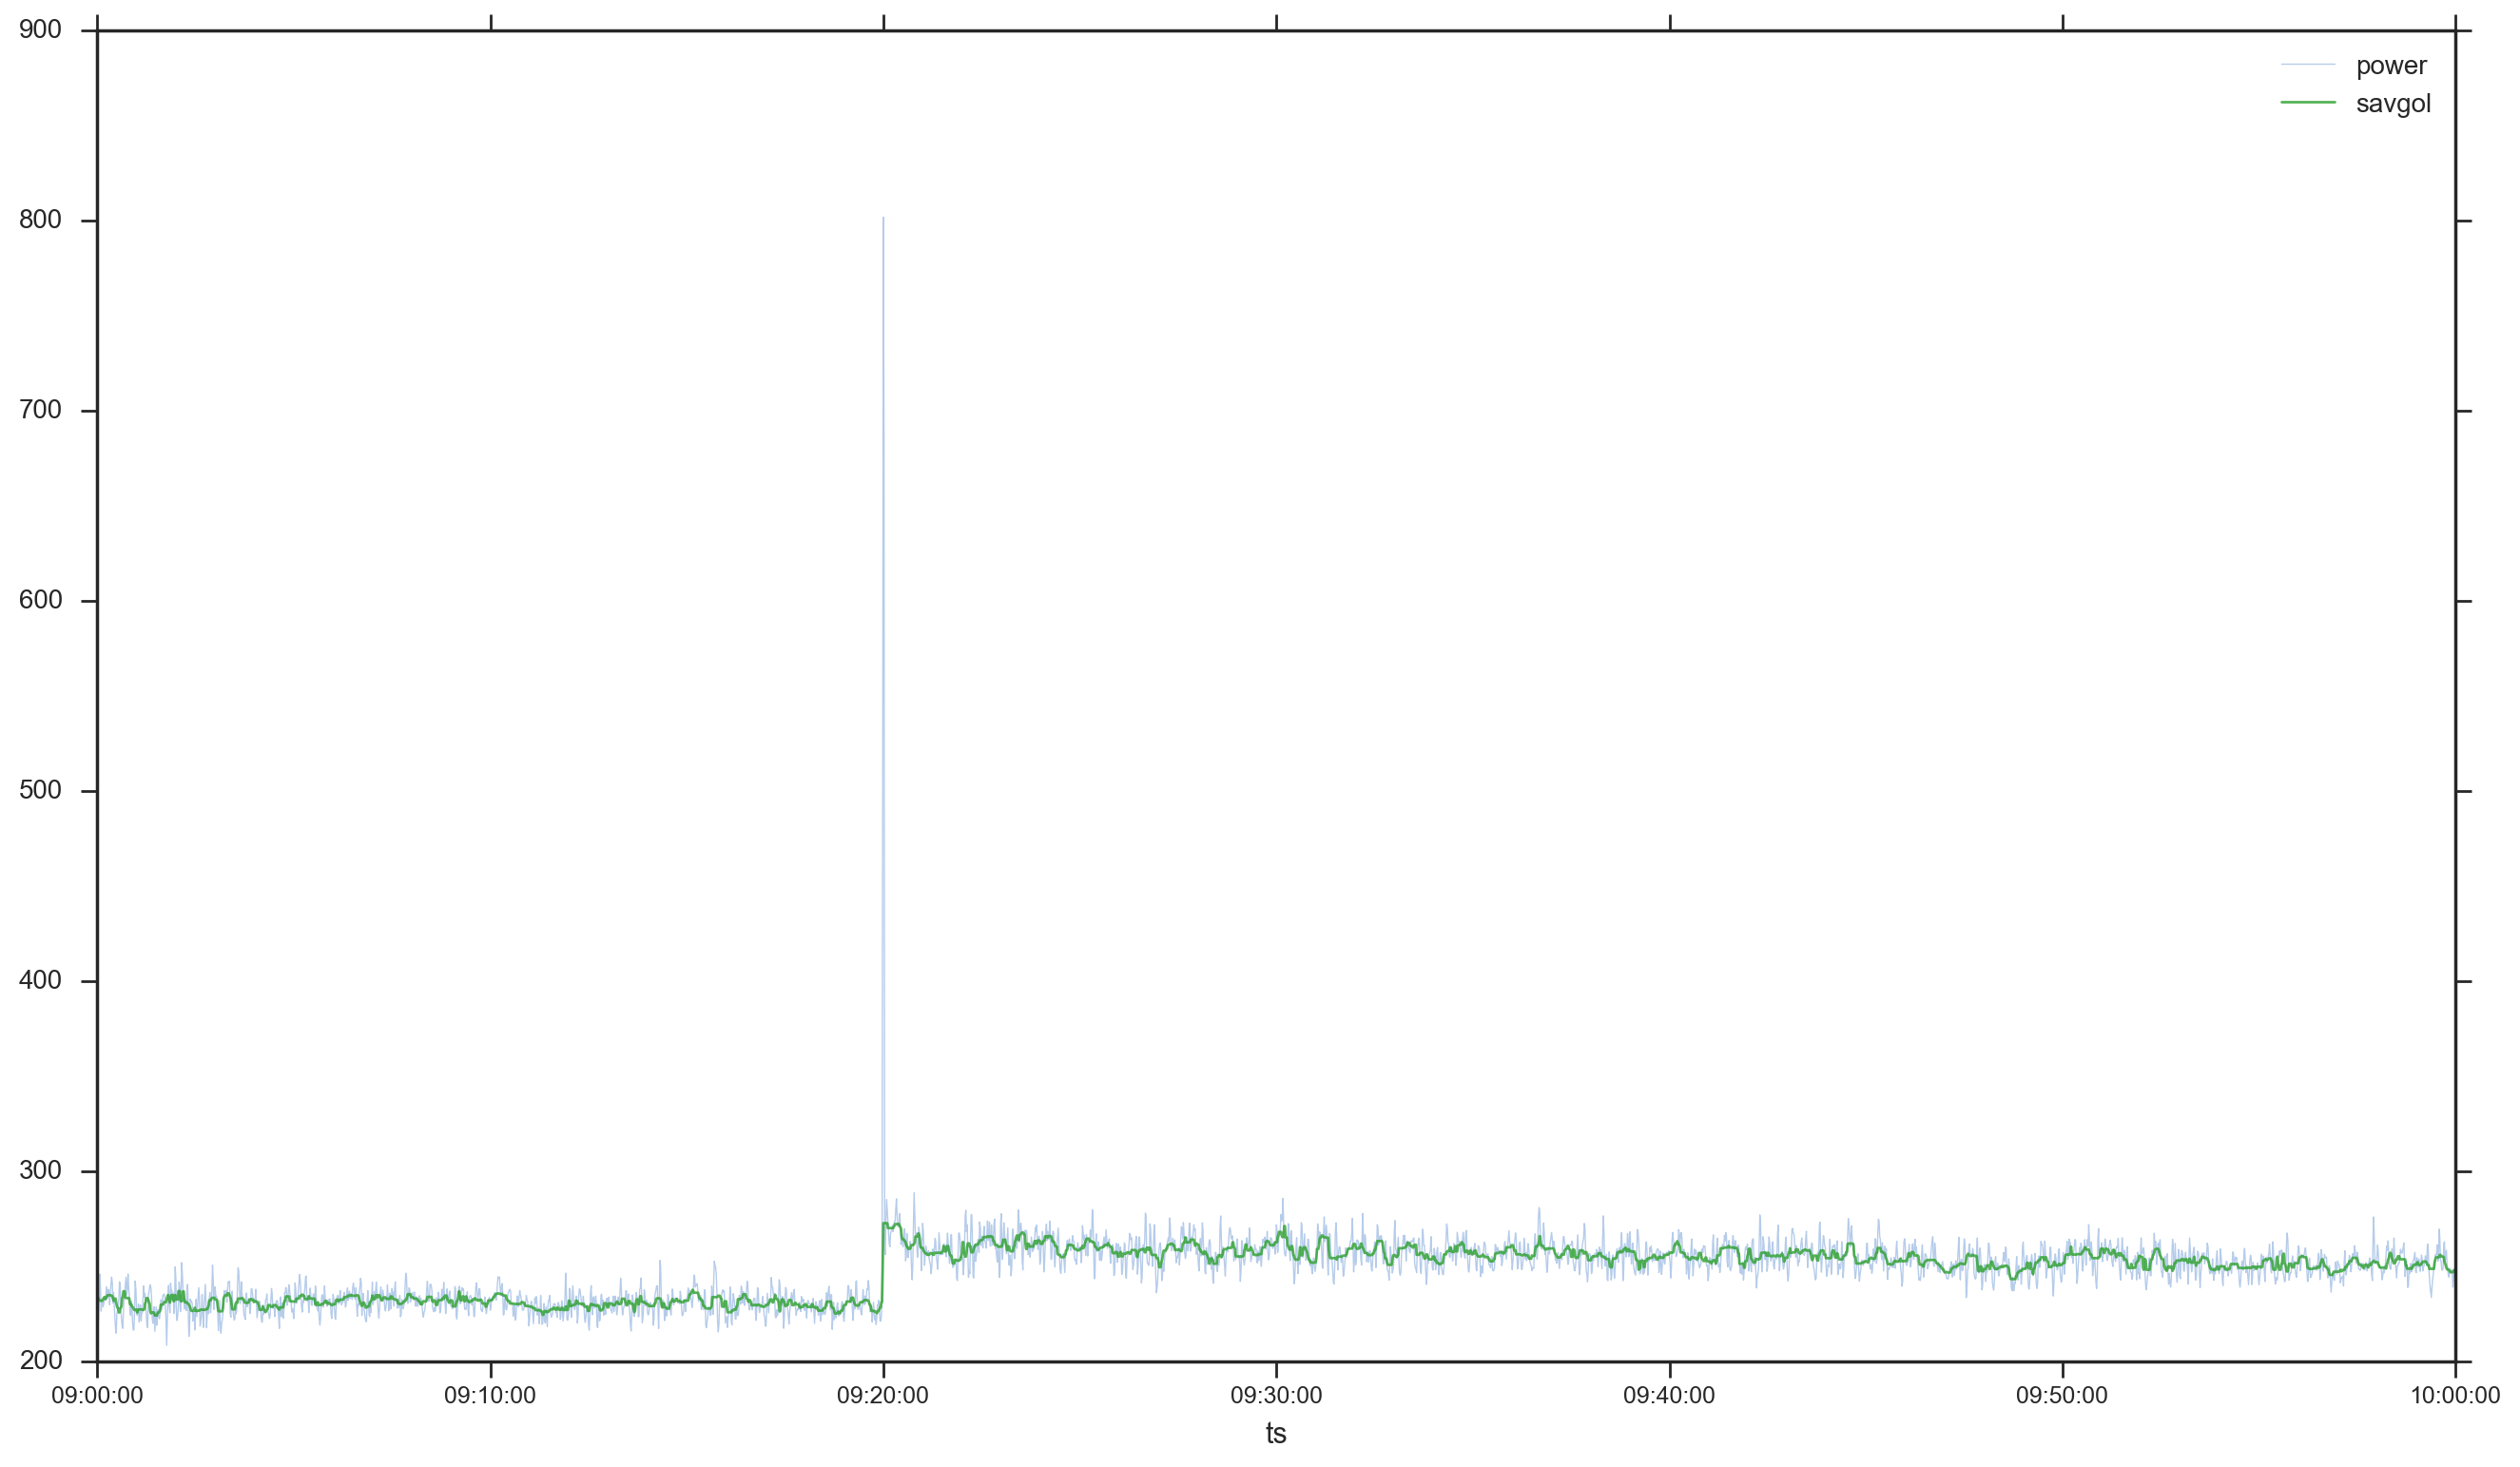

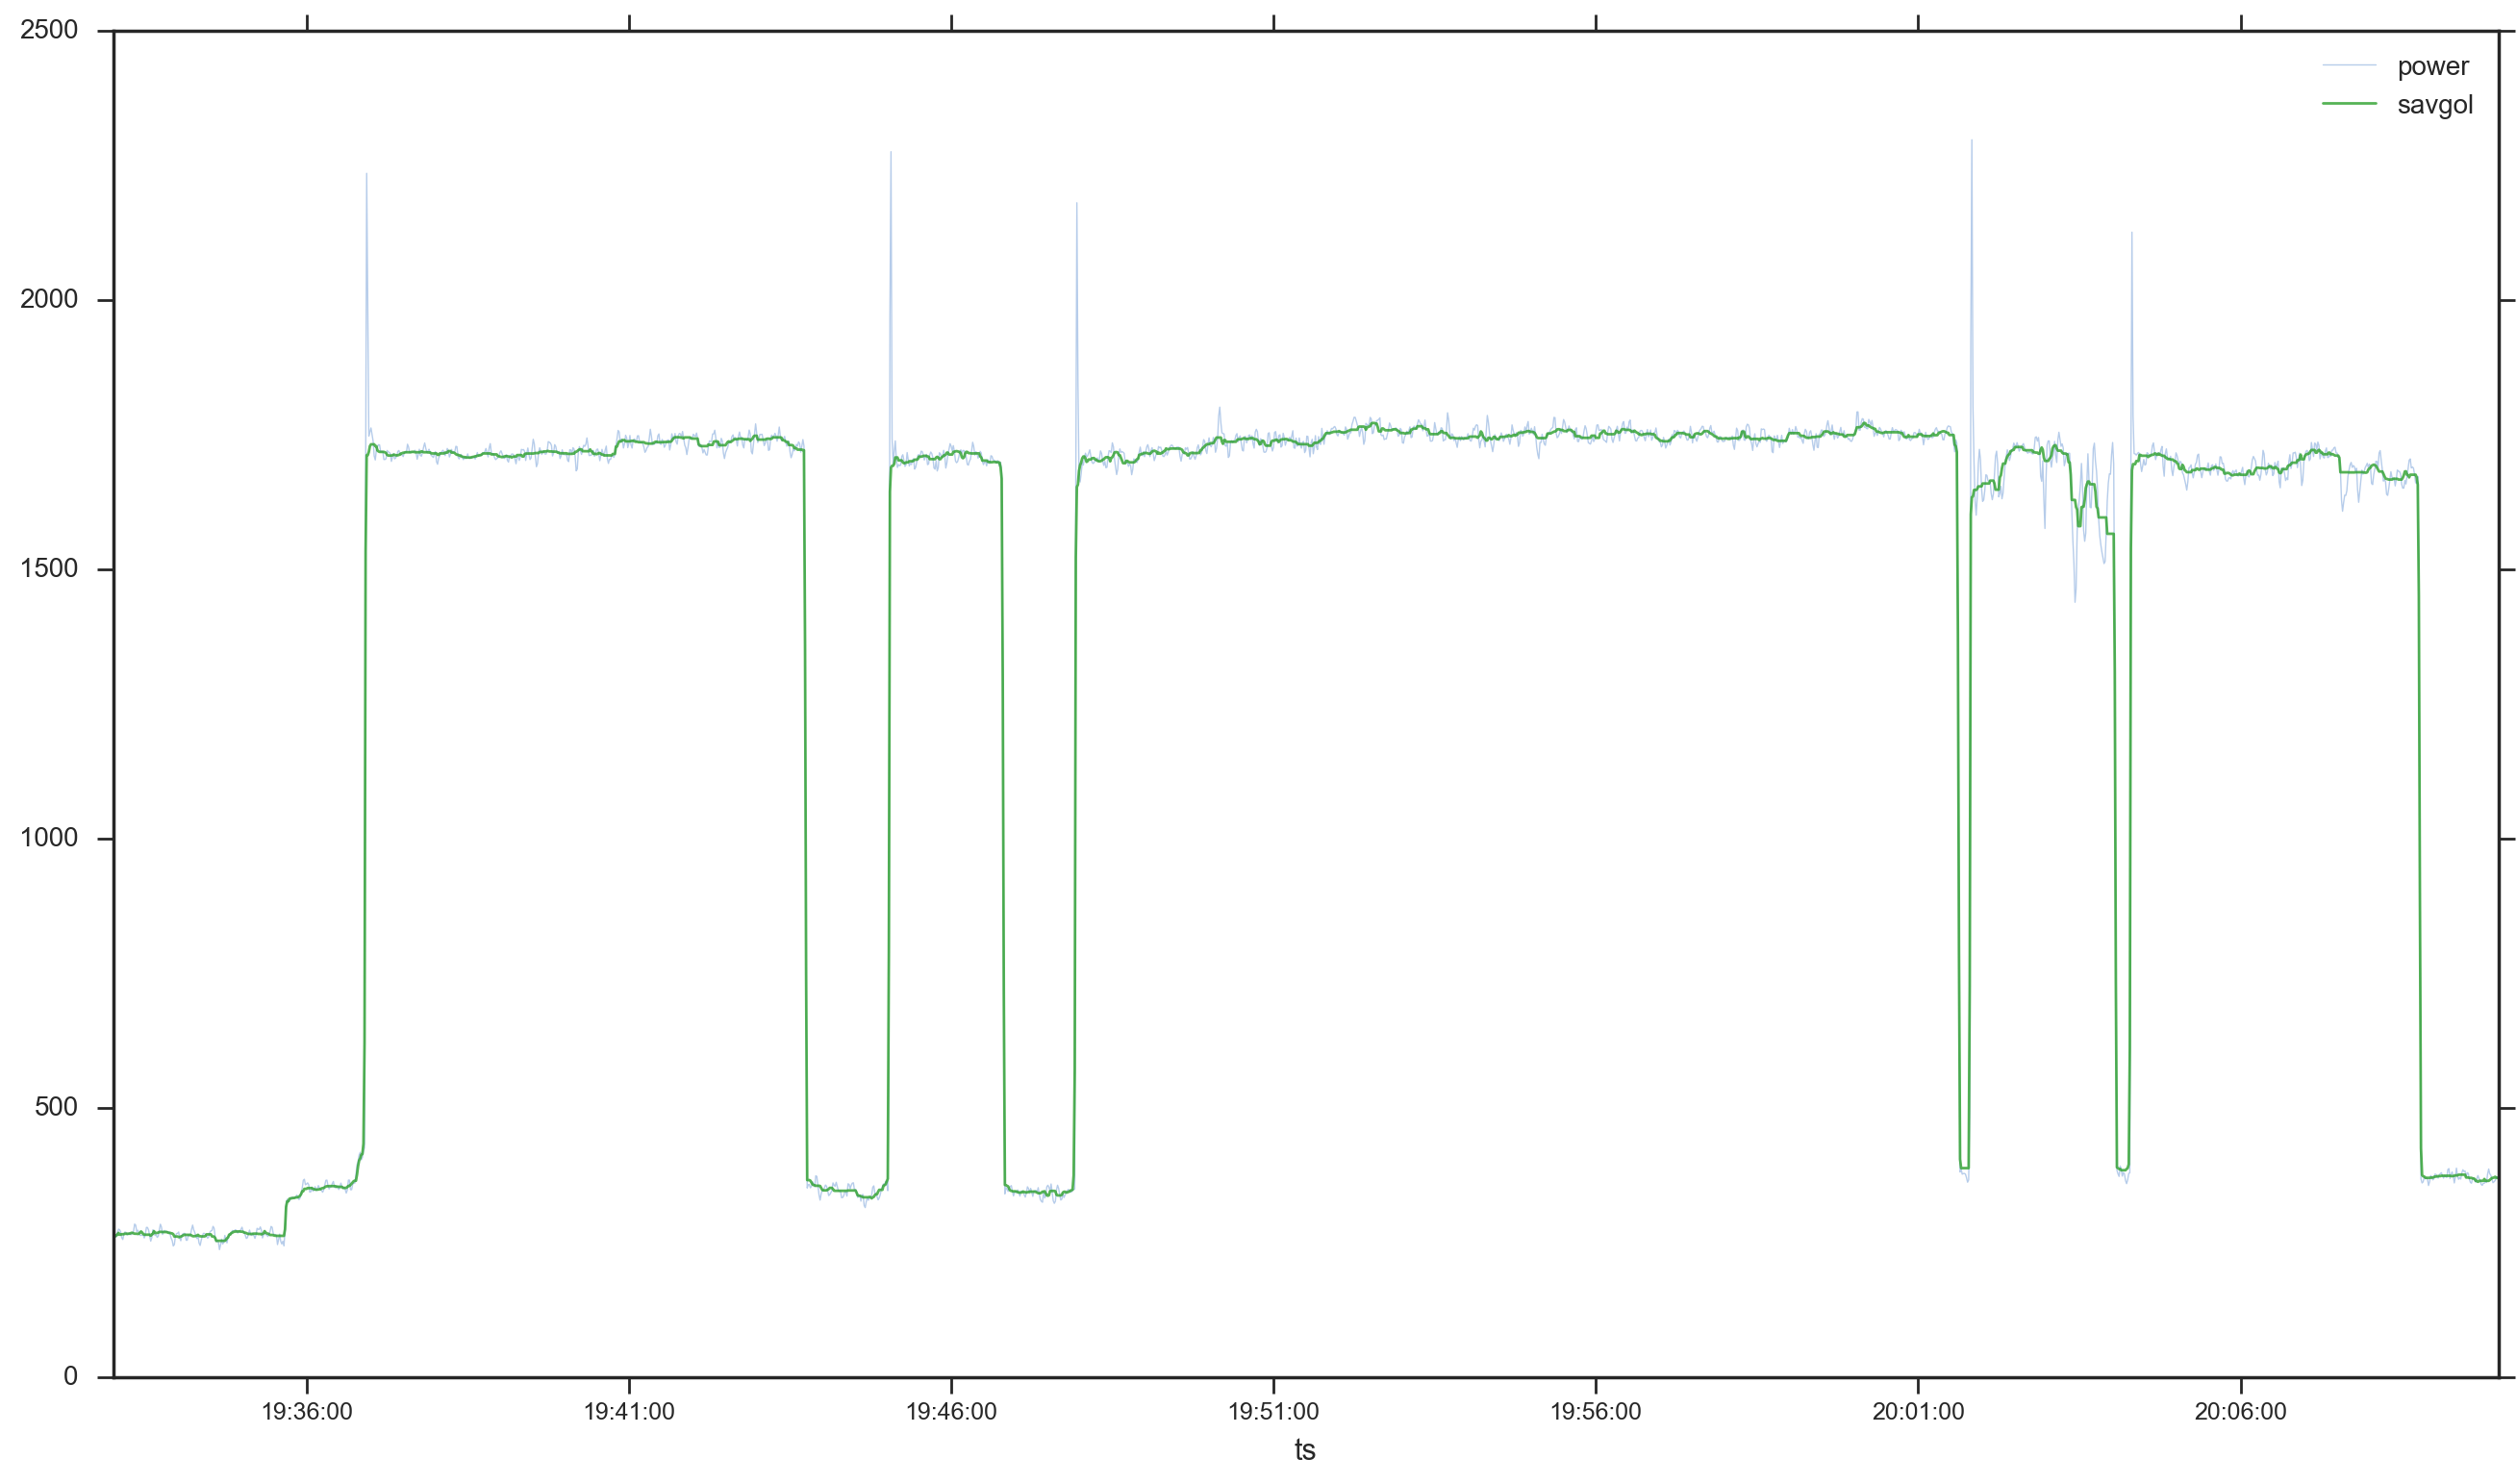

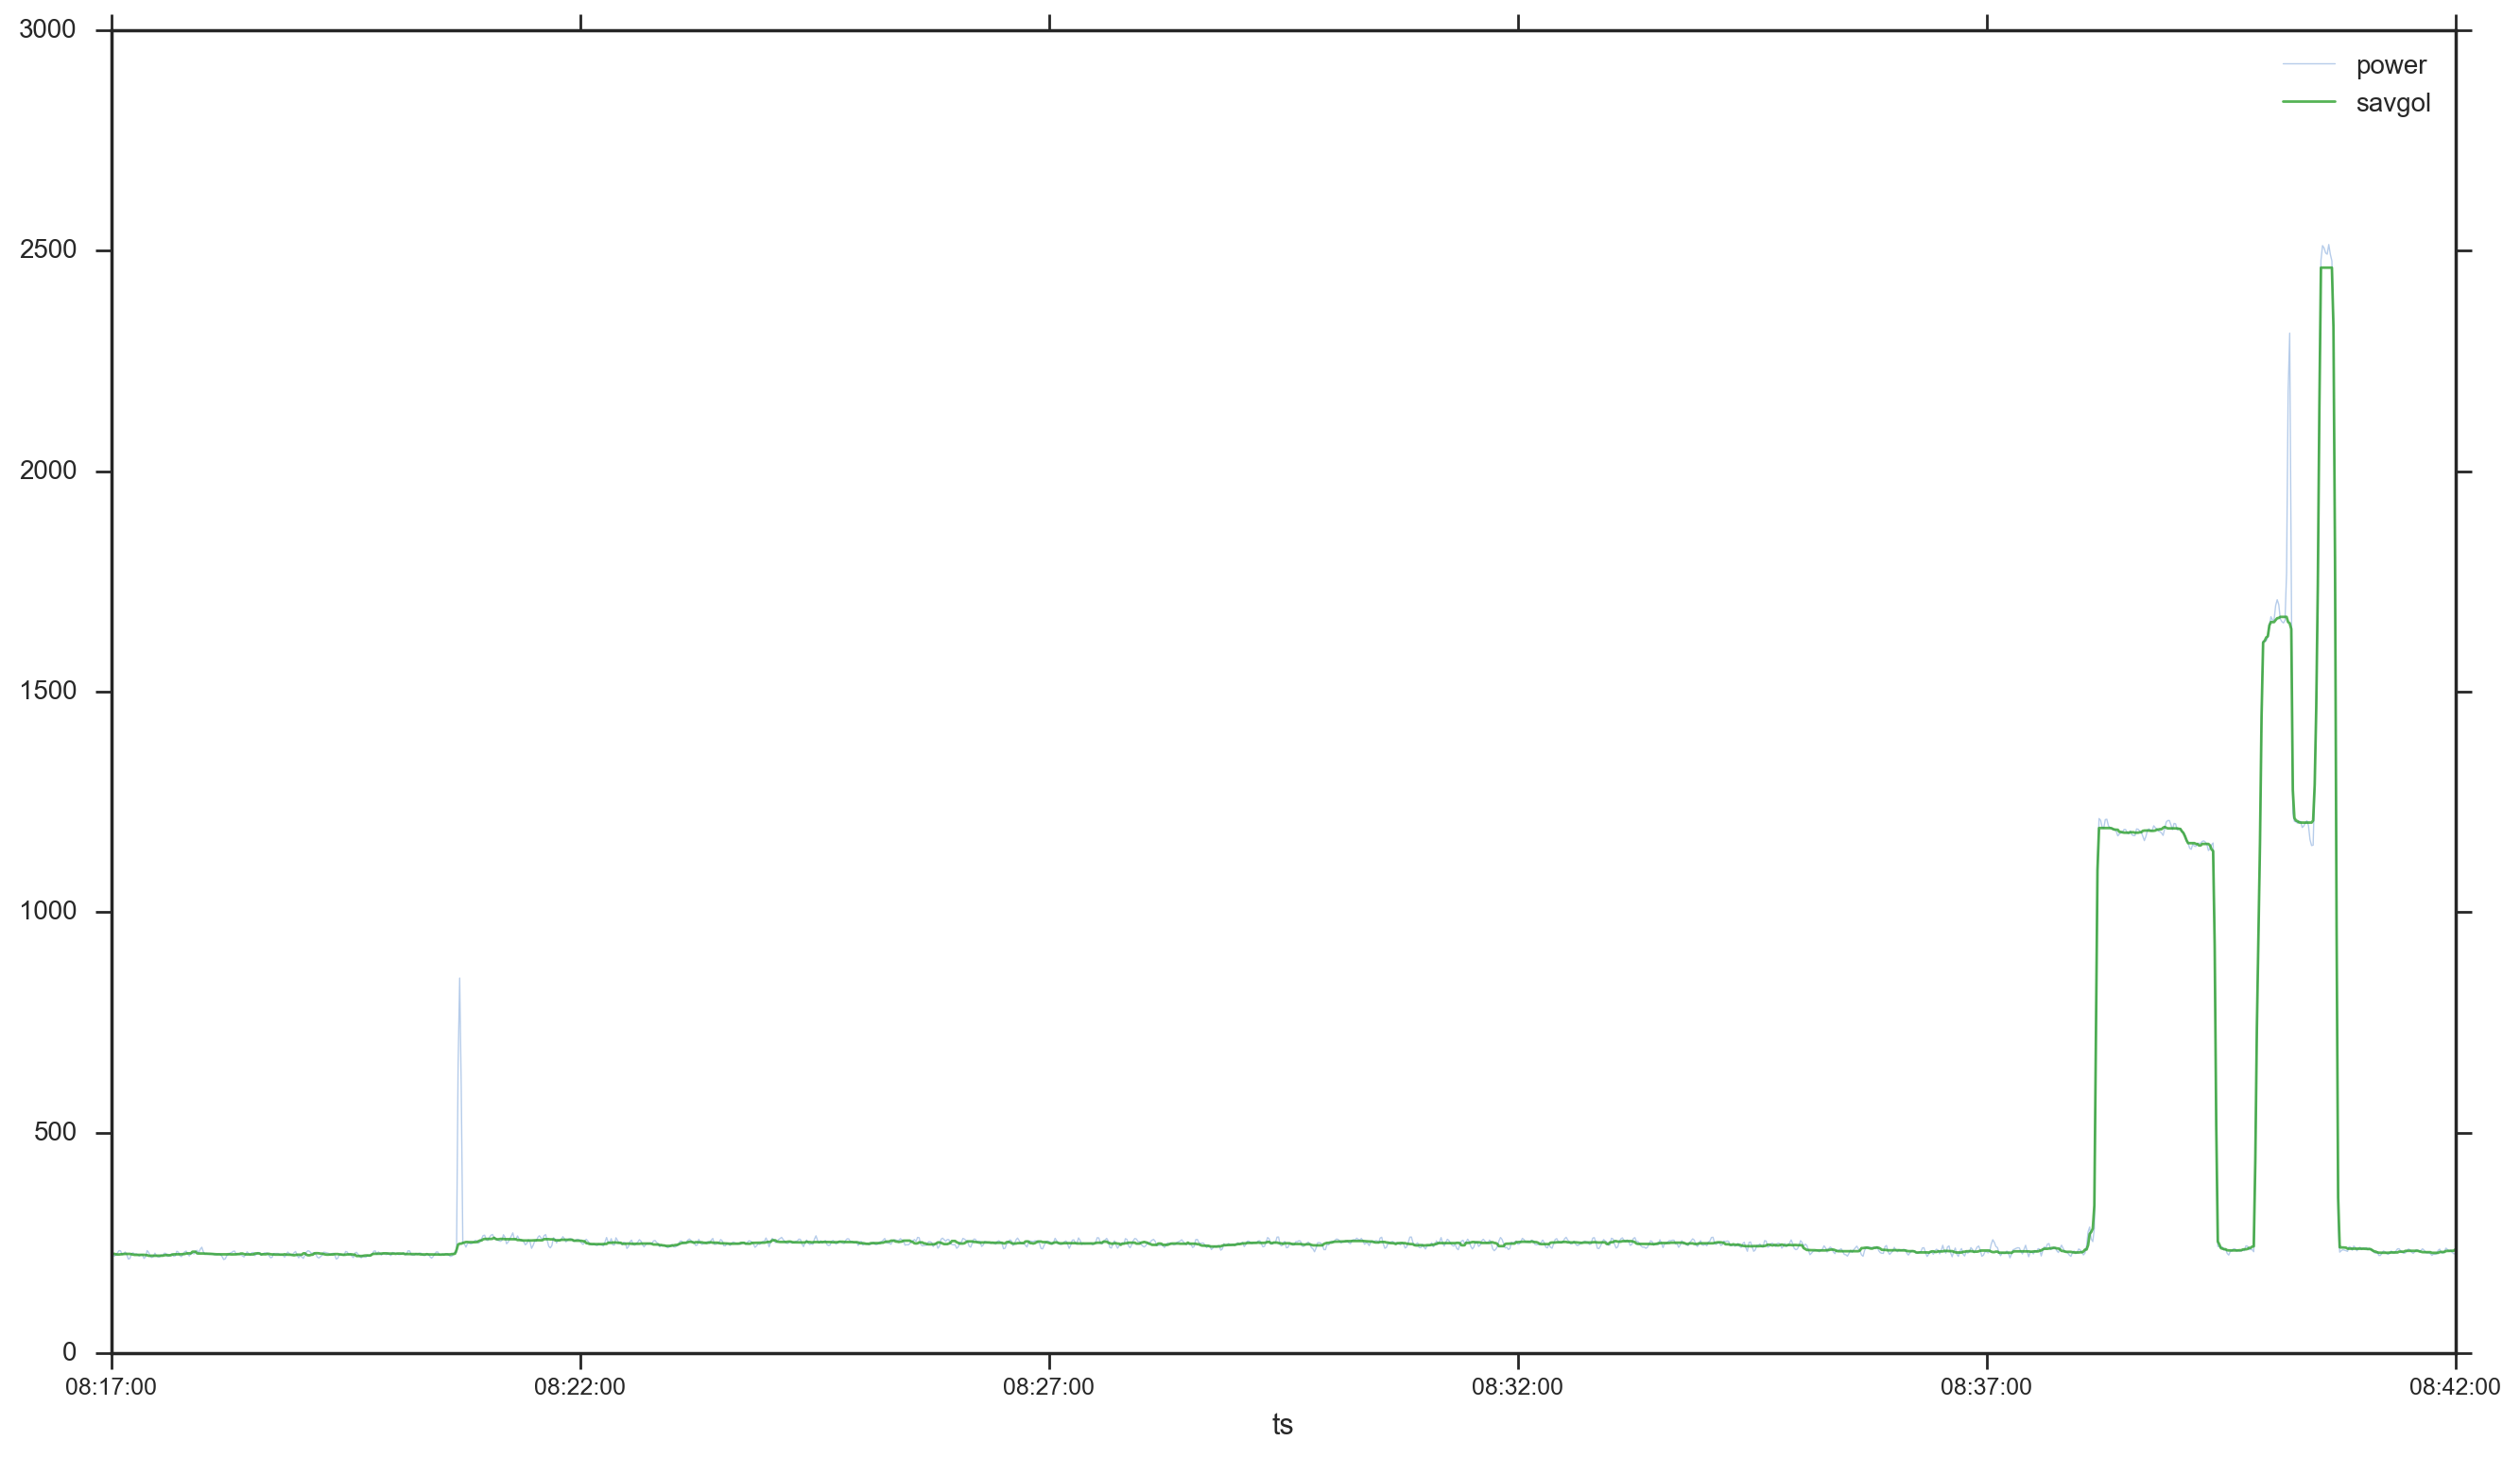

In [70]:
window_len, polyorder = 7, 4

df_2sg = process_savgol(df_2, window_len, polyorder)
df_3sg = process_savgol(df_3, window_len, polyorder)
df_4sg = process_savgol(df_4, window_len, polyorder)
df_5sg = process_savgol(df_5, window_len, polyorder)


plot_savgol(df_2sg.between_time('9:00', '10:00'))
plt.show()
plot_savgol(df_3sg.between_time('19:33', '20:10'))
plt.show()
#plot_savgol(df_4sg) #.between_time('9:00', '10:00'))
#plt.show()
plot_savgol(df_5sg.between_time('8:17', '8:42:00'))
plt.show()

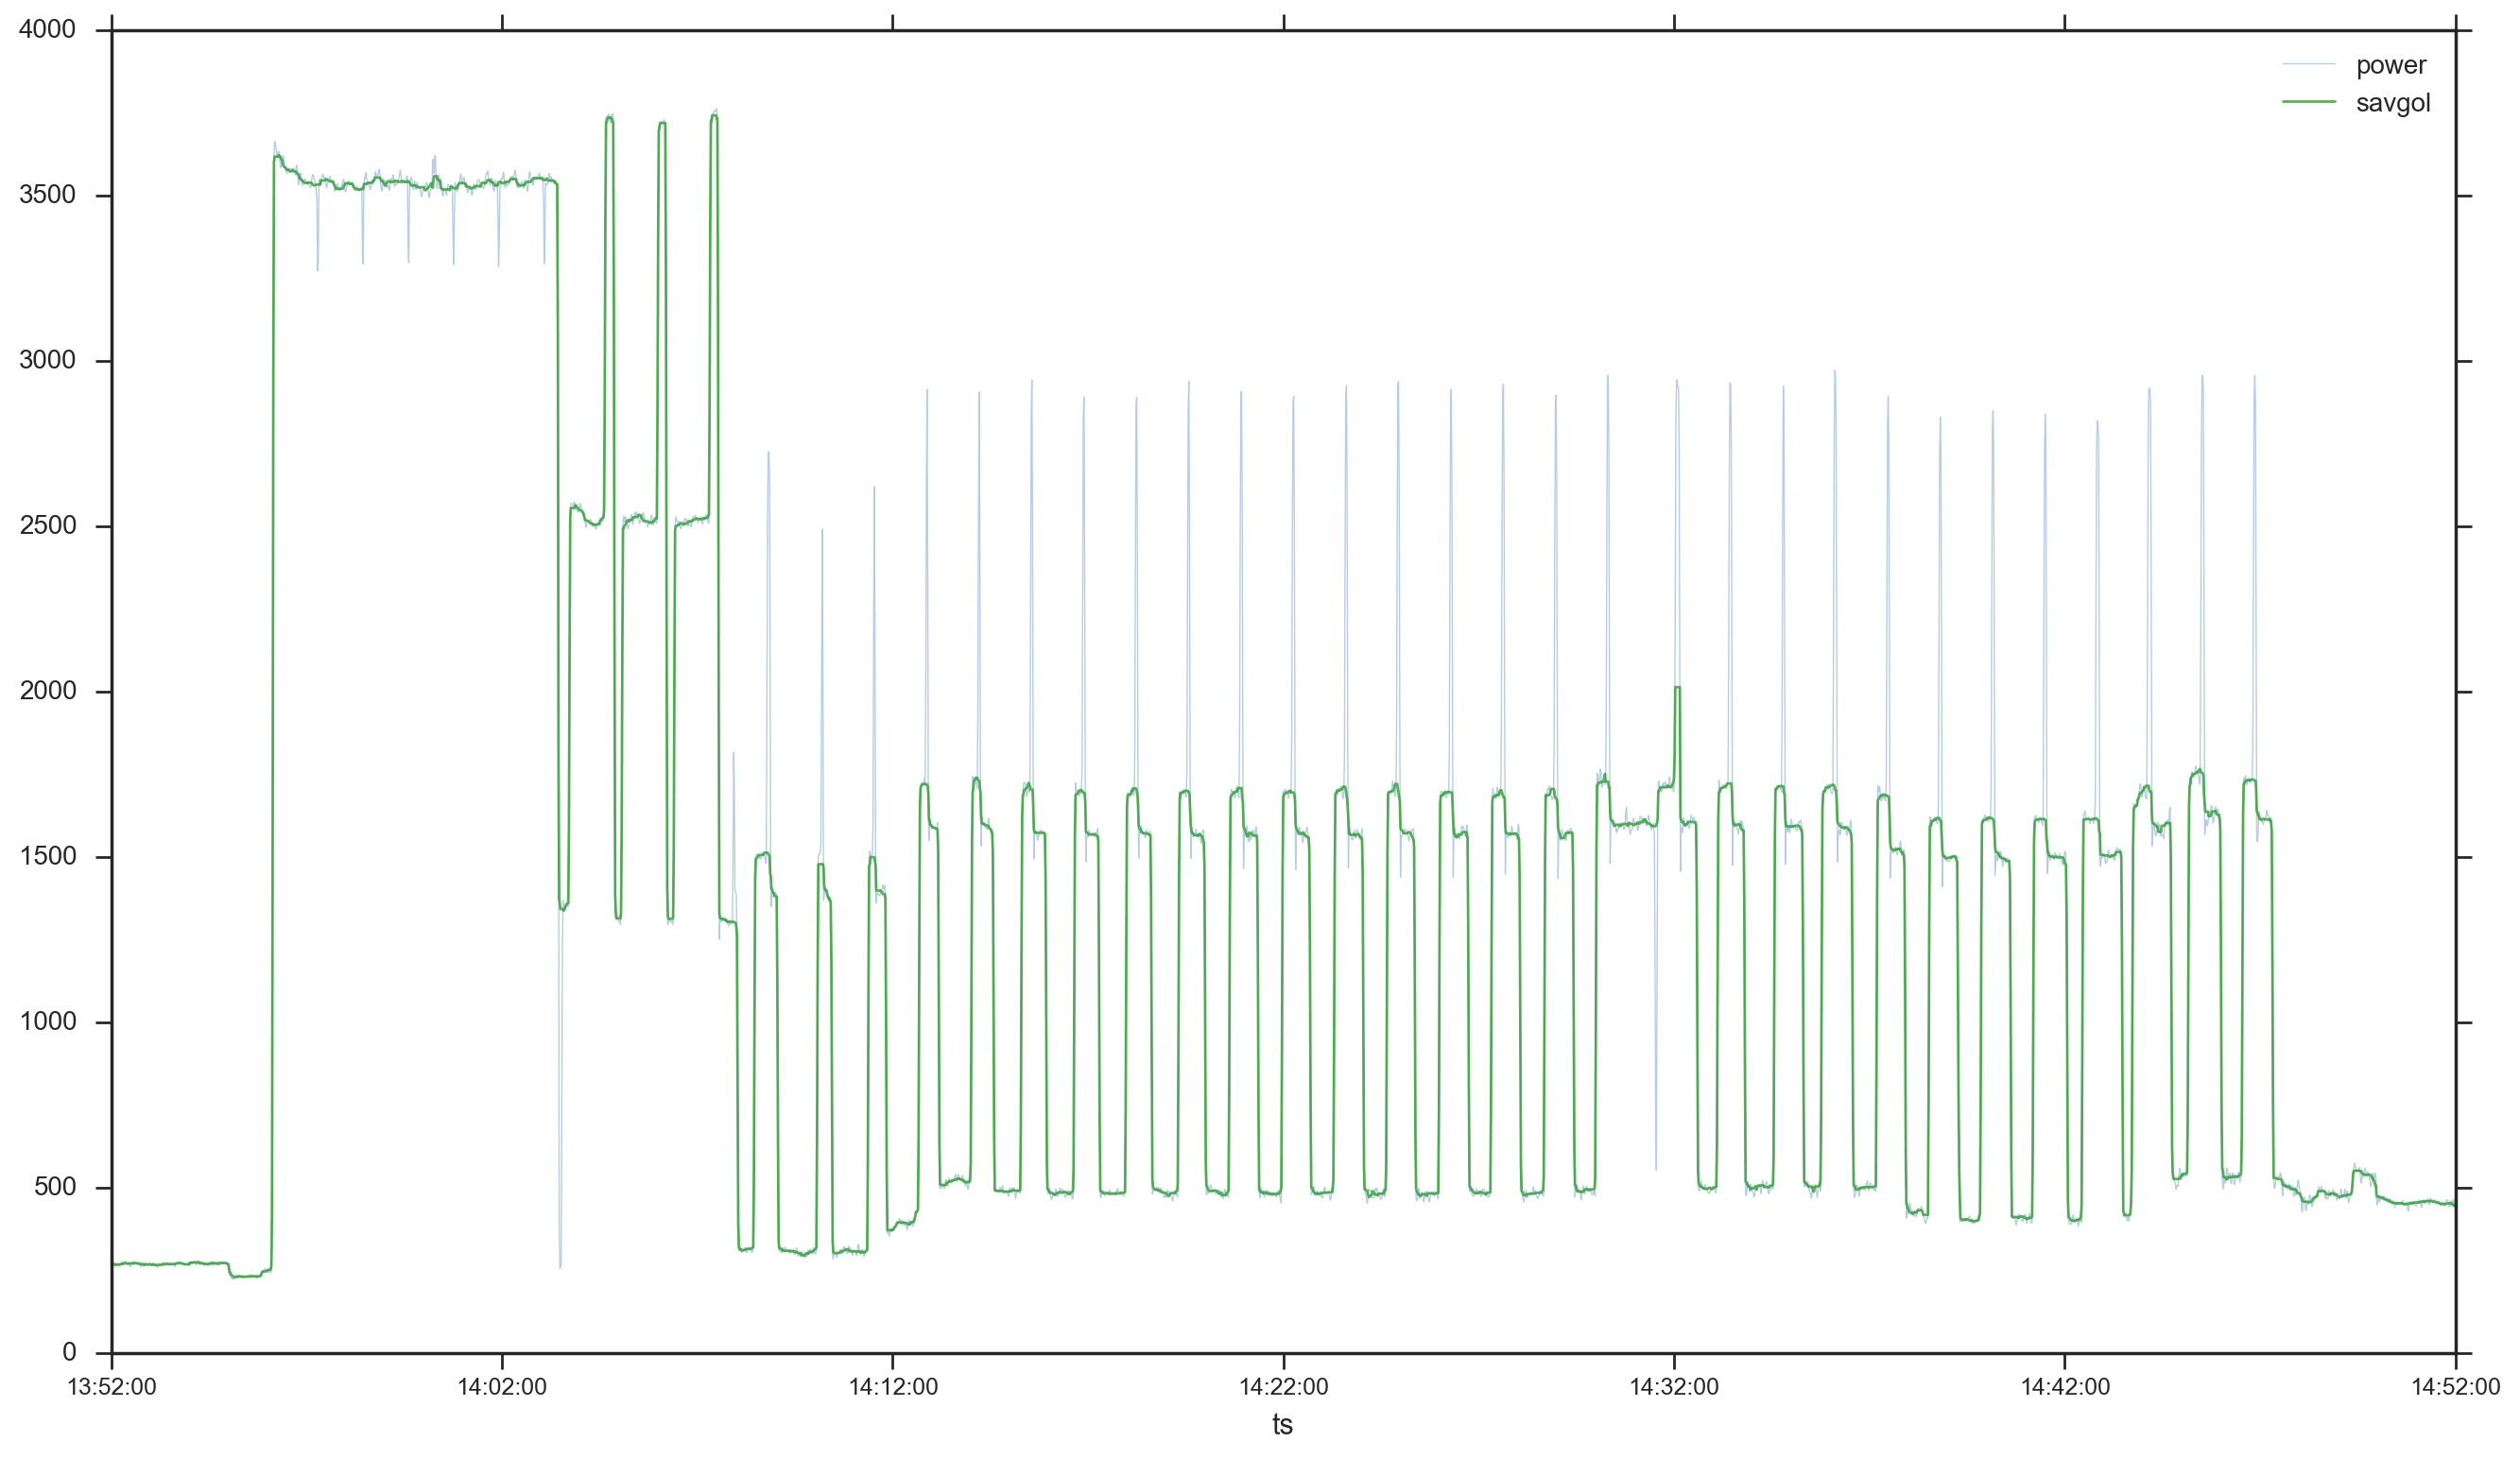

In [73]:
plot_savgol(df_5sg.between_time('13:52', '14:52'))

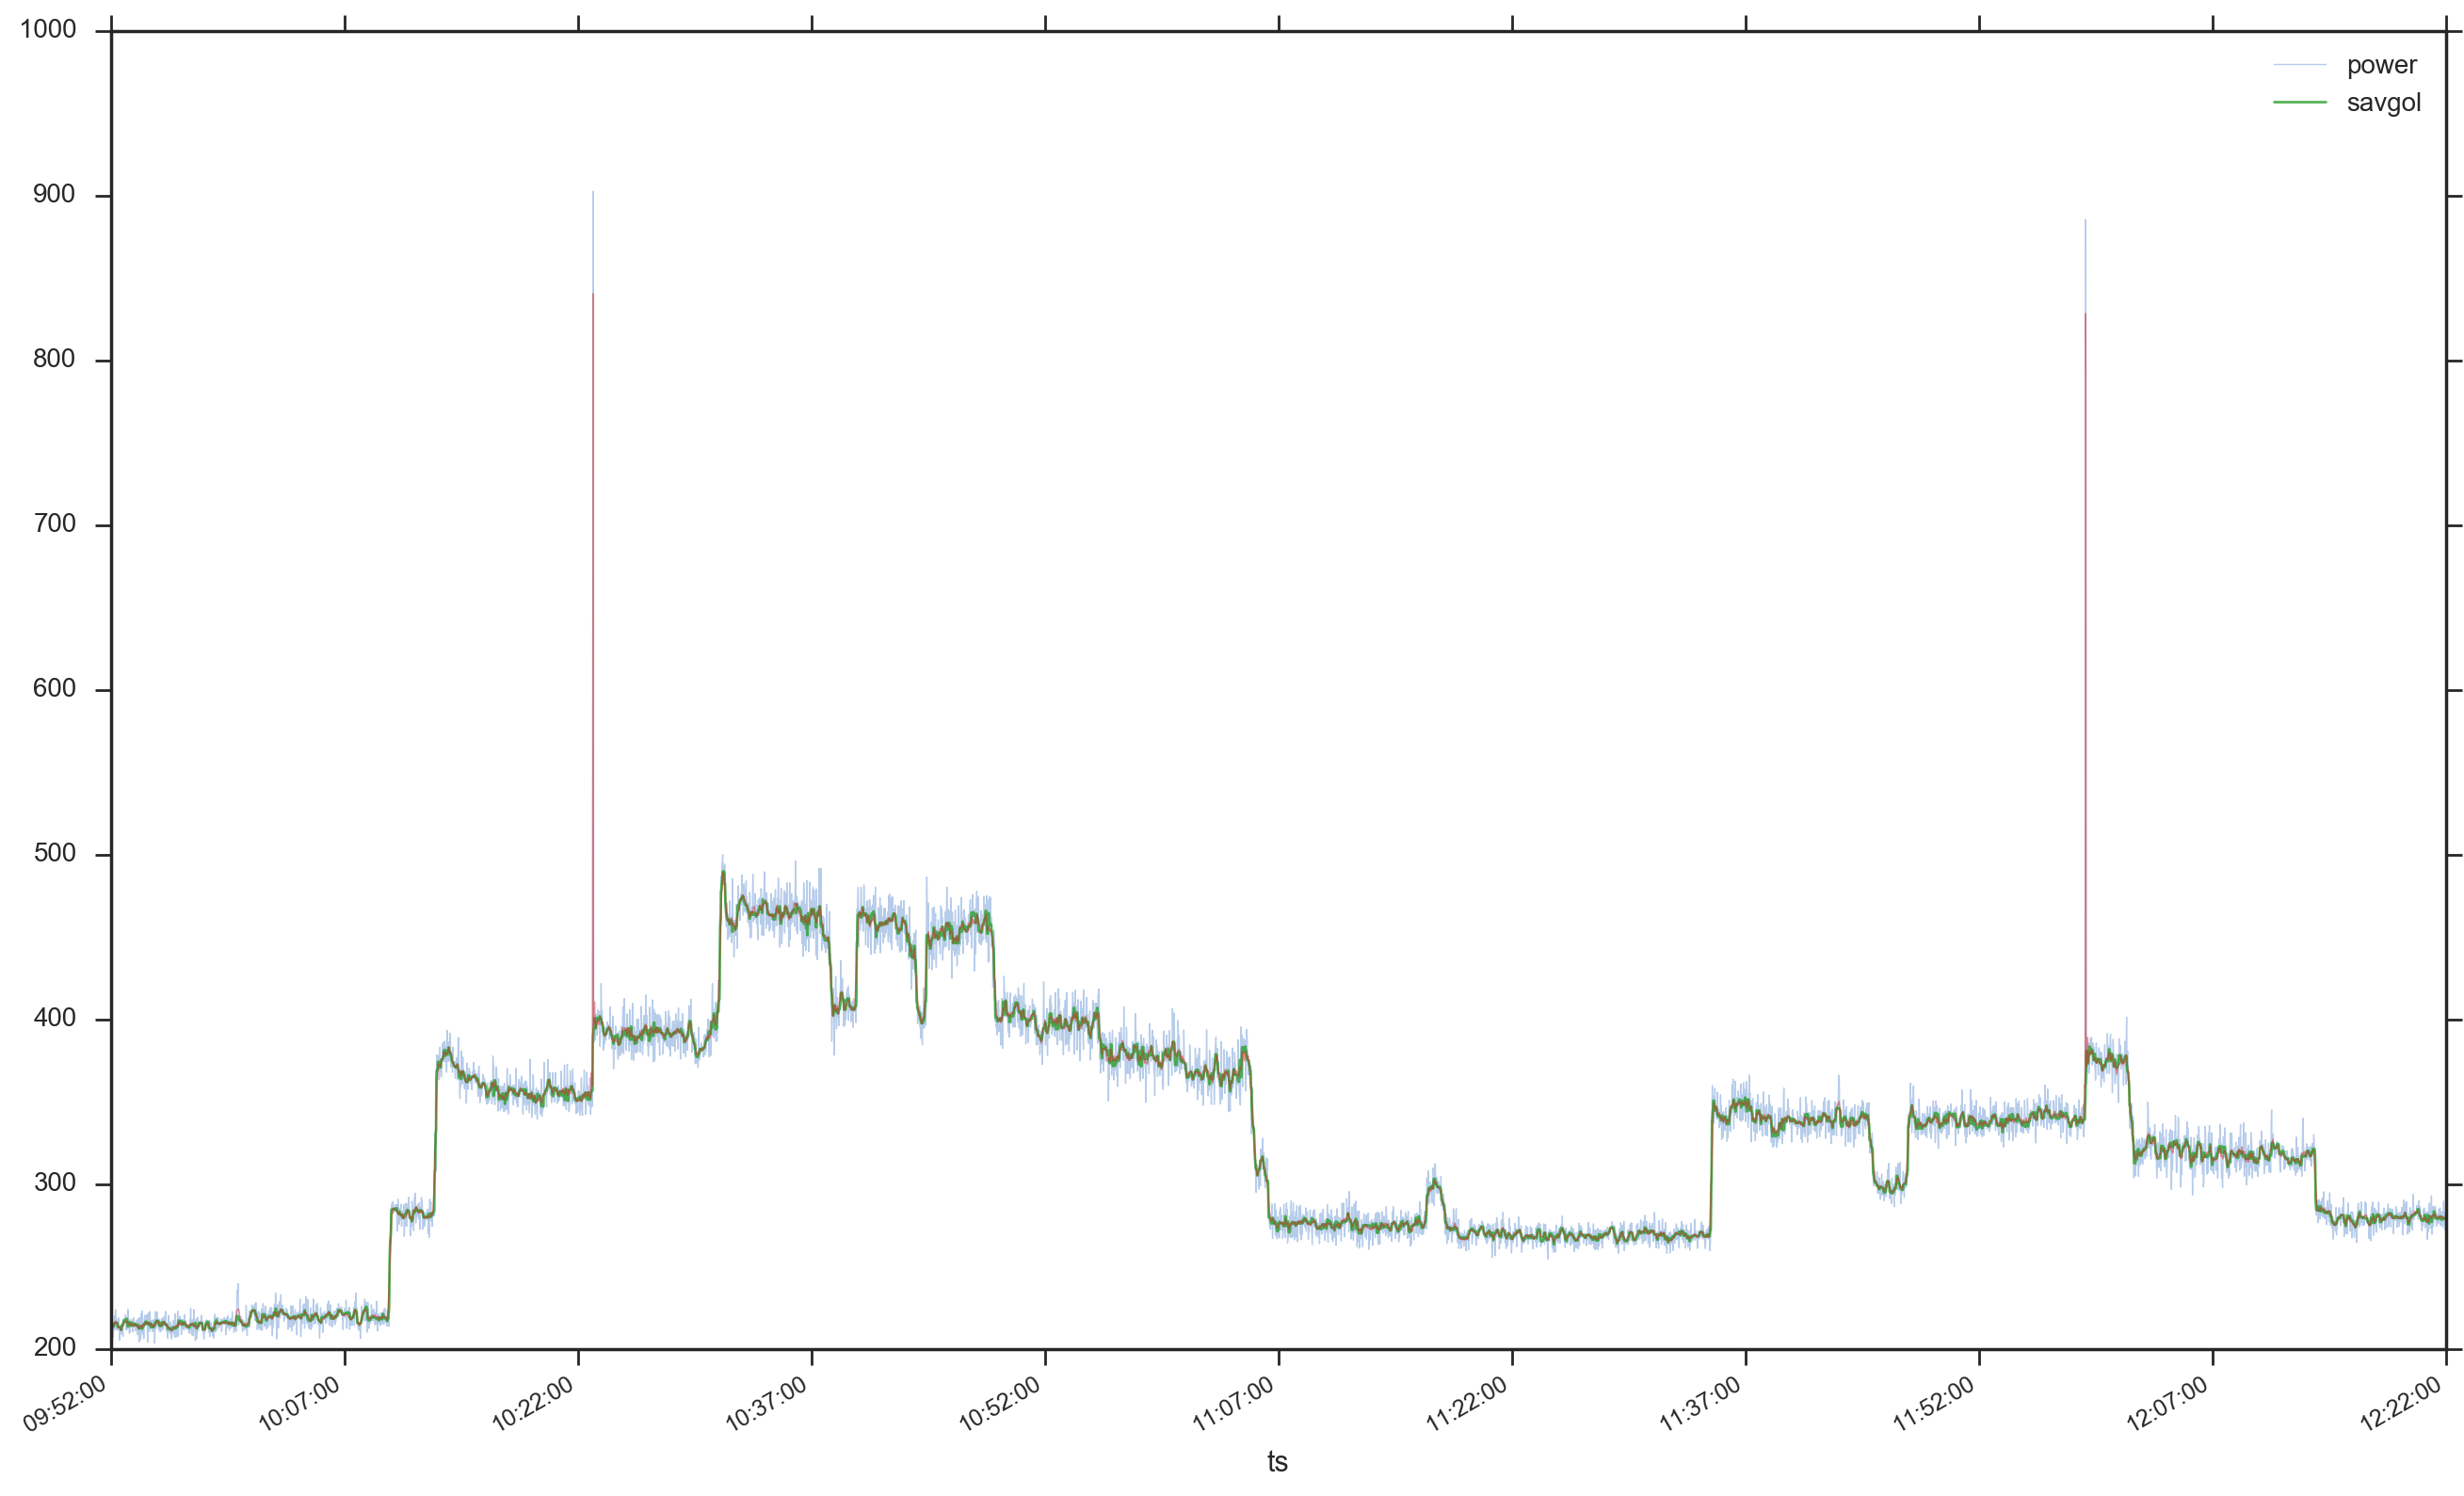

In [78]:
ax = plot_savgol(df_5sg.between_time('9:52', '12:22'))
df_5sg.between_time('9:52', '12:22').wiener.plot(lw=.5, alpha=.5, color=tableau20[6])

In [ ]:
# Detección de intervalos
#lista_dfs = [df_1.between_time('8:51', '9:02'), df_2.between_time('13:45', '15:30'), df_2, df_3, df_4]
# lista_dfs = [df_2.between_time('13:45', '15:30')]
# lista_dfs = [df_5, df_6, df_7]
# lista_dfs = [df_7.between_time('08:00', '23:00')]
# lista_dfs = [df_7.between_time('10:40', '12:30')]

In [11]:
from fitter import Fitter


#f = Fitter(train)
#f.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
#f.summary()

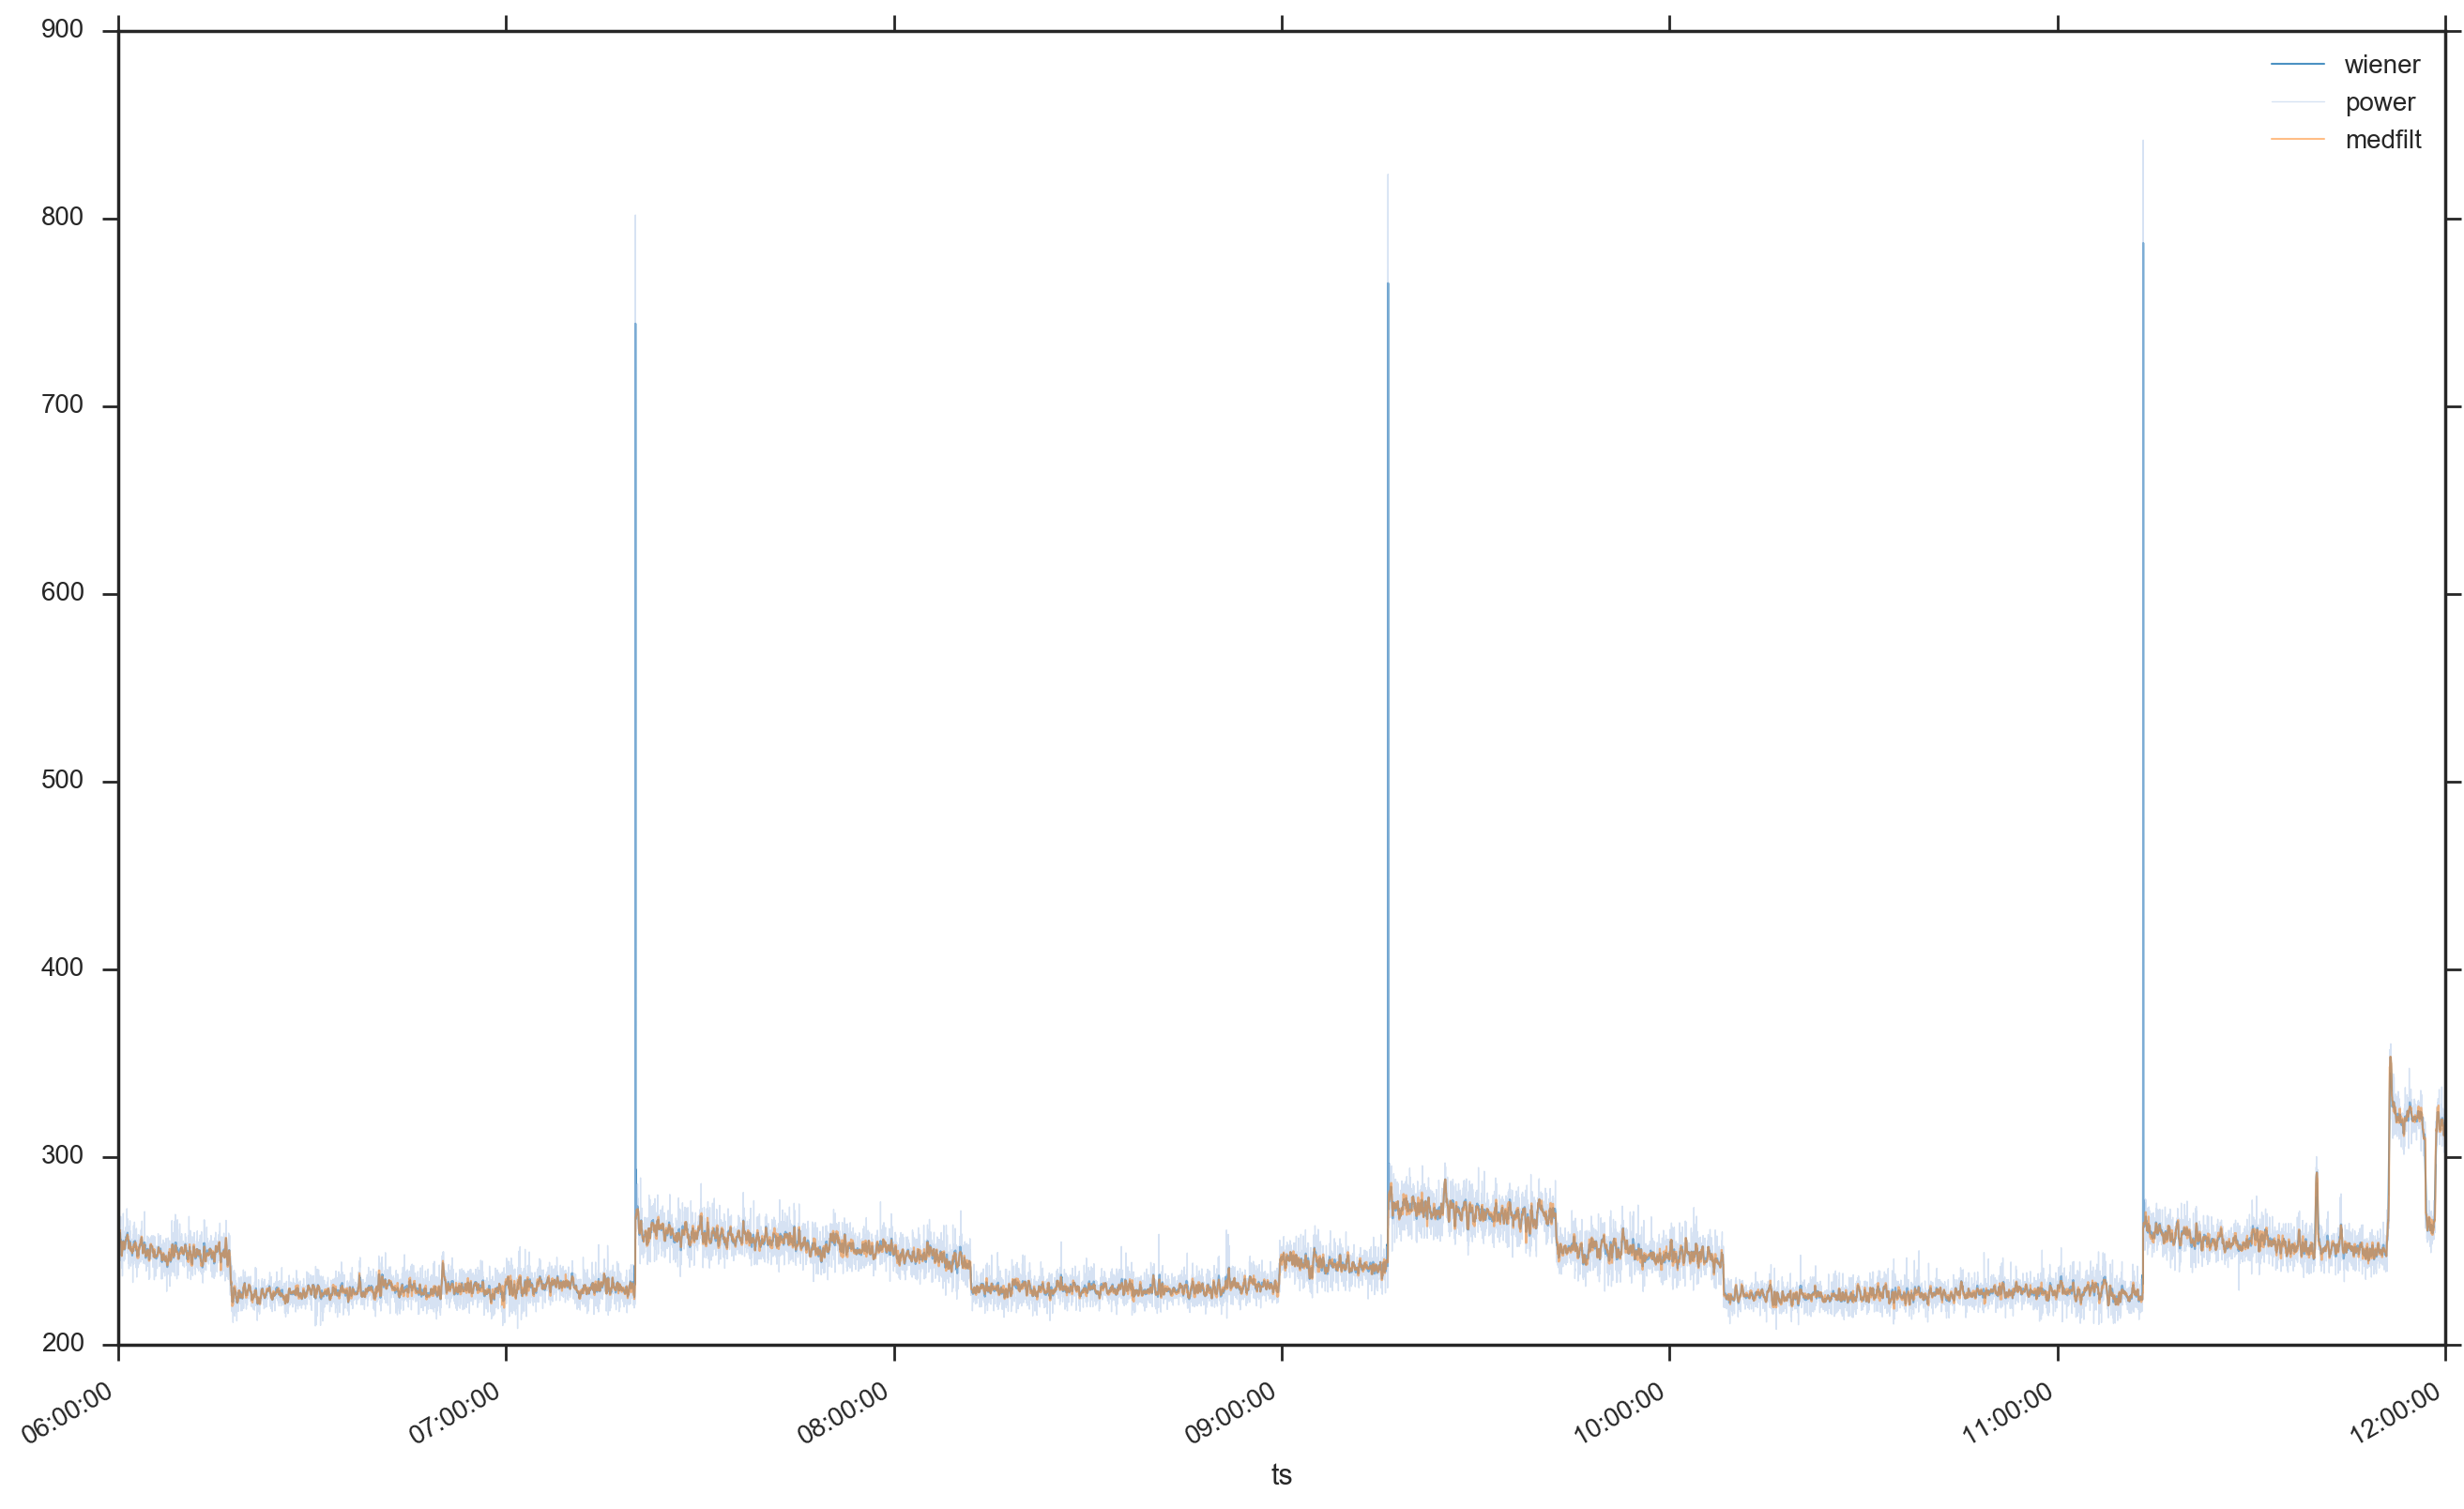

In [7]:
df = df_2.copy()

# print_cyan(scipy.signal.get_window())
df['medfilt'] = medfilt(df.power, kernel_size=15)
# df['firwin_hanning'] = firwin(df.power, kernel_size=15)

